In [ ]:
# The code in this project is form:
# https://kwotsin.github.io/tech/2017/02/11/transfer-learning.html
# There are some modifications to fit this project
# Use TensorFlow-Slim in this project

In [1]:
import tensorflow as tf
from tensorflow.contrib.framework.python.ops.variables import get_or_create_global_step
from tensorflow.python.platform import tf_logging as logging
from preprocessing import inception_preprocessing
from nets.inception_resnet_v2 import inception_resnet_v2, inception_resnet_v2_arg_scope
import os
import time
slim = tf.contrib.slim

/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [ ]:
# Download the pre-trained model from: 
# http://download.tensorflow.org/models/inception_resnet_v2_2016_08_30.tar.gz

In [ ]:
# Follow the tutorial of transforming the dataset into TFRecord files:
# https://kwotsin.github.io/tech/2017/01/29/tfrecords.html

In [ ]:
# Preparing the training session

In [2]:
#================ DATASET INFORMATION ======================
#State dataset directory where the tfrecord files are located
dataset_dir = './landmark_recognition'

#State where your log file is at. If it doesn't exist, create it.
log_dir = './landmark_recognition/log'

#State where your checkpoint file is
checkpoint_file = './pretrained_models/inception_resnet_v2_2016_08_30.ckpt'

#State the image size you're resizing your images to. We will use the default inception size of 299.
image_size = 299

#State the number of classes to predict:
num_classes = 100

#State the labels file and read it
labels_file = './landmark_recognition/labels.txt'
labels = open(labels_file, 'r')

#Create a dictionary to refer each label to their string name
labels_to_name = {}
for line in labels:
    label, string_name = line.split(':')
    string_name = string_name[:-1] #Remove newline
    labels_to_name[int(label)] = string_name

#Create the file pattern of your TFRecord files so that it could be recognized later on
file_pattern = 'landmark_%s_*.tfrecord'

#Create a dictionary that will help people understand your dataset better. This is required by the Dataset class later.
items_to_descriptions = {
    'image': 'A 3-channel RGB coloured landmark image.',
    'label': 'A label for each landmark'
}


In [3]:
#================= TRAINING INFORMATION ==================
#State the number of epochs to train
num_epochs = 3

#State your batch size
batch_size = 10

#Learning rate information and configuration (Up to you to experiment)
initial_learning_rate = 0.0002
learning_rate_decay_factor = 0.7
num_epochs_before_decay = 2

In [4]:
def get_split(split_name, dataset_dir, file_pattern=file_pattern):
    """
    Obtains the split - training or validation - to create a Dataset class for feeding the examples into a queue later
    on. This function will set up the decoder and dataset information all into one Dataset class so that you can avoid
    the brute work later on.
    
    Your file_pattern is very important in locating the files later. 

    INPUTS:
        - split_name(str): 'train' or 'validation'. Used to get the correct data split of tfrecord files
        - dataset_dir(str): the dataset directory where the tfrecord files are located
        - file_pattern(str): the file name structure of the tfrecord files in order to get the correct data

    OUTPUTS:
    - dataset (Dataset): A Dataset class object where we can read its various components for easier batch creation.
    """
    #First check whether the split_name is train or validation
    if split_name not in ['train', 'validation']:
        raise ValueError(\
        'The split_name %s is not recognized. Please input either train or validation as the split_name'\
        % (split_name))

    #Create the full path for a general file_pattern to locate the tfrecord_files
    file_pattern_path = os.path.join(dataset_dir, file_pattern % (split_name))

    #Count the total number of examples in all of these shard
    num_samples = 0
    file_pattern_for_counting = 'landmark_' + split_name
    tfrecords_to_count = [os.path.join(dataset_dir, file) for file in os.listdir(dataset_dir)\
                         if file.startswith(file_pattern_for_counting)]
    for tfrecord_file in tfrecords_to_count:
        for record in tf.python_io.tf_record_iterator(tfrecord_file):
            num_samples += 1

    #Create a reader, which must be a TFRecord reader in this case
    reader = tf.TFRecordReader

    #Create the keys_to_features dictionary for the decoder
    keys_to_features = {
      'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
      'image/format': tf.FixedLenFeature((), tf.string, default_value='jpg'),
      'image/class/label': tf.FixedLenFeature(
          [], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
    }

    #Create the items_to_handlers dictionary for the decoder.
    items_to_handlers = {
    'image': slim.tfexample_decoder.Image(),
    'label': slim.tfexample_decoder.Tensor('image/class/label'),
    }

    #Start to create the decoder
    decoder = slim.tfexample_decoder.TFExampleDecoder(keys_to_features, items_to_handlers)

    #Create the labels_to_name file
    labels_to_name_dict = labels_to_name

    #Actually create the dataset
    dataset = slim.dataset.Dataset(
        data_sources = file_pattern_path,
        decoder = decoder,
        reader = reader,
        num_readers = 4,
        num_samples = num_samples,
        num_classes = num_classes,
        labels_to_name = labels_to_name_dict,
        items_to_descriptions = items_to_descriptions)

    return dataset

In [5]:
def load_batch(dataset, batch_size, height=image_size, width=image_size, is_training=True):
    '''
    Loads a batch for training.

    INPUTS:
    - dataset(Dataset): a Dataset class object that is created from the get_split function
    - batch_size(int): determines how big of a batch to train
    - height(int): the height of the image to resize to during preprocessing
    - width(int): the width of the image to resize to during preprocessing
    - is_training(bool): to determine whether to perform a training or evaluation preprocessing

    OUTPUTS:
    - images(Tensor): a Tensor of the shape (batch_size, height, width, channels) that contain one batch of images
    - labels(Tensor): the batch's labels with the shape (batch_size,) (requires one_hot_encoding).

    '''
    #First create the data_provider object
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset,
        common_queue_capacity = 24 + 3 * batch_size,
        common_queue_min = 24)

    #Obtain the raw image using the get method
    raw_image, label = data_provider.get(['image', 'label'])

    #Perform the correct preprocessing for this image depending if it is training or evaluating
    image = inception_preprocessing.preprocess_image(raw_image, height, width, is_training)

    #As for the raw images, we just do a simple reshape to batch it up
    raw_image = tf.expand_dims(raw_image, 0)
    raw_image = tf.image.resize_nearest_neighbor(raw_image, [height, width])
    raw_image = tf.squeeze(raw_image)

    #Batch up the image by enqueing the tensors internally in a FIFO queue and dequeueing many elements with tf.train.batch.
    images, raw_images, labels = tf.train.batch(
        [image, raw_image, label],
        batch_size = batch_size,
        num_threads = 4,
        capacity = 4 * batch_size,
        allow_smaller_final_batch = True)

    return images, raw_images, labels

In [6]:
def run():
    #Create the log directory here. Must be done here otherwise import will activate this unneededly.
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)

    #======================= TRAINING PROCESS =========================
    #Now we start to construct the graph and build our model
    with tf.Graph().as_default() as graph:
        tf.logging.set_verbosity(tf.logging.INFO) #Set the verbosity to INFO level

        #First create the dataset and load one batch
        dataset = get_split('train', dataset_dir, file_pattern=file_pattern)
        images, _, labels = load_batch(dataset, batch_size=batch_size)

        #Know the number steps to take before decaying the learning rate and batches per epoch
        num_batches_per_epoch = int(dataset.num_samples / batch_size)
        num_steps_per_epoch = num_batches_per_epoch #Because one step is one batch processed
        decay_steps = int(num_epochs_before_decay * num_steps_per_epoch)

        #Create the model inference
        with slim.arg_scope(inception_resnet_v2_arg_scope()):
            logits, end_points = inception_resnet_v2(images, num_classes = dataset.num_classes, is_training = True)

        #Define the scopes that you want to exclude for restoration
        exclude = ['InceptionResnetV2/Logits', 'InceptionResnetV2/AuxLogits']
        variables_to_restore = slim.get_variables_to_restore(exclude = exclude)

        #Perform one-hot-encoding of the labels (Try one-hot-encoding within the load_batch function!)
        one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)

        #Performs the equivalent to tf.nn.sparse_softmax_cross_entropy_with_logits but enhanced with checks
        loss = tf.losses.softmax_cross_entropy(onehot_labels = one_hot_labels, logits = logits)
        total_loss = tf.losses.get_total_loss()    #obtain the regularization losses as well

        #Create the global step for monitoring the learning_rate and training.
        global_step = get_or_create_global_step()

        #Define your exponentially decaying learning rate
        lr = tf.train.exponential_decay(
            learning_rate = initial_learning_rate,
            global_step = global_step,
            decay_steps = decay_steps,
            decay_rate = learning_rate_decay_factor,
            staircase = True)

        #Now we can define the optimizer that takes on the learning rate
        optimizer = tf.train.AdamOptimizer(learning_rate = lr)

        #Create the train_op.
        train_op = slim.learning.create_train_op(total_loss, optimizer)

        #State the metrics that you want to predict. We get a predictions that is not one_hot_encoded.
        predictions = tf.argmax(end_points['Predictions'], 1)
        probabilities = end_points['Predictions']
        accuracy, accuracy_update = tf.contrib.metrics.streaming_accuracy(predictions, labels)
        metrics_op = tf.group(accuracy_update, probabilities)


        #Now finally create all the summaries you need to monitor and group them into one summary op.
        tf.summary.scalar('losses/Total_Loss', total_loss)
        tf.summary.scalar('accuracy', accuracy)
        tf.summary.scalar('learning_rate', lr)
        my_summary_op = tf.summary.merge_all()

        #Now we need to create a training step function that runs both the train_op, metrics_op and updates the global_step concurrently.
        def train_step(sess, train_op, global_step):
            '''
            Simply runs a session for the three arguments provided and gives a logging on the time elapsed for each global step
            '''
            #Check the time for each sess run
            start_time = time.time()
            total_loss, global_step_count, _ = sess.run([train_op, global_step, metrics_op])
            time_elapsed = time.time() - start_time

            #Run the logging to print some results
            logging.info('global step %s: loss: %.4f (%.2f sec/step)', global_step_count, total_loss, time_elapsed)

            return total_loss, global_step_count

        #Now we create a saver function that actually restores the variables from a checkpoint file in a sess
        saver = tf.train.Saver(variables_to_restore)
        def restore_fn(sess):
            return saver.restore(sess, checkpoint_file)

        #Define your supervisor for running a managed session. Do not run the summary_op automatically or else it will consume too much memory
        sv = tf.train.Supervisor(logdir = log_dir, summary_op = None, init_fn = restore_fn)


        #Run the managed session
        with sv.managed_session() as sess:
            for step in range(num_steps_per_epoch * num_epochs):
                #At the start of every epoch, show the vital information:
                if step % num_batches_per_epoch == 0:
                    logging.info('Epoch %s/%s', step/num_batches_per_epoch + 1, num_epochs)
                    learning_rate_value, accuracy_value = sess.run([lr, accuracy])
                    logging.info('Current Learning Rate: %s', learning_rate_value)
                    logging.info('Current Streaming Accuracy: %s', accuracy_value)

                    # optionally, print your logits and predictions for a sanity check that things are going fine.
                    logits_value, probabilities_value, predictions_value, labels_value = sess.run([logits, probabilities, predictions, labels])
                    print('logits: \n', logits_value)
                    print('Probabilities: \n', probabilities_value)
                    print('predictions: \n', predictions_value)
                    print('Labels:\n:', labels_value)

                #Log the summaries every 10 step.
                if step % 10 == 0:
                    loss, _ = train_step(sess, train_op, sv.global_step)
                    summaries = sess.run(my_summary_op)
                    sv.summary_computed(sess, summaries)
                    
                #If not, simply run the training step
                else:
                    loss, _ = train_step(sess, train_op, sv.global_step)

            #We log the final training loss and accuracy
            logging.info('Final Loss: %s', loss)
            logging.info('Final Accuracy: %s', sess.run(accuracy))

            #Once all the training has been done, save the log files and checkpoint model
            logging.info('Finished training! Saving model to disk now.')
            # saver.save(sess, "./flowers_model.ckpt")
            sv.saver.save(sess, sv.save_path, global_step = sv.global_step)

In [ ]:
# Run the training session

In [7]:
if __name__ == '__main__':
    run()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
INFO:tensorflow:Restoring parameters from ./pretrained_models/inception_resnet_v2_2016_08_30.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Epoch 1.0/3
INFO:tensorflow:Current Learning Rate: 0.0002
INFO:tensorflow:Current Streaming Accuracy: 0.0
logits: 

INFO:tensorflow:global step 1: loss: 5.0773 (38.87 sec/step)
INFO:tensorflow:global step 2: loss: 5.2584 (30.34 sec/step)
INFO:tensorflow:global_step/sec: 0.0166669
INFO:tensorflow:global step 3: loss: 5.4580 (30.51 sec/step)
INFO:tensorflow:global step 4: loss: 5.0802 (30.35 sec/step)
INFO:tensorflow:global step 5: loss: 5.1559 (30.39 sec/step)
INFO:tensorflow:global step 6: loss: 5.0134 (30.38 sec/step)
INFO:tensorflow:global_step/sec: 0.0333332
INFO:tensorflow:global step 7: loss: 4.5242 (30.49 sec/step)
INFO:tensorflow:global step 8: loss: 4.9344 (30.51 sec/step)
INFO:tensorflow:global step 9: loss: 4.9370 (30.71 sec/step)
INFO:tensorflow:global step 10: loss: 4.9571 (30.72 sec/step)
INFO:tensorflow:global_step/sec: 0.033324
INFO:tensorflow:global step 11: loss: 4.9709 (31.62 sec/step)
INFO:tensorflow:global step 12: loss: 4.5582 (31.43 sec/step)
INFO:tensorflow:global step 13: loss: 4.4412 (31.39 sec/step)
INFO:tensorflow:global step 14: loss: 4.1755 (31.66 sec/step)
INFO:tensorfl

INFO:tensorflow:global step 120: loss: 2.3515 (29.40 sec/step)
INFO:tensorflow:global step 121: loss: 3.1312 (29.78 sec/step)
INFO:tensorflow:global step 122: loss: 2.5795 (29.80 sec/step)
INFO:tensorflow:global step 123: loss: 3.1096 (29.43 sec/step)
INFO:tensorflow:global step 124: loss: 2.8277 (29.59 sec/step)
INFO:tensorflow:global step 125: loss: 2.6019 (29.78 sec/step)
INFO:tensorflow:global step 126: loss: 2.0843 (29.80 sec/step)
INFO:tensorflow:global step 127: loss: 2.2884 (29.56 sec/step)
INFO:tensorflow:global step 128: loss: 2.3532 (29.53 sec/step)
INFO:tensorflow:global step 129: loss: 3.1523 (29.77 sec/step)
INFO:tensorflow:global step 130: loss: 2.8044 (29.74 sec/step)
INFO:tensorflow:global step 131: loss: 2.9330 (29.69 sec/step)
INFO:tensorflow:global step 132: loss: 2.2650 (29.95 sec/step)
INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:global step 133: loss: 2.2371 (33.03 sec/step)
INFO:tensorflow:global step 134: loss:

INFO:tensorflow:global step 243: loss: 1.4980 (29.85 sec/step)
INFO:tensorflow:global step 244: loss: 2.2401 (29.56 sec/step)
INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:global step 245: loss: 1.7404 (29.70 sec/step)
INFO:tensorflow:global step 246: loss: 2.0812 (32.78 sec/step)
INFO:tensorflow:global step 247: loss: 2.0026 (29.39 sec/step)
INFO:tensorflow:global step 248: loss: 1.4105 (29.55 sec/step)
INFO:tensorflow:global step 249: loss: 1.2295 (29.53 sec/step)
INFO:tensorflow:global step 250: loss: 1.7288 (29.44 sec/step)
INFO:tensorflow:global step 251: loss: 2.2280 (29.63 sec/step)
INFO:tensorflow:global step 252: loss: 1.9371 (29.64 sec/step)
INFO:tensorflow:global step 253: loss: 1.7463 (29.35 sec/step)
INFO:tensorflow:global step 254: loss: 2.9330 (29.22 sec/step)
INFO:tensorflow:global step 255: loss: 2.8077 (29.36 sec/step)
INFO:tensorflow:global step 256: loss: 1.5775 (29.57 sec/step)
INFO:tensorflow:global step 257: loss:

INFO:tensorflow:global step 281: loss: 1.6846 (29.71 sec/step)
INFO:tensorflow:global step 282: loss: 1.6187 (29.69 sec/step)
INFO:tensorflow:global step 283: loss: 1.9191 (29.90 sec/step)
INFO:tensorflow:global step 284: loss: 1.8094 (29.53 sec/step)
INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:global step 285: loss: 1.8132 (33.29 sec/step)
INFO:tensorflow:global step 286: loss: 1.6275 (29.00 sec/step)
INFO:tensorflow:global step 287: loss: 2.7422 (29.46 sec/step)
INFO:tensorflow:global step 288: loss: 2.7001 (29.21 sec/step)
INFO:tensorflow:global step 289: loss: 1.2989 (29.24 sec/step)
INFO:tensorflow:global step 290: loss: 2.2782 (30.06 sec/step)
INFO:tensorflow:global step 291: loss: 2.1725 (30.87 sec/step)
INFO:tensorflow:global step 292: loss: 1.2732 (29.73 sec/step)
INFO:tensorflow:global step 293: loss: 2.3343 (29.72 sec/step)
INFO:tensorflow:global step 294: loss: 2.7998 (29.38 sec/step)
INFO:tensorflow:global step 295: loss:

INFO:tensorflow:global step 403: loss: 1.2755 (31.71 sec/step)
INFO:tensorflow:global step 404: loss: 2.6838 (29.88 sec/step)
INFO:tensorflow:global step 405: loss: 1.9148 (29.41 sec/step)
INFO:tensorflow:global step 406: loss: 1.6518 (29.34 sec/step)
INFO:tensorflow:global step 407: loss: 2.5513 (29.33 sec/step)
INFO:tensorflow:global step 408: loss: 1.4436 (30.25 sec/step)
INFO:tensorflow:global step 409: loss: 1.6640 (31.16 sec/step)
INFO:tensorflow:global step 410: loss: 1.8143 (28.54 sec/step)
INFO:tensorflow:global step 411: loss: 1.6706 (28.27 sec/step)
INFO:tensorflow:global step 412: loss: 1.3374 (28.35 sec/step)
INFO:tensorflow:global step 413: loss: 1.4185 (29.63 sec/step)
INFO:tensorflow:global step 414: loss: 1.7276 (28.83 sec/step)
INFO:tensorflow:global step 415: loss: 1.7744 (28.63 sec/step)
INFO:tensorflow:global step 416: loss: 3.0343 (28.76 sec/step)
INFO:tensorflow:global step 417: loss: 3.1728 (28.63 sec/step)
INFO:tensorflow:global step 418: loss: 1.0360 (28.60 se

INFO:tensorflow:global step 526: loss: 0.8438 (28.98 sec/step)
INFO:tensorflow:global step 527: loss: 0.8493 (29.12 sec/step)
INFO:tensorflow:global step 528: loss: 1.2514 (31.77 sec/step)
INFO:tensorflow:global step 529: loss: 1.2337 (30.35 sec/step)
INFO:tensorflow:global step 530: loss: 0.7276 (28.51 sec/step)
INFO:tensorflow:global step 531: loss: 2.6208 (28.50 sec/step)
INFO:tensorflow:global step 532: loss: 3.0015 (28.92 sec/step)
INFO:tensorflow:global step 533: loss: 1.2447 (29.12 sec/step)
INFO:tensorflow:global step 534: loss: 0.8256 (29.37 sec/step)
INFO:tensorflow:global step 535: loss: 2.6350 (29.48 sec/step)
INFO:tensorflow:global step 536: loss: 1.1175 (29.59 sec/step)
INFO:tensorflow:global step 537: loss: 2.5740 (29.32 sec/step)
INFO:tensorflow:global step 538: loss: 1.3898 (29.23 sec/step)
INFO:tensorflow:global step 539: loss: 1.2041 (29.12 sec/step)
INFO:tensorflow:global step 540: loss: 1.6770 (28.96 sec/step)
INFO:tensorflow:global step 541: loss: 1.0975 (29.45 se

INFO:tensorflow:global step 561: loss: 2.3736 (28.95 sec/step)
INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:global step 562: loss: 1.0502 (30.71 sec/step)
INFO:tensorflow:global step 563: loss: 1.7594 (30.12 sec/step)
INFO:tensorflow:global step 564: loss: 2.8012 (28.96 sec/step)
INFO:tensorflow:global step 565: loss: 1.9453 (28.78 sec/step)
INFO:tensorflow:global step 566: loss: 1.5547 (28.67 sec/step)
INFO:tensorflow:global step 567: loss: 1.3891 (28.97 sec/step)
INFO:tensorflow:global step 568: loss: 1.4011 (29.00 sec/step)
INFO:tensorflow:global step 569: loss: 1.7370 (28.96 sec/step)
INFO:tensorflow:global step 570: loss: 1.7786 (29.17 sec/step)
INFO:tensorflow:global step 571: loss: 0.9267 (28.99 sec/step)
INFO:tensorflow:global step 572: loss: 1.0028 (29.28 sec/step)
INFO:tensorflow:global step 573: loss: 1.9004 (29.21 sec/step)
INFO:tensorflow:global step 574: loss: 1.9856 (29.06 sec/step)
INFO:tensorflow:global step 575: loss:

INFO:tensorflow:global step 683: loss: 1.1838 (30.90 sec/step)
INFO:tensorflow:global step 684: loss: 1.5538 (28.15 sec/step)
INFO:tensorflow:global step 685: loss: 1.4120 (28.35 sec/step)
INFO:tensorflow:global step 686: loss: 1.2067 (28.43 sec/step)
INFO:tensorflow:global step 687: loss: 1.5065 (28.24 sec/step)
INFO:tensorflow:global step 688: loss: 1.6848 (28.32 sec/step)
INFO:tensorflow:global step 689: loss: 1.2318 (28.05 sec/step)
INFO:tensorflow:global step 690: loss: 1.0670 (28.34 sec/step)
INFO:tensorflow:global step 691: loss: 0.6880 (28.28 sec/step)
INFO:tensorflow:global step 692: loss: 1.1033 (28.17 sec/step)
INFO:tensorflow:global step 693: loss: 1.2472 (28.12 sec/step)
INFO:tensorflow:global step 694: loss: 0.7122 (28.16 sec/step)
INFO:tensorflow:global step 695: loss: 1.3216 (28.41 sec/step)
INFO:tensorflow:global step 696: loss: 1.4026 (28.17 sec/step)
INFO:tensorflow:global step 697: loss: 2.2557 (28.06 sec/step)
INFO:tensorflow:global step 698: loss: 2.9612 (28.04 se

INFO:tensorflow:global step 806: loss: 1.8381 (28.92 sec/step)
INFO:tensorflow:global step 807: loss: 0.7268 (28.67 sec/step)
INFO:tensorflow:global step 808: loss: 0.8772 (28.73 sec/step)
INFO:tensorflow:global step 809: loss: 1.1797 (28.96 sec/step)
INFO:tensorflow:global step 810: loss: 1.0870 (28.92 sec/step)
INFO:tensorflow:global step 811: loss: 1.8963 (29.37 sec/step)
INFO:tensorflow:global step 812: loss: 1.6740 (28.95 sec/step)
INFO:tensorflow:global step 813: loss: 1.2693 (29.00 sec/step)
INFO:tensorflow:global step 814: loss: 1.3340 (29.10 sec/step)
INFO:tensorflow:global step 815: loss: 0.6868 (29.77 sec/step)
INFO:tensorflow:global step 816: loss: 0.8377 (28.05 sec/step)
INFO:tensorflow:global step 817: loss: 1.1214 (28.19 sec/step)
INFO:tensorflow:global step 818: loss: 0.7954 (28.63 sec/step)
INFO:tensorflow:global step 819: loss: 0.7532 (28.33 sec/step)
INFO:tensorflow:global step 820: loss: 1.4657 (28.82 sec/step)
INFO:tensorflow:global step 821: loss: 0.8624 (28.85 se

In [ ]:
# Prepare for Evaluating the model

In [8]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
slim = tf.contrib.slim

#Create a new evaluation log directory to visualize the validation process
log_eval = './landmark_recognition/log_eval_test'

#State the dataset directory where the validation set is found
dataset_dir = './landmark_recognition'

#State the batch_size to evaluate each time, which can be a lot more than the training batch
batch_size = 10

#State the number of epochs to evaluate
num_epochs = 1

#Get the latest checkpoint file
checkpoint_file = tf.train.latest_checkpoint(log_dir)

In [9]:
def eval_run():
    #Create log_dir for evaluation information
    if not os.path.exists(log_eval):
        os.mkdir(log_eval)

    #Just construct the graph from scratch again
    with tf.Graph().as_default() as graph:
        tf.logging.set_verbosity(tf.logging.INFO)
        #Get the dataset first and load one batch of validation images and labels tensors. Set is_training as False so as to use the evaluation preprocessing
        dataset = get_split('validation', dataset_dir)
        images, raw_images, labels = load_batch(dataset, batch_size = batch_size, is_training = False)

        #Create some information about the training steps
        num_batches_per_epoch = dataset.num_samples / batch_size
        num_steps_per_epoch = int(num_batches_per_epoch)

        #Now create the inference model but set is_training=False
        with slim.arg_scope(inception_resnet_v2_arg_scope()):
            logits, end_points = inception_resnet_v2(images, num_classes = dataset.num_classes, is_training = False)

        # #get all the variables to restore from the checkpoint file and create the saver function to restore
        variables_to_restore = slim.get_variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)
        def restore_fn(sess):
            return saver.restore(sess, checkpoint_file)

        #Just define the metrics to track without the loss or whatsoever
        predictions = tf.argmax(end_points['Predictions'], 1)
        accuracy, accuracy_update = tf.contrib.metrics.streaming_accuracy(predictions, labels)
        metrics_op = tf.group(accuracy_update)

        #Create the global step and an increment op for monitoring
        global_step = get_or_create_global_step()
        global_step_op = tf.assign(global_step, global_step + 1) #no apply_gradient method so manually increasing the global_step
        

        #Create a evaluation step function
        def eval_step(sess, metrics_op, global_step):
            '''
            Simply takes in a session, runs the metrics op and some logging information.
            '''
            start_time = time.time()
            _, global_step_count, accuracy_value = sess.run([metrics_op, global_step_op, accuracy])
            time_elapsed = time.time() - start_time

            #Log some information
            logging.info('Global Step %s: Streaming Accuracy: %.4f (%.2f sec/step)', global_step_count, accuracy_value, time_elapsed)

            return accuracy_value


        #Define some scalar quantities to monitor
        tf.summary.scalar('Validation_Accuracy', accuracy)
        my_summary_op = tf.summary.merge_all()

        #Get your supervisor
        sv = tf.train.Supervisor(logdir = log_eval, summary_op = None, saver = None, init_fn = restore_fn)

        #Now we are ready to run in one session
        with sv.managed_session() as sess:
            for step in range(num_steps_per_epoch * num_epochs):
                sess.run(sv.global_step)
                #print vital information every start of the epoch as always
                if step % num_batches_per_epoch == 0:
                    logging.info('Epoch: %s/%s', step / num_batches_per_epoch + 1, num_epochs)
                    logging.info('Current Streaming Accuracy: %.4f', sess.run(accuracy))
                    
                #Compute summaries every 10 steps and continue evaluating
                if step % 10 == 0:
                    eval_step(sess, metrics_op = metrics_op, global_step = sv.global_step)
                    summaries = sess.run(my_summary_op)
                    sv.summary_computed(sess, summaries)
                    

                #Otherwise just run as per normal
                else:
                    eval_step(sess, metrics_op = metrics_op, global_step = sv.global_step)

            #At the end of all the evaluation, show the final accuracy
            logging.info('Final Streaming Accuracy: %.4f', sess.run(accuracy))

            #Now we want to visualize the last batch's images just to see what our model has predicted
            raw_images, labels, predictions = sess.run([raw_images, labels, predictions])
            for i in range(10):
                image, label, prediction = raw_images[i], labels[i], predictions[i]
                prediction_name, label_name = dataset.labels_to_name[prediction], dataset.labels_to_name[label]
                text = 'Prediction: %s \n Ground Truth: %s' %(prediction_name, label_name)
                img_plot = plt.imshow(image)

                #Set up the plot and hide axes
                plt.title(text)
                img_plot.axes.get_yaxis().set_ticks([])
                img_plot.axes.get_xaxis().set_ticks([])
                plt.show()

            logging.info('Model evaluation has completed! Visit TensorBoard for more information regarding your evaluation.')

In [ ]:
# Run the Evaluation session

INFO:tensorflow:Restoring parameters from ./landmark_recognition/log/model.ckpt-840
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:Epoch: 1.0/1
INFO:tensorflow:Current Streaming Accuracy: 0.0000
INFO:tensorflow:Global Step 1: Streaming Accuracy: 0.0000 (9.75 sec/step)
INFO:tensorflow:Global Step 2: Streaming Accuracy: 0.2000 (8.54 sec/step)
INFO:tensorflow:Global Step 3: Streaming Accuracy: 0.1000 (8.48 sec/step)
INFO:tensorflow:Global Step 4: Streaming Accuracy: 0.1333 (8.44 sec/step)
INFO:tensorflow:Global Step 5: Streaming Accuracy: 0.1000 (8.85 sec/step)
INFO:tensorflow:Global Step 6: Streaming Accuracy: 0.0800 (8.59 sec/step)
INFO:tensorflow:Global Step 7: Streaming Accuracy: 0.0667 (8.34 sec/step)
INFO:tensorflow:Global Step 8: Streaming Accuracy: 0.0714 (8.93 sec/step)
INFO:tensorflow:Global Step 9: Streaming Accuracy: 0.0625 (8.94 sec/step)
INF

INFO:tensorflow:Global Step 106: Streaming Accuracy: 0.0362 (9.01 sec/step)
INFO:tensorflow:Global Step 107: Streaming Accuracy: 0.0368 (8.90 sec/step)
INFO:tensorflow:Global Step 108: Streaming Accuracy: 0.0364 (8.73 sec/step)
INFO:tensorflow:Global Step 109: Streaming Accuracy: 0.0380 (8.65 sec/step)
INFO:tensorflow:Global Step 110: Streaming Accuracy: 0.0376 (9.12 sec/step)
INFO:tensorflow:Global Step 111: Streaming Accuracy: 0.0373 (8.72 sec/step)
INFO:tensorflow:Global Step 112: Streaming Accuracy: 0.0369 (8.71 sec/step)
INFO:tensorflow:Global Step 113: Streaming Accuracy: 0.0366 (10.00 sec/step)
INFO:tensorflow:Global Step 114: Streaming Accuracy: 0.0363 (8.89 sec/step)
INFO:tensorflow:Global Step 115: Streaming Accuracy: 0.0360 (10.90 sec/step)
INFO:tensorflow:Global Step 116: Streaming Accuracy: 0.0357 (11.70 sec/step)
INFO:tensorflow:Global Step 117: Streaming Accuracy: 0.0362 (8.89 sec/step)
INFO:tensorflow:Global Step 118: Streaming Accuracy: 0.0359 (9.14 sec/step)
INFO:tens

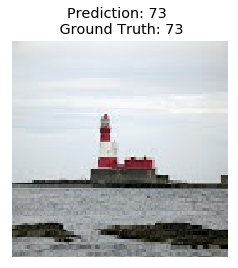

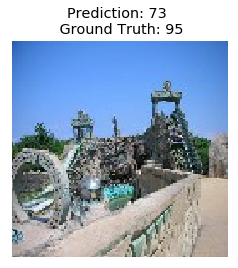

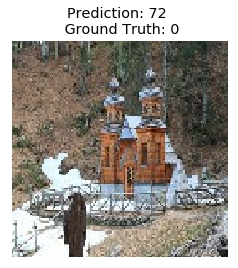

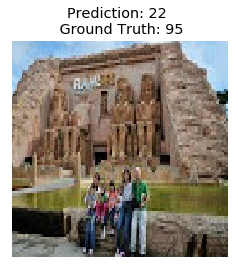

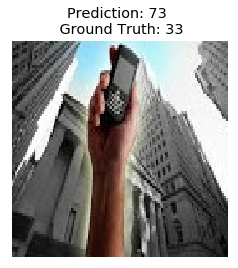

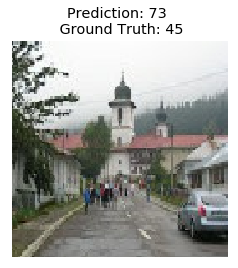

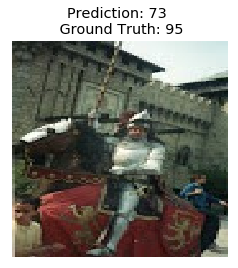

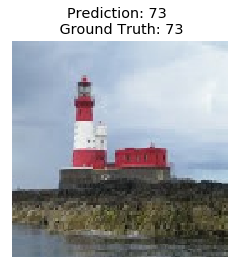

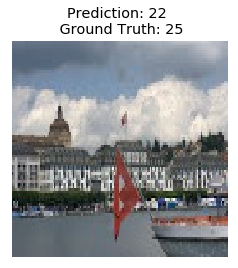

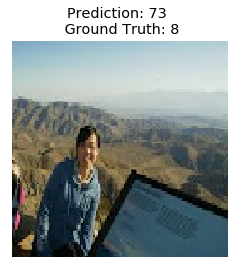

INFO:tensorflow:Model evaluation has completed! Visit TensorBoard for more information regarding your evaluation.


In [10]:
if __name__ == '__main__':
    eval_run()

In [ ]:
##################################################################
#Below is the Experiments with same code but different parameters#
##################################################################

In [52]:
import tensorflow as tf
from tensorflow.contrib.framework.python.ops.variables import get_or_create_global_step
from tensorflow.python.platform import tf_logging as logging
from preprocessing import inception_preprocessing
from nets.inception_resnet_v2 import inception_resnet_v2, inception_resnet_v2_arg_scope
import os
import time
slim = tf.contrib.slim

#================ DATASET INFORMATION ======================
#State dataset directory where the tfrecord files are located
dataset_dir = './landmark_recognition'

#State where your log file is at. If it doesn't exist, create it.
log_dir = './landmark_recognition/log'

#State where your checkpoint file is
checkpoint_file = './pretrained_models/inception_resnet_v2_2016_08_30.ckpt'

#State the image size you're resizing your images to. We will use the default inception size of 299.
image_size = 299

#State the number of classes to predict:
num_classes = 7

#State the labels file and read it
labels_file = './landmark_recognition/labels.txt'
labels = open(labels_file, 'r')

#Create a dictionary to refer each label to their string name
labels_to_name = {}
for line in labels:
    label, string_name = line.split(':')
    string_name = string_name[:-1] #Remove newline
    labels_to_name[int(label)] = string_name

#Create the file pattern of your TFRecord files so that it could be recognized later on
file_pattern = 'landmark_%s_*.tfrecord'

#Create a dictionary that will help people understand your dataset better. This is required by the Dataset class later.
items_to_descriptions = {
    'image': 'A 3-channel RGB coloured flower image that is either tulips, sunflowers, roses, dandelion, or daisy.',
    'label': 'A label that is as such -- 0:daisy, 1:dandelion, 2:roses, 3:sunflowers, 4:tulips'
}


#================= TRAINING INFORMATION ==================
#State the number of epochs to train
num_epochs = 6

#State your batch size
batch_size = 10

#Learning rate information and configuration (Up to you to experiment)
initial_learning_rate = 0.002
learning_rate_decay_factor = 0.7
num_epochs_before_decay = 2

def get_split(split_name, dataset_dir, file_pattern=file_pattern):
    """
    Obtains the split - training or validation - to create a Dataset class for feeding the examples into a queue later
    on. This function will set up the decoder and dataset information all into one Dataset class so that you can avoid
    the brute work later on.
    
    Your file_pattern is very important in locating the files later. 

    INPUTS:
        - split_name(str): 'train' or 'validation'. Used to get the correct data split of tfrecord files
        - dataset_dir(str): the dataset directory where the tfrecord files are located
        - file_pattern(str): the file name structure of the tfrecord files in order to get the correct data

    OUTPUTS:
    - dataset (Dataset): A Dataset class object where we can read its various components for easier batch creation.
    """
    #First check whether the split_name is train or validation
    if split_name not in ['train', 'validation']:
        raise ValueError(\
        'The split_name %s is not recognized. Please input either train or validation as the split_name'\
        % (split_name))

    #Create the full path for a general file_pattern to locate the tfrecord_files
    file_pattern_path = os.path.join(dataset_dir, file_pattern % (split_name))

    #Count the total number of examples in all of these shard
    num_samples = 0
    file_pattern_for_counting = 'landmark_' + split_name
    tfrecords_to_count = [os.path.join(dataset_dir, file) for file in os.listdir(dataset_dir)\
                         if file.startswith(file_pattern_for_counting)]
    for tfrecord_file in tfrecords_to_count:
        for record in tf.python_io.tf_record_iterator(tfrecord_file):
            num_samples += 1

    #Create a reader, which must be a TFRecord reader in this case
    reader = tf.TFRecordReader

    #Create the keys_to_features dictionary for the decoder
    keys_to_features = {
      'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
      'image/format': tf.FixedLenFeature((), tf.string, default_value='jpg'),
      'image/class/label': tf.FixedLenFeature(
          [], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
    }

    #Create the items_to_handlers dictionary for the decoder.
    items_to_handlers = {
    'image': slim.tfexample_decoder.Image(),
    'label': slim.tfexample_decoder.Tensor('image/class/label'),
    }

    #Start to create the decoder
    decoder = slim.tfexample_decoder.TFExampleDecoder(keys_to_features, items_to_handlers)

    #Create the labels_to_name file
    labels_to_name_dict = labels_to_name

    #Actually create the dataset
    dataset = slim.dataset.Dataset(
        data_sources = file_pattern_path,
        decoder = decoder,
        reader = reader,
        num_readers = 4,
        num_samples = num_samples,
        num_classes = num_classes,
        labels_to_name = labels_to_name_dict,
        items_to_descriptions = items_to_descriptions)

    return dataset

def load_batch(dataset, batch_size, height=image_size, width=image_size, is_training=True):
    '''
    Loads a batch for training.

    INPUTS:
    - dataset(Dataset): a Dataset class object that is created from the get_split function
    - batch_size(int): determines how big of a batch to train
    - height(int): the height of the image to resize to during preprocessing
    - width(int): the width of the image to resize to during preprocessing
    - is_training(bool): to determine whether to perform a training or evaluation preprocessing

    OUTPUTS:
    - images(Tensor): a Tensor of the shape (batch_size, height, width, channels) that contain one batch of images
    - labels(Tensor): the batch's labels with the shape (batch_size,) (requires one_hot_encoding).

    '''
    #First create the data_provider object
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset,
        common_queue_capacity = 24 + 3 * batch_size,
        common_queue_min = 24)

    #Obtain the raw image using the get method
    raw_image, label = data_provider.get(['image', 'label'])

    #Perform the correct preprocessing for this image depending if it is training or evaluating
    image = inception_preprocessing.preprocess_image(raw_image, height, width, is_training)

    #As for the raw images, we just do a simple reshape to batch it up
    raw_image = tf.expand_dims(raw_image, 0)
    raw_image = tf.image.resize_nearest_neighbor(raw_image, [height, width])
    raw_image = tf.squeeze(raw_image)

    #Batch up the image by enqueing the tensors internally in a FIFO queue and dequeueing many elements with tf.train.batch.
    images, raw_images, labels = tf.train.batch(
        [image, raw_image, label],
        batch_size = batch_size,
        num_threads = 4,
        capacity = 4 * batch_size,
        allow_smaller_final_batch = True)

    return images, raw_images, labels

def run():
    #Create the log directory here. Must be done here otherwise import will activate this unneededly.
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)

    #======================= TRAINING PROCESS =========================
    #Now we start to construct the graph and build our model
    with tf.Graph().as_default() as graph:
        tf.logging.set_verbosity(tf.logging.INFO) #Set the verbosity to INFO level

        #First create the dataset and load one batch
        dataset = get_split('train', dataset_dir, file_pattern=file_pattern)
        images, _, labels = load_batch(dataset, batch_size=batch_size)

        #Know the number steps to take before decaying the learning rate and batches per epoch
        num_batches_per_epoch = int(dataset.num_samples / batch_size)
        num_steps_per_epoch = num_batches_per_epoch #Because one step is one batch processed
        decay_steps = int(num_epochs_before_decay * num_steps_per_epoch)

        #Create the model inference
        with slim.arg_scope(inception_resnet_v2_arg_scope()):
            logits, end_points = inception_resnet_v2(images, num_classes = dataset.num_classes, is_training = True)

        #Define the scopes that you want to exclude for restoration
        exclude = ['InceptionResnetV2/Logits', 'InceptionResnetV2/AuxLogits']
        variables_to_restore = slim.get_variables_to_restore(exclude = exclude)

        #Perform one-hot-encoding of the labels (Try one-hot-encoding within the load_batch function!)
        one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)

        #Performs the equivalent to tf.nn.sparse_softmax_cross_entropy_with_logits but enhanced with checks
        loss = tf.losses.softmax_cross_entropy(onehot_labels = one_hot_labels, logits = logits)
        total_loss = tf.losses.get_total_loss()    #obtain the regularization losses as well

        #Create the global step for monitoring the learning_rate and training.
        global_step = get_or_create_global_step()

        #Define your exponentially decaying learning rate
        lr = tf.train.exponential_decay(
            learning_rate = initial_learning_rate,
            global_step = global_step,
            decay_steps = decay_steps,
            decay_rate = learning_rate_decay_factor,
            staircase = True)

        #Now we can define the optimizer that takes on the learning rate
        optimizer = tf.train.AdamOptimizer(learning_rate = lr)

        #Create the train_op.
        train_op = slim.learning.create_train_op(total_loss, optimizer)

        #State the metrics that you want to predict. We get a predictions that is not one_hot_encoded.
        predictions = tf.argmax(end_points['Predictions'], 1)
        probabilities = end_points['Predictions']
        accuracy, accuracy_update = tf.contrib.metrics.streaming_accuracy(predictions, labels)
        metrics_op = tf.group(accuracy_update, probabilities)


        #Now finally create all the summaries you need to monitor and group them into one summary op.
        tf.summary.scalar('losses/Total_Loss', total_loss)
        tf.summary.scalar('accuracy', accuracy)
        tf.summary.scalar('learning_rate', lr)
        my_summary_op = tf.summary.merge_all()

        #Now we need to create a training step function that runs both the train_op, metrics_op and updates the global_step concurrently.
        def train_step(sess, train_op, global_step):
            '''
            Simply runs a session for the three arguments provided and gives a logging on the time elapsed for each global step
            '''
            #Check the time for each sess run
            start_time = time.time()
            total_loss, global_step_count, _ = sess.run([train_op, global_step, metrics_op])
            time_elapsed = time.time() - start_time

            #Run the logging to print some results
            logging.info('global step %s: loss: %.4f (%.2f sec/step)', global_step_count, total_loss, time_elapsed)

            return total_loss, global_step_count

        #Now we create a saver function that actually restores the variables from a checkpoint file in a sess
        saver = tf.train.Saver(variables_to_restore)
        def restore_fn(sess):
            return saver.restore(sess, checkpoint_file)

        #Define your supervisor for running a managed session. Do not run the summary_op automatically or else it will consume too much memory
        sv = tf.train.Supervisor(logdir = log_dir, summary_op = None, init_fn = restore_fn)


        #Run the managed session
        with sv.managed_session() as sess:
            for step in range(num_steps_per_epoch * num_epochs):
                #At the start of every epoch, show the vital information:
                if step % num_batches_per_epoch == 0:
                    logging.info('Epoch %s/%s', step/num_batches_per_epoch + 1, num_epochs)
                    learning_rate_value, accuracy_value = sess.run([lr, accuracy])
                    logging.info('Current Learning Rate: %s', learning_rate_value)
                    logging.info('Current Streaming Accuracy: %s', accuracy_value)

                    # optionally, print your logits and predictions for a sanity check that things are going fine.
                    logits_value, probabilities_value, predictions_value, labels_value = sess.run([logits, probabilities, predictions, labels])
                    print('logits: \n', logits_value)
                    print('Probabilities: \n', probabilities_value)
                    print('predictions: \n', predictions_value)
                    print('Labels:\n:', labels_value)

                #Log the summaries every 10 step.
                if step % 10 == 0:
                    loss, _ = train_step(sess, train_op, sv.global_step)
                    summaries = sess.run(my_summary_op)
                    sv.summary_computed(sess, summaries)
                    
                #If not, simply run the training step
                else:
                    loss, _ = train_step(sess, train_op, sv.global_step)

            #We log the final training loss and accuracy
            logging.info('Final Loss: %s', loss)
            logging.info('Final Accuracy: %s', sess.run(accuracy))

            #Once all the training has been done, save the log files and checkpoint model
            logging.info('Finished training! Saving model to disk now.')
            # saver.save(sess, "./flowers_model.ckpt")
            sv.saver.save(sess, sv.save_path, global_step = sv.global_step)

if __name__ == '__main__':
    run()

INFO:tensorflow:Restoring parameters from ./pretrained_models/inception_resnet_v2_2016_08_30.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:Epoch 1.0/6
INFO:tensorflow:Current Learning Rate: 0.002
INFO:tensorflow:Current Streaming Accuracy: 0.0
logits: 
 [[-0.1157958   0.1586912   0.40843925  0.39932704 -0.28008687  0.46886122
  -0.54962844]
 [ 0.13168277 -0.16219765  0.63976961  0.91112471  0.4848991  -0.37652203
  -0.014737  ]
 [ 0.1208277  -0.43755242  0.22127181  1.00252819  0.09052257  0.25028282
   0.1858708 ]
 [-0.03324515 -0.23108059  0.34265959  0.7884838  -0.41465247  0.49064723
  -0.50618488]
 [-0.12784368 -0.22946174  0.57582819  0.23595673 -0.02132092  0.20087212
  -0.40854171]
 [-0.39605358 -0.15884337 -0.17255399  1.37562776 -0.05669905  0.70328277
  -0.

INFO:tensorflow:global step 91: loss: 1.4228 (32.82 sec/step)
INFO:tensorflow:global step 92: loss: 1.1023 (30.86 sec/step)
INFO:tensorflow:global step 93: loss: 1.7531 (29.74 sec/step)
INFO:tensorflow:global step 94: loss: 1.4826 (29.61 sec/step)
INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:global step 95: loss: 1.9835 (30.70 sec/step)
INFO:tensorflow:global step 96: loss: 1.3856 (32.98 sec/step)
INFO:tensorflow:global step 97: loss: 1.9626 (28.87 sec/step)
INFO:tensorflow:global step 98: loss: 1.9486 (29.16 sec/step)
INFO:tensorflow:global step 99: loss: 1.2770 (29.43 sec/step)
INFO:tensorflow:global step 100: loss: 1.8608 (29.71 sec/step)
INFO:tensorflow:global step 101: loss: 1.7215 (29.70 sec/step)
INFO:tensorflow:Epoch 2.0/6
INFO:tensorflow:Current Learning Rate: 0.002
INFO:tensorflow:Current Streaming Accuracy: 0.629703
logits: 
 [[ 4.50156164 -2.18250251 -0.37044856  3.73823476 -2.95725942  0.95387888
  -7.06353998]
 [-0.199186

INFO:tensorflow:global step 178: loss: 1.4765 (28.78 sec/step)
INFO:tensorflow:global step 179: loss: 1.1878 (29.07 sec/step)
INFO:tensorflow:global step 180: loss: 1.8607 (29.27 sec/step)
INFO:tensorflow:global step 181: loss: 1.0902 (29.70 sec/step)
INFO:tensorflow:global step 182: loss: 1.0957 (29.80 sec/step)
INFO:tensorflow:global step 183: loss: 1.4817 (29.57 sec/step)
INFO:tensorflow:global step 184: loss: 1.8883 (29.43 sec/step)
INFO:tensorflow:global step 185: loss: 1.5838 (29.67 sec/step)
INFO:tensorflow:global step 186: loss: 0.8894 (28.49 sec/step)
INFO:tensorflow:global step 187: loss: 1.1780 (28.70 sec/step)
INFO:tensorflow:global step 188: loss: 1.2982 (28.57 sec/step)
INFO:tensorflow:global step 189: loss: 1.4626 (28.65 sec/step)
INFO:tensorflow:global step 190: loss: 1.3341 (28.70 sec/step)
INFO:tensorflow:global step 191: loss: 1.6992 (28.83 sec/step)
INFO:tensorflow:global step 192: loss: 0.8855 (29.05 sec/step)
INFO:tensorflow:global step 193: loss: 1.3320 (29.22 se

INFO:tensorflow:global step 265: loss: 1.2008 (28.55 sec/step)
INFO:tensorflow:global step 266: loss: 1.0321 (28.65 sec/step)
INFO:tensorflow:global step 267: loss: 0.9711 (29.13 sec/step)
INFO:tensorflow:global step 268: loss: 1.2247 (28.80 sec/step)
INFO:tensorflow:global step 269: loss: 0.9740 (29.25 sec/step)
INFO:tensorflow:global step 270: loss: 0.7499 (29.34 sec/step)
INFO:tensorflow:global step 271: loss: 1.3063 (29.06 sec/step)
INFO:tensorflow:global step 272: loss: 0.9515 (29.45 sec/step)
INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:global step 273: loss: 0.9028 (30.03 sec/step)
INFO:tensorflow:global step 274: loss: 1.2550 (31.62 sec/step)
INFO:tensorflow:global step 275: loss: 1.0123 (28.47 sec/step)
INFO:tensorflow:global step 276: loss: 1.3066 (30.10 sec/step)
INFO:tensorflow:global step 277: loss: 1.0430 (36.86 sec/step)
INFO:tensorflow:global step 278: loss: 1.0186 (28.86 sec/step)
INFO:tensorflow:global step 279: loss:

INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:global step 352: loss: 0.8413 (31.65 sec/step)
INFO:tensorflow:global step 353: loss: 0.9547 (30.25 sec/step)
INFO:tensorflow:global step 354: loss: 0.7171 (29.06 sec/step)
INFO:tensorflow:global step 355: loss: 1.1520 (29.70 sec/step)
INFO:tensorflow:global step 356: loss: 1.3294 (30.13 sec/step)
INFO:tensorflow:global step 357: loss: 1.4671 (28.08 sec/step)
INFO:tensorflow:global step 358: loss: 0.9090 (28.15 sec/step)
INFO:tensorflow:global step 359: loss: 1.0079 (28.21 sec/step)
INFO:tensorflow:global step 360: loss: 0.9613 (28.18 sec/step)
INFO:tensorflow:global step 361: loss: 0.6320 (27.96 sec/step)
INFO:tensorflow:global step 362: loss: 0.6397 (28.08 sec/step)
INFO:tensorflow:global step 363: loss: 1.4954 (28.11 sec/step)
INFO:tensorflow:global step 364: loss: 0.8149 (28.05 sec/step)
INFO:tensorflow:global step 365: loss: 1.3865 (28.07 sec/step)
INFO:tensorflow:global step 366: loss:

INFO:tensorflow:global step 439: loss: 0.8164 (28.44 sec/step)
INFO:tensorflow:global step 440: loss: 0.6927 (28.38 sec/step)
INFO:tensorflow:global step 441: loss: 1.1053 (28.29 sec/step)
INFO:tensorflow:global step 442: loss: 0.8465 (28.51 sec/step)
INFO:tensorflow:global step 443: loss: 1.6931 (28.28 sec/step)
INFO:tensorflow:global step 444: loss: 1.2323 (28.40 sec/step)
INFO:tensorflow:global step 445: loss: 0.8757 (28.65 sec/step)
INFO:tensorflow:global step 446: loss: 0.9222 (33.70 sec/step)
INFO:tensorflow:global step 447: loss: 0.6116 (29.51 sec/step)
INFO:tensorflow:global step 448: loss: 0.6664 (29.92 sec/step)
INFO:tensorflow:global step 449: loss: 0.7076 (29.45 sec/step)
INFO:tensorflow:global step 450: loss: 0.7240 (29.64 sec/step)
INFO:tensorflow:global step 451: loss: 0.8777 (30.58 sec/step)
INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:global step 452: loss: 0.5884 (32.81 sec/step)
INFO:tensorflow:global step 453: loss:

INFO:tensorflow:global step 526: loss: 0.6107 (32.25 sec/step)
INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:global step 527: loss: 1.0810 (31.94 sec/step)
INFO:tensorflow:global step 528: loss: 0.5682 (35.90 sec/step)
INFO:tensorflow:global step 529: loss: 1.0252 (31.01 sec/step)
INFO:tensorflow:global step 530: loss: 0.7373 (30.57 sec/step)
INFO:tensorflow:global step 531: loss: 1.0593 (30.42 sec/step)
INFO:tensorflow:global step 532: loss: 1.1279 (31.26 sec/step)
INFO:tensorflow:global step 533: loss: 0.6807 (31.42 sec/step)
INFO:tensorflow:global step 534: loss: 0.6462 (31.78 sec/step)
INFO:tensorflow:global step 535: loss: 0.6121 (29.71 sec/step)
INFO:tensorflow:global step 536: loss: 0.7840 (29.69 sec/step)
INFO:tensorflow:global step 537: loss: 1.1301 (30.40 sec/step)
INFO:tensorflow:global step 538: loss: 0.9099 (32.86 sec/step)
INFO:tensorflow:global step 539: loss: 1.1079 (34.17 sec/step)
INFO:tensorflow:global step 540: loss:

In [ ]:
# Experiment3: Using different image size

In [53]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
slim = tf.contrib.slim

#State your log directory where you can retrieve your model
#log_dir = './log'

#Create a new evaluation log directory to visualize the validation process
log_eval = './landmark_recognition/log_eval_test'

#State the dataset directory where the validation set is found
dataset_dir = './landmark_recognition'

#State the batch_size to evaluate each time, which can be a lot more than the training batch
batch_size = 20

#State the number of epochs to evaluate
num_epochs = 6

#Get the latest checkpoint file
checkpoint_file = tf.train.latest_checkpoint(log_dir)

def eval_run():
    #Create log_dir for evaluation information
    if not os.path.exists(log_eval):
        os.mkdir(log_eval)

    #Just construct the graph from scratch again
    with tf.Graph().as_default() as graph:
        tf.logging.set_verbosity(tf.logging.INFO)
        #Get the dataset first and load one batch of validation images and labels tensors. Set is_training as False so as to use the evaluation preprocessing
        dataset = get_split('validation', dataset_dir)
        images, raw_images, labels = load_batch(dataset, batch_size = batch_size, is_training = False)

        #Create some information about the training steps
        num_batches_per_epoch = dataset.num_samples / batch_size
        num_steps_per_epoch = int(num_batches_per_epoch)

        #Now create the inference model but set is_training=False
        with slim.arg_scope(inception_resnet_v2_arg_scope()):
            logits, end_points = inception_resnet_v2(images, num_classes = dataset.num_classes, is_training = False)

        # #get all the variables to restore from the checkpoint file and create the saver function to restore
        variables_to_restore = slim.get_variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)
        def restore_fn(sess):
            return saver.restore(sess, checkpoint_file)

        #Just define the metrics to track without the loss or whatsoever
        predictions = tf.argmax(end_points['Predictions'], 1)
        accuracy, accuracy_update = tf.contrib.metrics.streaming_accuracy(predictions, labels)
        metrics_op = tf.group(accuracy_update)

        #Create the global step and an increment op for monitoring
        global_step = get_or_create_global_step()
        global_step_op = tf.assign(global_step, global_step + 1) #no apply_gradient method so manually increasing the global_step
        

        #Create a evaluation step function
        def eval_step(sess, metrics_op, global_step):
            '''
            Simply takes in a session, runs the metrics op and some logging information.
            '''
            start_time = time.time()
            _, global_step_count, accuracy_value = sess.run([metrics_op, global_step_op, accuracy])
            time_elapsed = time.time() - start_time

            #Log some information
            logging.info('Global Step %s: Streaming Accuracy: %.4f (%.2f sec/step)', global_step_count, accuracy_value, time_elapsed)

            return accuracy_value


        #Define some scalar quantities to monitor
        tf.summary.scalar('Validation_Accuracy', accuracy)
        my_summary_op = tf.summary.merge_all()

        #Get your supervisor
        sv = tf.train.Supervisor(logdir = log_eval, summary_op = None, saver = None, init_fn = restore_fn)

        #Now we are ready to run in one session
        with sv.managed_session() as sess:
            for step in range(num_steps_per_epoch * num_epochs):
                sess.run(sv.global_step)
                #print vital information every start of the epoch as always
                if step % num_batches_per_epoch == 0:
                    logging.info('Epoch: %s/%s', step / num_batches_per_epoch + 1, num_epochs)
                    logging.info('Current Streaming Accuracy: %.4f', sess.run(accuracy))
                    
                #Compute summaries every 10 steps and continue evaluating
                if step % 10 == 0:
                    eval_step(sess, metrics_op = metrics_op, global_step = sv.global_step)
                    summaries = sess.run(my_summary_op)
                    sv.summary_computed(sess, summaries)
                    

                #Otherwise just run as per normal
                else:
                    eval_step(sess, metrics_op = metrics_op, global_step = sv.global_step)

            #At the end of all the evaluation, show the final accuracy
            logging.info('Final Streaming Accuracy: %.4f', sess.run(accuracy))

            #Now we want to visualize the last batch's images just to see what our model has predicted
            labels, predictions = sess.run([labels, predictions])
            for i in range(50):
                label, prediction = labels[i], predictions[i]
                prediction_name, label_name = dataset.labels_to_name[prediction], dataset.labels_to_name[label]
                text = 'Prediction: %s \n Ground Truth: %s' %(prediction_name, label_name)
                #img_plot = plt.imshow(image)

                #Set up the plot and hide axes
                plt.title(text)
                #img_plot.axes.get_yaxis().set_ticks([])
                #img_plot.axes.get_xaxis().set_ticks([])
                plt.show()

            logging.info('Model evaluation has completed! Visit TensorBoard for more information regarding your evaluation.')

INFO:tensorflow:Restoring parameters from ./landmark_recognition/log/model.ckpt-606
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:Epoch: 1.0/6
INFO:tensorflow:Current Streaming Accuracy: 0.0000
INFO:tensorflow:Global Step 1: Streaming Accuracy: 0.0000 (22.87 sec/step)
INFO:tensorflow:Global Step 2: Streaming Accuracy: 0.1500 (17.01 sec/step)
INFO:tensorflow:Global Step 3: Streaming Accuracy: 0.1000 (17.58 sec/step)
INFO:tensorflow:Global Step 4: Streaming Accuracy: 0.1167 (17.58 sec/step)
INFO:tensorflow:Global Step 5: Streaming Accuracy: 0.1375 (18.45 sec/step)
INFO:tensorflow:Global Step 6: Streaming Accuracy: 0.1400 (18.12 sec/step)
INFO:tensorflow:Global Step 7: Streaming Accuracy: 0.1500 (17.52 sec/step)
INFO:tensorflow:Global Step 8: Streaming Accuracy: 0.1429 (17.94 sec/step)
INFO:tensorflow:Global Step 9: Streaming Accuracy: 0.1375 (17.81 sec/

INFO:tensorflow:Global Step 105: Streaming Accuracy: 0.1510 (18.55 sec/step)
INFO:tensorflow:Global Step 106: Streaming Accuracy: 0.1510 (16.74 sec/step)
INFO:tensorflow:Global Step 107: Streaming Accuracy: 0.1509 (16.96 sec/step)
INFO:tensorflow:Global Step 108: Streaming Accuracy: 0.1505 (16.92 sec/step)
INFO:tensorflow:Global Step 109: Streaming Accuracy: 0.1500 (16.74 sec/step)
INFO:tensorflow:Global Step 110: Streaming Accuracy: 0.1500 (17.22 sec/step)
INFO:tensorflow:Global Step 111: Streaming Accuracy: 0.1509 (16.85 sec/step)
INFO:tensorflow:Global Step 112: Streaming Accuracy: 0.1514 (17.02 sec/step)
INFO:tensorflow:Global Step 113: Streaming Accuracy: 0.1513 (16.69 sec/step)
INFO:tensorflow:Global Step 114: Streaming Accuracy: 0.1509 (16.88 sec/step)
INFO:tensorflow:Global Step 115: Streaming Accuracy: 0.1513 (16.68 sec/step)
INFO:tensorflow:Global Step 116: Streaming Accuracy: 0.1513 (16.82 sec/step)
INFO:tensorflow:Global Step 117: Streaming Accuracy: 0.1517 (17.10 sec/step)

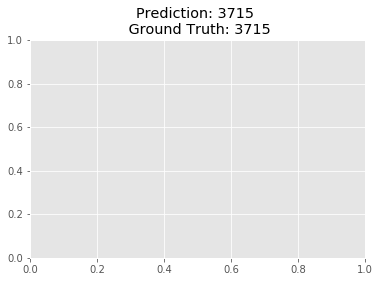

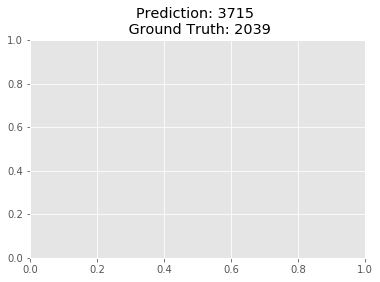

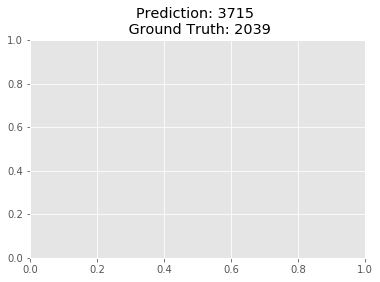

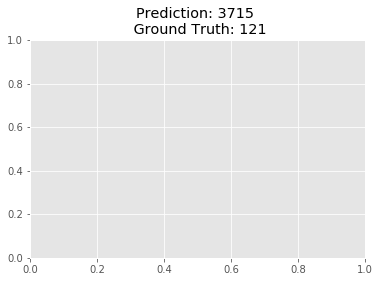

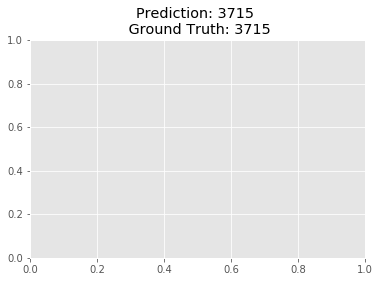

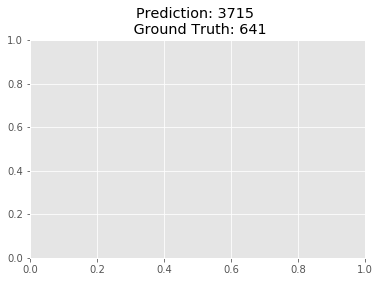

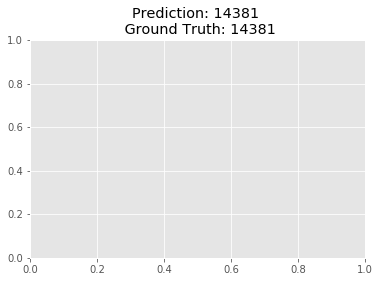

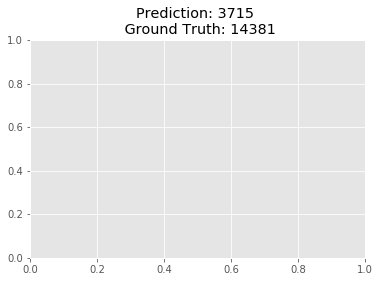

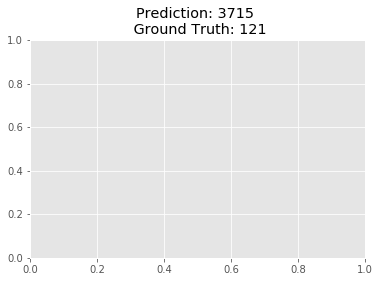

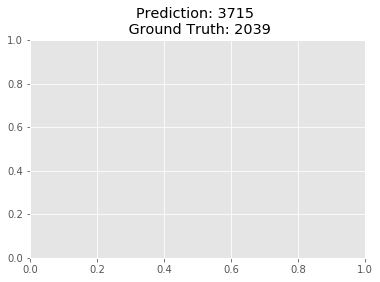

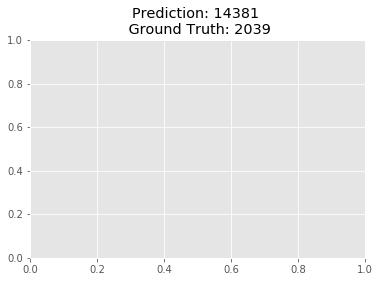

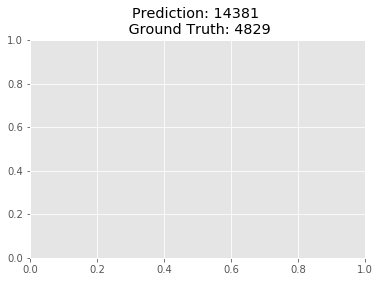

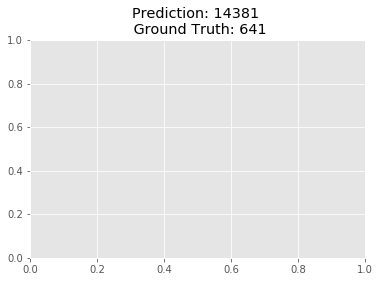

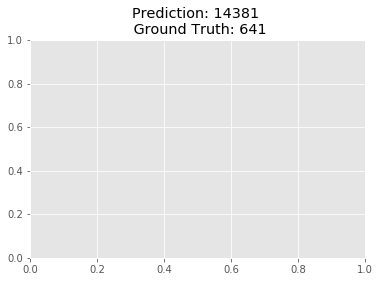

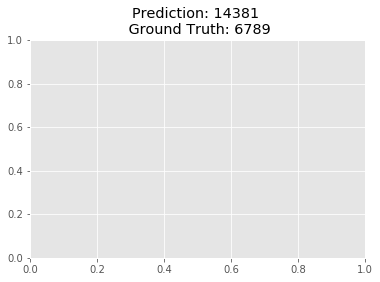

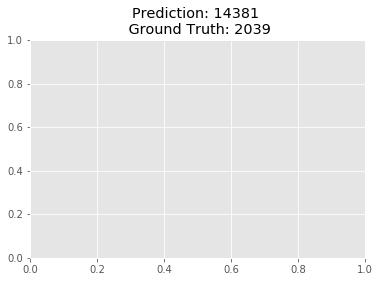

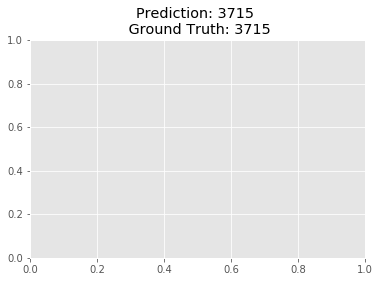

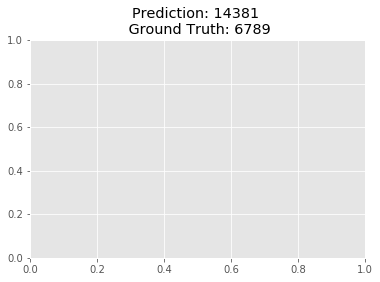

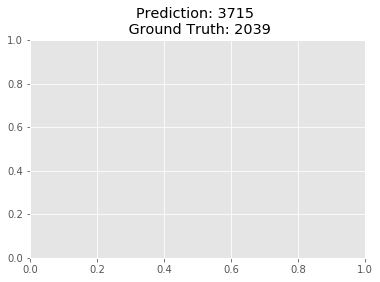

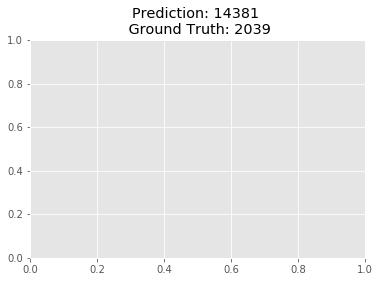

INFO:tensorflow:Error reported to Coordinator: <class 'IndexError'>, index 20 is out of bounds for axis 0 with size 20


IndexError: index 20 is out of bounds for axis 0 with size 20

In [54]:
if __name__ == '__main__':
    eval_run()

In [62]:
import tensorflow as tf
from tensorflow.contrib.framework.python.ops.variables import get_or_create_global_step
from tensorflow.python.platform import tf_logging as logging
from preprocessing import inception_preprocessing
from nets.inception_resnet_v2 import inception_resnet_v2, inception_resnet_v2_arg_scope
import os
import time
slim = tf.contrib.slim

#================ DATASET INFORMATION ======================
#State dataset directory where the tfrecord files are located
dataset_dir = './landmark_recognition'

#State where your log file is at. If it doesn't exist, create it.
log_dir = './landmark_recognition/log'

#State where your checkpoint file is
checkpoint_file = './pretrained_models/inception_resnet_v2_2016_08_30.ckpt'

#State the image size you're resizing your images to. We will use the default inception size of 299.
image_size = 128

#State the number of classes to predict:
num_classes = 7

#State the labels file and read it
labels_file = './landmark_recognition/labels.txt'
labels = open(labels_file, 'r')

#Create a dictionary to refer each label to their string name
labels_to_name = {}
for line in labels:
    label, string_name = line.split(':')
    string_name = string_name[:-1] #Remove newline
    labels_to_name[int(label)] = string_name

#Create the file pattern of your TFRecord files so that it could be recognized later on
file_pattern = 'landmark_%s_*.tfrecord'

#Create a dictionary that will help people understand your dataset better. This is required by the Dataset class later.
items_to_descriptions = {
    'image': 'A 3-channel RGB coloured flower image that is either tulips, sunflowers, roses, dandelion, or daisy.',
    'label': 'A label that is as such -- 0:daisy, 1:dandelion, 2:roses, 3:sunflowers, 4:tulips'
}


#================= TRAINING INFORMATION ==================
#State the number of epochs to train
num_epochs = 20

#State your batch size
batch_size = 10

#Learning rate information and configuration (Up to you to experiment)
initial_learning_rate = 0.0001
learning_rate_decay_factor = 0.7
num_epochs_before_decay = 2

def get_split(split_name, dataset_dir, file_pattern=file_pattern):
    """
    Obtains the split - training or validation - to create a Dataset class for feeding the examples into a queue later
    on. This function will set up the decoder and dataset information all into one Dataset class so that you can avoid
    the brute work later on.
    
    Your file_pattern is very important in locating the files later. 

    INPUTS:
        - split_name(str): 'train' or 'validation'. Used to get the correct data split of tfrecord files
        - dataset_dir(str): the dataset directory where the tfrecord files are located
        - file_pattern(str): the file name structure of the tfrecord files in order to get the correct data

    OUTPUTS:
    - dataset (Dataset): A Dataset class object where we can read its various components for easier batch creation.
    """
    #First check whether the split_name is train or validation
    if split_name not in ['train', 'validation']:
        raise ValueError(\
        'The split_name %s is not recognized. Please input either train or validation as the split_name'\
        % (split_name))

    #Create the full path for a general file_pattern to locate the tfrecord_files
    file_pattern_path = os.path.join(dataset_dir, file_pattern % (split_name))

    #Count the total number of examples in all of these shard
    num_samples = 0
    file_pattern_for_counting = 'landmark_' + split_name
    tfrecords_to_count = [os.path.join(dataset_dir, file) for file in os.listdir(dataset_dir)\
                         if file.startswith(file_pattern_for_counting)]
    for tfrecord_file in tfrecords_to_count:
        for record in tf.python_io.tf_record_iterator(tfrecord_file):
            num_samples += 1

    #Create a reader, which must be a TFRecord reader in this case
    reader = tf.TFRecordReader

    #Create the keys_to_features dictionary for the decoder
    keys_to_features = {
      'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
      'image/format': tf.FixedLenFeature((), tf.string, default_value='jpg'),
      'image/class/label': tf.FixedLenFeature(
          [], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
    }

    #Create the items_to_handlers dictionary for the decoder.
    items_to_handlers = {
    'image': slim.tfexample_decoder.Image(),
    'label': slim.tfexample_decoder.Tensor('image/class/label'),
    }

    #Start to create the decoder
    decoder = slim.tfexample_decoder.TFExampleDecoder(keys_to_features, items_to_handlers)

    #Create the labels_to_name file
    labels_to_name_dict = labels_to_name

    #Actually create the dataset
    dataset = slim.dataset.Dataset(
        data_sources = file_pattern_path,
        decoder = decoder,
        reader = reader,
        num_readers = 4,
        num_samples = num_samples,
        num_classes = num_classes,
        labels_to_name = labels_to_name_dict,
        items_to_descriptions = items_to_descriptions)

    return dataset

def load_batch(dataset, batch_size, height=image_size, width=image_size, is_training=True):
    '''
    Loads a batch for training.

    INPUTS:
    - dataset(Dataset): a Dataset class object that is created from the get_split function
    - batch_size(int): determines how big of a batch to train
    - height(int): the height of the image to resize to during preprocessing
    - width(int): the width of the image to resize to during preprocessing
    - is_training(bool): to determine whether to perform a training or evaluation preprocessing

    OUTPUTS:
    - images(Tensor): a Tensor of the shape (batch_size, height, width, channels) that contain one batch of images
    - labels(Tensor): the batch's labels with the shape (batch_size,) (requires one_hot_encoding).

    '''
    #First create the data_provider object
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset,
        common_queue_capacity = 24 + 3 * batch_size,
        common_queue_min = 24)

    #Obtain the raw image using the get method
    raw_image, label = data_provider.get(['image', 'label'])

    #Perform the correct preprocessing for this image depending if it is training or evaluating
    image = inception_preprocessing.preprocess_image(raw_image, height, width, is_training)

    #As for the raw images, we just do a simple reshape to batch it up
    raw_image = tf.expand_dims(raw_image, 0)
    raw_image = tf.image.resize_nearest_neighbor(raw_image, [height, width])
    raw_image = tf.squeeze(raw_image)

    #Batch up the image by enqueing the tensors internally in a FIFO queue and dequeueing many elements with tf.train.batch.
    images, raw_images, labels = tf.train.batch(
        [image, raw_image, label],
        batch_size = batch_size,
        num_threads = 4,
        capacity = 4 * batch_size,
        allow_smaller_final_batch = True)

    return images, raw_images, labels

def run():
    #Create the log directory here. Must be done here otherwise import will activate this unneededly.
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)

    #======================= TRAINING PROCESS =========================
    #Now we start to construct the graph and build our model
    with tf.Graph().as_default() as graph:
        tf.logging.set_verbosity(tf.logging.INFO) #Set the verbosity to INFO level

        #First create the dataset and load one batch
        dataset = get_split('train', dataset_dir, file_pattern=file_pattern)
        images, _, labels = load_batch(dataset, batch_size=batch_size)

        #Know the number steps to take before decaying the learning rate and batches per epoch
        num_batches_per_epoch = int(dataset.num_samples / batch_size)
        num_steps_per_epoch = num_batches_per_epoch #Because one step is one batch processed
        decay_steps = int(num_epochs_before_decay * num_steps_per_epoch)

        #Create the model inference
        with slim.arg_scope(inception_resnet_v2_arg_scope()):
            logits, end_points = inception_resnet_v2(images, num_classes = dataset.num_classes, is_training = True)

        #Define the scopes that you want to exclude for restoration
        exclude = ['InceptionResnetV2/Logits', 'InceptionResnetV2/AuxLogits']
        variables_to_restore = slim.get_variables_to_restore(exclude = exclude)

        #Perform one-hot-encoding of the labels (Try one-hot-encoding within the load_batch function!)
        one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)

        #Performs the equivalent to tf.nn.sparse_softmax_cross_entropy_with_logits but enhanced with checks
        loss = tf.losses.softmax_cross_entropy(onehot_labels = one_hot_labels, logits = logits)
        total_loss = tf.losses.get_total_loss()    #obtain the regularization losses as well

        #Create the global step for monitoring the learning_rate and training.
        global_step = get_or_create_global_step()

        #Define your exponentially decaying learning rate
        lr = tf.train.exponential_decay(
            learning_rate = initial_learning_rate,
            global_step = global_step,
            decay_steps = decay_steps,
            decay_rate = learning_rate_decay_factor,
            staircase = True)

        #Now we can define the optimizer that takes on the learning rate
        optimizer = tf.train.AdamOptimizer(learning_rate = lr)

        #Create the train_op.
        train_op = slim.learning.create_train_op(total_loss, optimizer)

        #State the metrics that you want to predict. We get a predictions that is not one_hot_encoded.
        predictions = tf.argmax(end_points['Predictions'], 1)
        probabilities = end_points['Predictions']
        accuracy, accuracy_update = tf.contrib.metrics.streaming_accuracy(predictions, labels)
        metrics_op = tf.group(accuracy_update, probabilities)


        #Now finally create all the summaries you need to monitor and group them into one summary op.
        tf.summary.scalar('losses/Total_Loss', total_loss)
        tf.summary.scalar('accuracy', accuracy)
        tf.summary.scalar('learning_rate', lr)
        my_summary_op = tf.summary.merge_all()

        #Now we need to create a training step function that runs both the train_op, metrics_op and updates the global_step concurrently.
        def train_step(sess, train_op, global_step):
            '''
            Simply runs a session for the three arguments provided and gives a logging on the time elapsed for each global step
            '''
            #Check the time for each sess run
            start_time = time.time()
            total_loss, global_step_count, _ = sess.run([train_op, global_step, metrics_op])
            time_elapsed = time.time() - start_time

            #Run the logging to print some results
            logging.info('global step %s: loss: %.4f (%.2f sec/step)', global_step_count, total_loss, time_elapsed)

            return total_loss, global_step_count

        #Now we create a saver function that actually restores the variables from a checkpoint file in a sess
        saver = tf.train.Saver(variables_to_restore)
        def restore_fn(sess):
            return saver.restore(sess, checkpoint_file)

        #Define your supervisor for running a managed session. Do not run the summary_op automatically or else it will consume too much memory
        sv = tf.train.Supervisor(logdir = log_dir, summary_op = None, init_fn = restore_fn)


        #Run the managed session
        with sv.managed_session() as sess:
            for step in range(num_steps_per_epoch * num_epochs):
                #At the start of every epoch, show the vital information:
                if step % num_batches_per_epoch == 0:
                    logging.info('Epoch %s/%s', step/num_batches_per_epoch + 1, num_epochs)
                    learning_rate_value, accuracy_value = sess.run([lr, accuracy])
                    logging.info('Current Learning Rate: %s', learning_rate_value)
                    logging.info('Current Streaming Accuracy: %s', accuracy_value)

                    # optionally, print your logits and predictions for a sanity check that things are going fine.
                    logits_value, probabilities_value, predictions_value, labels_value = sess.run([logits, probabilities, predictions, labels])
                    print('logits: \n', logits_value)
                    print('Probabilities: \n', probabilities_value)
                    print('predictions: \n', predictions_value)
                    print('Labels:\n:', labels_value)

                #Log the summaries every 10 step.
                if step % 10 == 0:
                    loss, _ = train_step(sess, train_op, sv.global_step)
                    summaries = sess.run(my_summary_op)
                    sv.summary_computed(sess, summaries)
                    
                #If not, simply run the training step
                else:
                    loss, _ = train_step(sess, train_op, sv.global_step)

            #We log the final training loss and accuracy
            logging.info('Final Loss: %s', loss)
            logging.info('Final Accuracy: %s', sess.run(accuracy))

            #Once all the training has been done, save the log files and checkpoint model
            logging.info('Finished training! Saving model to disk now.')
            # saver.save(sess, "./flowers_model.ckpt")
            sv.saver.save(sess, sv.save_path, global_step = sv.global_step)

if __name__ == '__main__':
    run()

INFO:tensorflow:Restoring parameters from ./pretrained_models/inception_resnet_v2_2016_08_30.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:Epoch 1.0/20
INFO:tensorflow:Current Learning Rate: 0.0002
INFO:tensorflow:Current Streaming Accuracy: 0.0
logits: 
 [[ 0.30946836  0.75341654 -0.37351221 -1.56846523  0.67950618  0.5379194
  -0.10461609]
 [ 0.0204615  -0.04401872  0.66925877 -1.95804095  0.44081068  0.19135541
   0.6545462 ]
 [ 0.88908648 -1.10917711 -0.036744   -0.67555994  0.37572932 -1.03429592
   0.56076407]
 [-0.4229151  -0.26877785 -0.39431816 -0.303743    0.30160621 -1.1500299
  -0.50618285]
 [ 0.2987543   0.29307199  0.28796116 -0.95586741  0.10796043 -0.47100613
  -0.03021608]
 [-0.70237875 -0.67230791  0.0906674  -0.30178207 -0.23435158 -0.38307849
   0.

INFO:tensorflow:global step 98: loss: 1.0263 (5.15 sec/step)
INFO:tensorflow:global step 99: loss: 0.9582 (4.99 sec/step)
INFO:tensorflow:global step 100: loss: 2.1108 (5.17 sec/step)
INFO:tensorflow:global step 101: loss: 0.8861 (4.94 sec/step)
INFO:tensorflow:Epoch 2.0/20
INFO:tensorflow:Current Learning Rate: 0.0002
INFO:tensorflow:Current Streaming Accuracy: 0.677228
logits: 
 [[ -1.51392490e-01  -1.65552258e+00  -2.78374100e+00  -2.62435722e+00
   -2.27215195e+00   9.02422714e+00  -2.01223135e-01]
 [ -3.99304219e-02   1.77328616e-01  -6.08905911e-01   1.95325124e+00
   -9.82975125e-01  -6.72123611e-01  -3.27401102e-01]
 [  9.90827382e-01  -4.83841747e-01   3.31082225e+00  -4.30050421e+00
    5.13761878e-01  -1.40962029e+00   1.82857394e+00]
 [  5.57636929e+00  -2.10754585e+00   1.60601175e+00  -6.56451702e-01
   -1.32560897e+00  -1.97391415e+00  -2.44572735e+00]
 [  5.83148623e+00  -1.98317432e+00  -1.40560520e+00  -1.28252065e+00
   -1.67873824e+00  -1.72535467e+00   1.28066633e-

INFO:tensorflow:global step 186: loss: 0.5819 (5.14 sec/step)
INFO:tensorflow:global step 187: loss: 1.0448 (4.94 sec/step)
INFO:tensorflow:global step 188: loss: 1.7240 (5.14 sec/step)
INFO:tensorflow:global step 189: loss: 1.2635 (5.01 sec/step)
INFO:tensorflow:global step 190: loss: 1.0956 (4.90 sec/step)
INFO:tensorflow:global step 191: loss: 1.4418 (4.90 sec/step)
INFO:tensorflow:global step 192: loss: 0.5843 (4.89 sec/step)
INFO:tensorflow:global step 193: loss: 0.8657 (4.95 sec/step)
INFO:tensorflow:global step 194: loss: 1.6942 (4.94 sec/step)
INFO:tensorflow:global step 195: loss: 0.6534 (4.89 sec/step)
INFO:tensorflow:global step 196: loss: 0.6119 (4.92 sec/step)
INFO:tensorflow:global step 197: loss: 0.6881 (4.99 sec/step)
INFO:tensorflow:global step 198: loss: 0.7053 (5.06 sec/step)
INFO:tensorflow:global step 199: loss: 0.8649 (4.91 sec/step)
INFO:tensorflow:global step 200: loss: 0.9835 (4.94 sec/step)
INFO:tensorflow:global step 201: loss: 0.6220 (4.91 sec/step)
INFO:ten

INFO:tensorflow:global step 278: loss: 1.2129 (5.12 sec/step)
INFO:tensorflow:global step 279: loss: 0.5681 (4.84 sec/step)
INFO:tensorflow:global step 280: loss: 0.8910 (4.98 sec/step)
INFO:tensorflow:global step 281: loss: 0.6783 (4.95 sec/step)
INFO:tensorflow:global step 282: loss: 1.0230 (4.79 sec/step)
INFO:tensorflow:global step 283: loss: 0.8270 (4.86 sec/step)
INFO:tensorflow:global step 284: loss: 0.7730 (5.07 sec/step)
INFO:tensorflow:global step 285: loss: 1.6086 (4.84 sec/step)
INFO:tensorflow:global step 286: loss: 0.6227 (4.81 sec/step)
INFO:tensorflow:global step 287: loss: 0.8765 (4.82 sec/step)
INFO:tensorflow:global step 288: loss: 0.8096 (4.82 sec/step)
INFO:tensorflow:global step 289: loss: 0.7438 (4.82 sec/step)
INFO:tensorflow:global step 290: loss: 0.6961 (5.01 sec/step)
INFO:tensorflow:global step 291: loss: 0.6892 (4.90 sec/step)
INFO:tensorflow:global step 292: loss: 0.6724 (4.79 sec/step)
INFO:tensorflow:global step 293: loss: 0.6057 (4.82 sec/step)
INFO:ten

INFO:tensorflow:global step 370: loss: 1.2865 (4.81 sec/step)
INFO:tensorflow:global step 371: loss: 0.7387 (4.84 sec/step)
INFO:tensorflow:global step 372: loss: 0.5333 (4.80 sec/step)
INFO:tensorflow:global step 373: loss: 0.7416 (5.04 sec/step)
INFO:tensorflow:global step 374: loss: 0.6267 (4.94 sec/step)
INFO:tensorflow:global step 375: loss: 0.5845 (4.93 sec/step)
INFO:tensorflow:global step 376: loss: 0.6491 (4.83 sec/step)
INFO:tensorflow:global step 377: loss: 0.5429 (4.83 sec/step)
INFO:tensorflow:global step 378: loss: 0.5448 (4.84 sec/step)
INFO:tensorflow:global step 379: loss: 0.5704 (5.09 sec/step)
INFO:tensorflow:global step 380: loss: 0.6588 (4.80 sec/step)
INFO:tensorflow:global step 381: loss: 0.6079 (4.84 sec/step)
INFO:tensorflow:global step 382: loss: 0.7045 (4.82 sec/step)
INFO:tensorflow:global step 383: loss: 0.5784 (4.84 sec/step)
INFO:tensorflow:global step 384: loss: 0.7645 (4.80 sec/step)
INFO:tensorflow:global step 385: loss: 0.9162 (4.98 sec/step)
INFO:ten

INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:global step 464: loss: 0.7390 (5.01 sec/step)
INFO:tensorflow:global step 465: loss: 0.6404 (7.33 sec/step)
INFO:tensorflow:global step 466: loss: 0.8757 (6.11 sec/step)
INFO:tensorflow:global step 467: loss: 0.5604 (5.14 sec/step)
INFO:tensorflow:global step 468: loss: 0.5795 (5.31 sec/step)
INFO:tensorflow:global step 469: loss: 0.7335 (4.83 sec/step)
INFO:tensorflow:global step 470: loss: 0.9753 (4.80 sec/step)
INFO:tensorflow:global step 471: loss: 0.5685 (4.82 sec/step)
INFO:tensorflow:global step 472: loss: 0.8326 (4.78 sec/step)
INFO:tensorflow:global step 473: loss: 0.9459 (4.80 sec/step)
INFO:tensorflow:global step 474: loss: 0.7312 (5.01 sec/step)
INFO:tensorflow:global step 475: loss: 0.5427 (4.82 sec/step)
INFO:tensorflow:global step 476: loss: 0.5853 (4.83 sec/step)
INFO:tensorflow:global step 477: loss: 1.0654 (4.81 sec/step)
INFO:tensorflow:global step 478: loss: 0.6374 (4.81 

INFO:tensorflow:global step 556: loss: 0.5284 (4.82 sec/step)
INFO:tensorflow:global step 557: loss: 0.5480 (4.81 sec/step)
INFO:tensorflow:global step 558: loss: 0.7088 (5.01 sec/step)
INFO:tensorflow:global step 559: loss: 0.6170 (4.86 sec/step)
INFO:tensorflow:global step 560: loss: 0.6411 (4.83 sec/step)
INFO:tensorflow:global step 561: loss: 0.7089 (4.82 sec/step)
INFO:tensorflow:global step 562: loss: 1.1062 (4.81 sec/step)
INFO:tensorflow:global step 563: loss: 0.5944 (4.83 sec/step)
INFO:tensorflow:global step 564: loss: 0.5462 (5.00 sec/step)
INFO:tensorflow:global step 565: loss: 0.7354 (4.88 sec/step)
INFO:tensorflow:global step 566: loss: 0.8566 (4.83 sec/step)
INFO:tensorflow:global step 567: loss: 0.5414 (4.80 sec/step)
INFO:tensorflow:global step 568: loss: 0.8194 (4.83 sec/step)
INFO:tensorflow:global step 569: loss: 0.5326 (4.84 sec/step)
INFO:tensorflow:global step 570: loss: 0.5488 (4.96 sec/step)
INFO:tensorflow:global step 571: loss: 0.5456 (4.81 sec/step)
INFO:ten

INFO:tensorflow:global step 648: loss: 1.0051 (4.82 sec/step)
INFO:tensorflow:global step 649: loss: 0.5380 (4.84 sec/step)
INFO:tensorflow:global step 650: loss: 0.5816 (4.80 sec/step)
INFO:tensorflow:global step 651: loss: 0.7507 (4.83 sec/step)
INFO:tensorflow:global step 652: loss: 0.6087 (4.79 sec/step)
INFO:tensorflow:global step 653: loss: 0.5277 (4.98 sec/step)
INFO:tensorflow:global step 654: loss: 0.6207 (4.81 sec/step)
INFO:tensorflow:global step 655: loss: 0.5395 (4.82 sec/step)
INFO:tensorflow:global step 656: loss: 1.3800 (4.81 sec/step)
INFO:tensorflow:global step 657: loss: 0.7231 (4.84 sec/step)
INFO:tensorflow:global step 658: loss: 0.5283 (4.83 sec/step)
INFO:tensorflow:global step 659: loss: 0.5810 (4.93 sec/step)
INFO:tensorflow:global step 660: loss: 0.7550 (4.98 sec/step)
INFO:tensorflow:global step 661: loss: 0.8389 (4.87 sec/step)
INFO:tensorflow:global step 662: loss: 0.5416 (4.78 sec/step)
INFO:tensorflow:global step 663: loss: 0.6293 (5.82 sec/step)
INFO:ten

INFO:tensorflow:global step 740: loss: 0.7757 (4.81 sec/step)
INFO:tensorflow:global step 741: loss: 0.5506 (4.82 sec/step)
INFO:tensorflow:global step 742: loss: 0.5411 (4.92 sec/step)
INFO:tensorflow:global step 743: loss: 0.6688 (4.84 sec/step)
INFO:tensorflow:global step 744: loss: 0.6428 (4.81 sec/step)
INFO:tensorflow:global step 745: loss: 0.9135 (4.86 sec/step)
INFO:tensorflow:global step 746: loss: 0.5828 (4.81 sec/step)
INFO:tensorflow:global step 747: loss: 0.6860 (4.80 sec/step)
INFO:tensorflow:global step 748: loss: 0.5859 (4.81 sec/step)
INFO:tensorflow:global step 749: loss: 1.1138 (5.04 sec/step)
INFO:tensorflow:global step 750: loss: 0.5493 (4.81 sec/step)
INFO:tensorflow:global step 751: loss: 0.5270 (4.85 sec/step)
INFO:tensorflow:global step 752: loss: 0.6208 (5.10 sec/step)
INFO:tensorflow:global step 753: loss: 0.6406 (4.81 sec/step)
INFO:tensorflow:global step 754: loss: 1.3821 (5.20 sec/step)
INFO:tensorflow:global step 755: loss: 0.5245 (4.84 sec/step)
INFO:ten

INFO:tensorflow:global step 833: loss: 0.6585 (4.82 sec/step)
INFO:tensorflow:global step 834: loss: 0.5522 (4.82 sec/step)
INFO:tensorflow:global step 835: loss: 0.5483 (4.81 sec/step)
INFO:tensorflow:global step 836: loss: 0.7149 (4.80 sec/step)
INFO:tensorflow:global step 837: loss: 0.6334 (4.83 sec/step)
INFO:tensorflow:global step 838: loss: 0.6239 (5.12 sec/step)
INFO:tensorflow:global step 839: loss: 0.7563 (4.89 sec/step)
INFO:tensorflow:global step 840: loss: 0.5493 (4.83 sec/step)
INFO:tensorflow:global step 841: loss: 0.8266 (4.79 sec/step)
INFO:tensorflow:global step 842: loss: 0.7829 (4.78 sec/step)
INFO:tensorflow:global step 843: loss: 0.5770 (4.79 sec/step)
INFO:tensorflow:global step 844: loss: 0.5796 (4.96 sec/step)
INFO:tensorflow:global step 845: loss: 0.5963 (4.83 sec/step)
INFO:tensorflow:global step 846: loss: 0.6192 (4.82 sec/step)
INFO:tensorflow:global step 847: loss: 0.6205 (4.79 sec/step)
INFO:tensorflow:global step 848: loss: 0.6063 (4.83 sec/step)
INFO:ten

INFO:tensorflow:global step 926: loss: 0.6686 (4.84 sec/step)
INFO:tensorflow:global step 927: loss: 0.7169 (4.82 sec/step)
INFO:tensorflow:global step 928: loss: 0.5375 (5.01 sec/step)
INFO:tensorflow:global step 929: loss: 0.5712 (4.83 sec/step)
INFO:tensorflow:global step 930: loss: 0.9666 (4.80 sec/step)
INFO:tensorflow:global step 931: loss: 0.6025 (4.78 sec/step)
INFO:tensorflow:global step 932: loss: 0.5326 (4.82 sec/step)
INFO:tensorflow:global step 933: loss: 0.7434 (4.78 sec/step)
INFO:tensorflow:global step 934: loss: 0.5737 (5.03 sec/step)
INFO:tensorflow:global step 935: loss: 0.5318 (4.84 sec/step)
INFO:tensorflow:global step 936: loss: 0.5314 (4.84 sec/step)
INFO:tensorflow:global step 937: loss: 0.5342 (4.81 sec/step)
INFO:tensorflow:global step 938: loss: 0.6158 (4.96 sec/step)
INFO:tensorflow:global step 939: loss: 0.5634 (4.86 sec/step)
INFO:tensorflow:global step 940: loss: 0.6468 (4.99 sec/step)
INFO:tensorflow:global step 941: loss: 0.5851 (4.81 sec/step)
INFO:ten

INFO:tensorflow:global step 1018: loss: 0.6056 (4.84 sec/step)
INFO:tensorflow:global step 1019: loss: 0.5279 (4.83 sec/step)
INFO:tensorflow:global step 1020: loss: 1.0251 (4.80 sec/step)
INFO:tensorflow:global step 1021: loss: 0.5371 (4.83 sec/step)
INFO:tensorflow:global step 1022: loss: 0.6090 (4.80 sec/step)
INFO:tensorflow:global step 1023: loss: 0.7787 (5.05 sec/step)
INFO:tensorflow:global step 1024: loss: 0.5282 (4.82 sec/step)
INFO:tensorflow:global step 1025: loss: 0.9319 (4.83 sec/step)
INFO:tensorflow:global step 1026: loss: 0.6279 (4.83 sec/step)
INFO:tensorflow:global step 1027: loss: 0.5673 (4.79 sec/step)
INFO:tensorflow:global step 1028: loss: 0.9068 (4.82 sec/step)
INFO:tensorflow:global step 1029: loss: 0.7255 (4.93 sec/step)
INFO:tensorflow:global step 1030: loss: 0.8348 (4.84 sec/step)
INFO:tensorflow:global step 1031: loss: 0.5236 (4.86 sec/step)
INFO:tensorflow:global step 1032: loss: 0.6944 (4.78 sec/step)
INFO:tensorflow:global step 1033: loss: 0.6606 (4.82 se

INFO:tensorflow:global step 1112: loss: 0.6137 (4.80 sec/step)
INFO:tensorflow:global step 1113: loss: 0.9492 (5.20 sec/step)
INFO:tensorflow:global step 1114: loss: 0.5408 (4.87 sec/step)
INFO:tensorflow:global step 1115: loss: 0.8206 (4.84 sec/step)
INFO:tensorflow:global step 1116: loss: 0.6557 (4.79 sec/step)
INFO:tensorflow:global step 1117: loss: 0.6464 (4.79 sec/step)
INFO:tensorflow:global step 1118: loss: 0.5779 (4.82 sec/step)
INFO:tensorflow:global step 1119: loss: 0.9215 (5.03 sec/step)
INFO:tensorflow:global step 1120: loss: 0.5258 (4.85 sec/step)
INFO:tensorflow:global step 1121: loss: 0.5279 (4.88 sec/step)
INFO:tensorflow:global step 1122: loss: 0.6135 (4.81 sec/step)
INFO:tensorflow:global step 1123: loss: 0.5421 (4.80 sec/step)
INFO:tensorflow:global step 1124: loss: 0.5256 (4.81 sec/step)
INFO:tensorflow:global step 1125: loss: 0.7324 (4.99 sec/step)
INFO:tensorflow:global step 1126: loss: 0.7019 (4.80 sec/step)
INFO:tensorflow:global step 1127: loss: 0.6264 (4.80 se

INFO:tensorflow:global step 1213: loss: 0.5408 (4.81 sec/step)
INFO:tensorflow:global step 1214: loss: 0.5294 (5.04 sec/step)
INFO:tensorflow:global step 1215: loss: 0.7335 (4.85 sec/step)
INFO:tensorflow:global step 1216: loss: 0.5258 (4.81 sec/step)
INFO:tensorflow:global step 1217: loss: 0.5234 (4.77 sec/step)
INFO:tensorflow:global step 1218: loss: 0.5336 (4.81 sec/step)
INFO:tensorflow:global step 1219: loss: 0.5649 (4.83 sec/step)
INFO:tensorflow:global step 1220: loss: 0.5752 (4.92 sec/step)
INFO:tensorflow:global step 1221: loss: 0.6721 (4.98 sec/step)
INFO:tensorflow:global step 1222: loss: 0.6542 (4.86 sec/step)
INFO:tensorflow:global step 1223: loss: 0.5955 (4.82 sec/step)
INFO:tensorflow:global step 1224: loss: 0.8384 (4.80 sec/step)
INFO:tensorflow:global step 1225: loss: 0.5556 (4.82 sec/step)
INFO:tensorflow:global step 1226: loss: 0.5236 (4.98 sec/step)
INFO:tensorflow:global step 1227: loss: 0.5231 (4.82 sec/step)
INFO:tensorflow:global step 1228: loss: 0.5452 (4.89 se

INFO:tensorflow:global step 1314: loss: 0.5276 (4.81 sec/step)
INFO:tensorflow:global step 1315: loss: 0.6030 (4.81 sec/step)
INFO:tensorflow:global step 1316: loss: 0.6433 (5.02 sec/step)
INFO:tensorflow:global step 1317: loss: 0.6648 (4.83 sec/step)
INFO:tensorflow:global step 1318: loss: 0.5772 (4.80 sec/step)
INFO:tensorflow:global step 1319: loss: 0.6725 (4.80 sec/step)
INFO:tensorflow:global step 1320: loss: 0.5311 (4.83 sec/step)
INFO:tensorflow:global step 1321: loss: 0.6369 (4.82 sec/step)
INFO:tensorflow:global step 1322: loss: 0.5682 (4.97 sec/step)
INFO:tensorflow:global step 1323: loss: 0.7927 (4.93 sec/step)
INFO:tensorflow:global step 1324: loss: 0.5914 (4.82 sec/step)
INFO:tensorflow:global step 1325: loss: 0.6179 (4.81 sec/step)
INFO:tensorflow:global step 1326: loss: 0.5387 (4.81 sec/step)
INFO:tensorflow:global step 1327: loss: 0.8132 (4.80 sec/step)
INFO:tensorflow:global step 1328: loss: 0.9482 (4.97 sec/step)
INFO:tensorflow:global step 1329: loss: 0.5974 (4.83 se

INFO:tensorflow:global step 1415: loss: 0.5331 (4.83 sec/step)
INFO:tensorflow:global step 1416: loss: 0.7496 (4.80 sec/step)
INFO:tensorflow:global step 1417: loss: 0.6059 (4.78 sec/step)
INFO:tensorflow:global step 1418: loss: 0.5620 (4.99 sec/step)
INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:global step 1419: loss: 0.5648 (4.96 sec/step)
INFO:tensorflow:global step 1420: loss: 0.5917 (5.91 sec/step)
INFO:tensorflow:global step 1421: loss: 0.5407 (5.99 sec/step)
INFO:tensorflow:global step 1422: loss: 0.6245 (4.78 sec/step)
INFO:tensorflow:global step 1423: loss: 0.7257 (5.14 sec/step)
INFO:tensorflow:global step 1424: loss: 0.5248 (4.87 sec/step)
INFO:tensorflow:global step 1425: loss: 0.5272 (4.81 sec/step)
INFO:tensorflow:global step 1426: loss: 0.5401 (4.85 sec/step)
INFO:tensorflow:global step 1427: loss: 0.9657 (4.85 sec/step)
INFO:tensorflow:global step 1428: loss: 0.6147 (4.82 sec/step)
INFO:tensorflow:global step 1429: loss

INFO:tensorflow:global step 1516: loss: 0.5599 (4.90 sec/step)
INFO:tensorflow:global step 1517: loss: 0.5457 (4.82 sec/step)
INFO:tensorflow:global step 1518: loss: 0.5499 (4.82 sec/step)
INFO:tensorflow:global step 1519: loss: 0.5394 (5.03 sec/step)
INFO:tensorflow:global step 1520: loss: 0.5375 (4.85 sec/step)
INFO:tensorflow:global step 1521: loss: 0.5260 (4.83 sec/step)
INFO:tensorflow:global step 1522: loss: 0.5256 (4.83 sec/step)
INFO:tensorflow:global step 1523: loss: 0.5301 (4.84 sec/step)
INFO:tensorflow:global step 1524: loss: 0.5421 (4.81 sec/step)
INFO:tensorflow:global step 1525: loss: 0.5255 (5.01 sec/step)
INFO:tensorflow:global step 1526: loss: 0.5793 (4.82 sec/step)
INFO:tensorflow:global step 1527: loss: 0.5217 (4.81 sec/step)
INFO:tensorflow:global step 1528: loss: 0.5372 (4.85 sec/step)
INFO:tensorflow:global step 1529: loss: 0.6595 (4.82 sec/step)
INFO:tensorflow:global step 1530: loss: 0.7643 (4.84 sec/step)
INFO:tensorflow:global step 1531: loss: 0.5233 (5.02 se

INFO:tensorflow:global step 1617: loss: 0.5525 (4.80 sec/step)
INFO:tensorflow:global step 1618: loss: 0.5566 (4.81 sec/step)
INFO:tensorflow:global step 1619: loss: 1.1176 (4.80 sec/step)
INFO:tensorflow:global step 1620: loss: 0.7120 (4.90 sec/step)
INFO:tensorflow:global step 1621: loss: 0.5711 (4.99 sec/step)
INFO:tensorflow:global step 1622: loss: 0.9869 (4.79 sec/step)
INFO:tensorflow:global step 1623: loss: 0.5347 (4.81 sec/step)
INFO:tensorflow:global step 1624: loss: 0.7968 (4.83 sec/step)
INFO:tensorflow:global step 1625: loss: 0.5226 (4.82 sec/step)
INFO:tensorflow:global step 1626: loss: 0.5710 (4.97 sec/step)
INFO:tensorflow:global step 1627: loss: 0.5314 (4.82 sec/step)
INFO:tensorflow:global step 1628: loss: 0.5883 (4.86 sec/step)
INFO:tensorflow:global step 1629: loss: 0.6227 (4.79 sec/step)
INFO:tensorflow:global step 1630: loss: 0.6519 (4.81 sec/step)
INFO:tensorflow:global step 1631: loss: 1.2061 (4.79 sec/step)
INFO:tensorflow:global step 1632: loss: 0.5470 (4.95 se

INFO:tensorflow:global step 1718: loss: 0.5469 (4.81 sec/step)
INFO:tensorflow:global step 1719: loss: 0.5245 (4.82 sec/step)
INFO:tensorflow:global step 1720: loss: 0.5264 (4.83 sec/step)
INFO:tensorflow:global step 1721: loss: 0.6684 (4.81 sec/step)
INFO:tensorflow:global step 1722: loss: 0.6181 (4.96 sec/step)
INFO:tensorflow:global step 1723: loss: 0.6322 (4.86 sec/step)
INFO:tensorflow:global step 1724: loss: 0.5256 (4.84 sec/step)
INFO:tensorflow:global step 1725: loss: 0.6358 (4.82 sec/step)
INFO:tensorflow:global step 1726: loss: 0.7185 (4.80 sec/step)
INFO:tensorflow:global step 1727: loss: 0.5893 (4.83 sec/step)
INFO:tensorflow:global step 1728: loss: 0.7261 (4.98 sec/step)
INFO:tensorflow:global step 1729: loss: 0.7736 (4.83 sec/step)
INFO:tensorflow:global step 1730: loss: 0.5284 (4.83 sec/step)
INFO:tensorflow:global step 1731: loss: 0.5250 (4.81 sec/step)
INFO:tensorflow:global step 1732: loss: 0.5358 (4.83 sec/step)
INFO:tensorflow:global step 1733: loss: 0.5233 (4.82 se

INFO:tensorflow:global step 1819: loss: 0.8230 (4.87 sec/step)
INFO:tensorflow:global step 1820: loss: 0.7849 (4.83 sec/step)
INFO:tensorflow:global step 1821: loss: 0.5276 (4.83 sec/step)
INFO:tensorflow:global step 1822: loss: 0.6176 (4.80 sec/step)
INFO:tensorflow:global step 1823: loss: 0.5331 (4.99 sec/step)
INFO:tensorflow:global step 1824: loss: 0.5233 (4.81 sec/step)
INFO:tensorflow:global step 1825: loss: 0.5277 (4.83 sec/step)
INFO:tensorflow:global step 1826: loss: 0.7202 (4.82 sec/step)
INFO:tensorflow:global step 1827: loss: 0.7737 (4.81 sec/step)
INFO:tensorflow:global step 1828: loss: 0.5366 (4.81 sec/step)
INFO:tensorflow:global step 1829: loss: 0.6639 (4.84 sec/step)
INFO:tensorflow:global step 1830: loss: 0.5300 (4.97 sec/step)
INFO:tensorflow:global step 1831: loss: 0.7003 (4.83 sec/step)
INFO:tensorflow:global step 1832: loss: 0.5303 (4.79 sec/step)
INFO:tensorflow:global step 1833: loss: 0.6148 (4.80 sec/step)
INFO:tensorflow:global step 1834: loss: 0.5367 (4.80 se

INFO:tensorflow:global step 1920: loss: 0.5509 (4.82 sec/step)
INFO:tensorflow:global step 1921: loss: 0.7522 (4.80 sec/step)
INFO:tensorflow:global step 1922: loss: 0.6125 (4.78 sec/step)
INFO:tensorflow:global step 1923: loss: 0.8702 (4.83 sec/step)
INFO:tensorflow:global step 1924: loss: 0.5320 (4.86 sec/step)
INFO:tensorflow:global step 1925: loss: 0.6362 (5.01 sec/step)
INFO:tensorflow:global step 1926: loss: 0.5580 (4.83 sec/step)
INFO:tensorflow:global step 1927: loss: 0.9208 (4.84 sec/step)
INFO:tensorflow:global step 1928: loss: 0.5236 (4.81 sec/step)
INFO:tensorflow:global step 1929: loss: 0.5338 (4.85 sec/step)
INFO:tensorflow:global step 1930: loss: 0.5273 (4.82 sec/step)
INFO:tensorflow:global step 1931: loss: 0.6399 (4.99 sec/step)
INFO:tensorflow:global step 1932: loss: 0.5966 (4.81 sec/step)
INFO:tensorflow:global step 1933: loss: 0.5235 (4.78 sec/step)
INFO:tensorflow:global step 1934: loss: 0.5260 (4.84 sec/step)
INFO:tensorflow:global step 1935: loss: 0.5223 (4.81 se

In [67]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
slim = tf.contrib.slim

#State your log directory where you can retrieve your model
#log_dir = './log'

#Create a new evaluation log directory to visualize the validation process
log_eval = './landmark_recognition/log_eval_test'

#State the dataset directory where the validation set is found
dataset_dir = './landmark_recognition'

#State the batch_size to evaluate each time, which can be a lot more than the training batch
batch_size = 20

#State the number of epochs to evaluate
num_epochs = 20

#Get the latest checkpoint file
checkpoint_file = tf.train.latest_checkpoint(log_dir)

In [72]:
def eval_run():
    #Create log_dir for evaluation information
    if not os.path.exists(log_eval):
        os.mkdir(log_eval)

    #Just construct the graph from scratch again
    with tf.Graph().as_default() as graph:
        tf.logging.set_verbosity(tf.logging.INFO)
        #Get the dataset first and load one batch of validation images and labels tensors. Set is_training as False so as to use the evaluation preprocessing
        dataset = get_split('validation', dataset_dir)
        images, raw_images, labels = load_batch(dataset, batch_size = batch_size, is_training = False)

        #Create some information about the training steps
        num_batches_per_epoch = dataset.num_samples / batch_size
        num_steps_per_epoch = int(num_batches_per_epoch)

        #Now create the inference model but set is_training=False
        with slim.arg_scope(inception_resnet_v2_arg_scope()):
            logits, end_points = inception_resnet_v2(images, num_classes = dataset.num_classes, is_training = False)

        # #get all the variables to restore from the checkpoint file and create the saver function to restore
        variables_to_restore = slim.get_variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)
        def restore_fn(sess):
            return saver.restore(sess, checkpoint_file)

        #Just define the metrics to track without the loss or whatsoever
        predictions = tf.argmax(end_points['Predictions'], 1)
        accuracy, accuracy_update = tf.contrib.metrics.streaming_accuracy(predictions, labels)
        metrics_op = tf.group(accuracy_update)

        #Create the global step and an increment op for monitoring
        global_step = get_or_create_global_step()
        global_step_op = tf.assign(global_step, global_step + 1) #no apply_gradient method so manually increasing the global_step
        

        #Create a evaluation step function
        def eval_step(sess, metrics_op, global_step):
            '''
            Simply takes in a session, runs the metrics op and some logging information.
            '''
            start_time = time.time()
            _, global_step_count, accuracy_value = sess.run([metrics_op, global_step_op, accuracy])
            time_elapsed = time.time() - start_time

            #Log some information
            logging.info('Global Step %s: Streaming Accuracy: %.4f (%.2f sec/step)', global_step_count, accuracy_value, time_elapsed)

            return accuracy_value


        #Define some scalar quantities to monitor
        tf.summary.scalar('Validation_Accuracy', accuracy)
        my_summary_op = tf.summary.merge_all()

        #Get your supervisor
        sv = tf.train.Supervisor(logdir = log_eval, summary_op = None, saver = None, init_fn = restore_fn)

        #Now we are ready to run in one session
        with sv.managed_session() as sess:
            for step in range(num_steps_per_epoch * num_epochs):
                sess.run(sv.global_step)
                #print vital information every start of the epoch as always
                if step % num_batches_per_epoch == 0:
                    logging.info('Epoch: %s/%s', step / num_batches_per_epoch + 1, num_epochs)
                    logging.info('Current Streaming Accuracy: %.4f', sess.run(accuracy))
                    
                #Compute summaries every 10 steps and continue evaluating
                if step % 10 == 0:
                    eval_step(sess, metrics_op = metrics_op, global_step = sv.global_step)
                    summaries = sess.run(my_summary_op)
                    sv.summary_computed(sess, summaries)
                    

                #Otherwise just run as per normal
                else:
                    eval_step(sess, metrics_op = metrics_op, global_step = sv.global_step)

            #At the end of all the evaluation, show the final accuracy
            logging.info('Final Streaming Accuracy: %.4f', sess.run(accuracy))

            #Now we want to visualize the last batch's images just to see what our model has predicted
            raw_images, labels, predictions = sess.run([raw_images, labels, predictions])
            for i in range(5):
                image, label, prediction = raw_images[i], labels[i], predictions[i]
                prediction_name, label_name = dataset.labels_to_name[prediction], dataset.labels_to_name[label]
                text = 'Prediction: %s \n Ground Truth: %s' %(prediction_name, label_name)
                img_plot = plt.imshow(image)

                #Set up the plot and hide axes
                plt.title(text)
                img_plot.axes.get_yaxis().set_ticks([])
                img_plot.axes.get_xaxis().set_ticks([])
                plt.show()

            logging.info('Model evaluation has completed! Visit TensorBoard for more information regarding your evaluation.')

In [50]:
image_size = 299
def load_batch(dataset, batch_size, height=image_size, width=image_size, is_training=True):
    '''
    Loads a batch for training.

    INPUTS:
    - dataset(Dataset): a Dataset class object that is created from the get_split function
    - batch_size(int): determines how big of a batch to train
    - height(int): the height of the image to resize to during preprocessing
    - width(int): the width of the image to resize to during preprocessing
    - is_training(bool): to determine whether to perform a training or evaluation preprocessing

    OUTPUTS:
    - images(Tensor): a Tensor of the shape (batch_size, height, width, channels) that contain one batch of images
    - labels(Tensor): the batch's labels with the shape (batch_size,) (requires one_hot_encoding).

    '''
    #First create the data_provider object
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset,
        common_queue_capacity = 24 + 3 * batch_size,
        common_queue_min = 24)

    #Obtain the raw image using the get method
    raw_image, label = data_provider.get(['image', 'label'])

    #Perform the correct preprocessing for this image depending if it is training or evaluating
    image = inception_preprocessing.preprocess_image(raw_image, height, width, is_training)

    #As for the raw images, we just do a simple reshape to batch it up
    raw_image = tf.expand_dims(raw_image, 0)
    raw_image = tf.image.resize_nearest_neighbor(raw_image, [height, width])
    raw_image = tf.squeeze(raw_image)

    #Batch up the image by enqueing the tensors internally in a FIFO queue and dequeueing many elements with tf.train.batch.
    images, raw_images, labels = tf.train.batch(
        [image, raw_image, label],
        batch_size = batch_size,
        num_threads = 4,
        capacity = 4 * batch_size,
        allow_smaller_final_batch = True)

    return images, raw_images, labels

INFO:tensorflow:Restoring parameters from ./landmark_recognition/log/model.ckpt-2020
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:Epoch: 1.0/20
INFO:tensorflow:Current Streaming Accuracy: 0.0000
INFO:tensorflow:Global Step 1: Streaming Accuracy: 0.0000 (3.28 sec/step)
INFO:tensorflow:Global Step 2: Streaming Accuracy: 1.0000 (2.26 sec/step)
INFO:tensorflow:Global Step 3: Streaming Accuracy: 0.9750 (2.21 sec/step)
INFO:tensorflow:Global Step 4: Streaming Accuracy: 0.9833 (2.19 sec/step)
INFO:tensorflow:Global Step 5: Streaming Accuracy: 0.9875 (2.21 sec/step)
INFO:tensorflow:Global Step 6: Streaming Accuracy: 0.9900 (2.18 sec/step)
INFO:tensorflow:Global Step 7: Streaming Accuracy: 0.9833 (2.20 sec/step)
INFO:tensorflow:Global Step 8: Streaming Accuracy: 0.9857 (2.19 sec/step)
INFO:tensorflow:Global Step 9: Streaming Accuracy: 0.9812 (2.18 sec/step)
I

INFO:tensorflow:Global Step 106: Streaming Accuracy: 0.9776 (2.18 sec/step)
INFO:tensorflow:Global Step 107: Streaming Accuracy: 0.9778 (2.22 sec/step)
INFO:tensorflow:Global Step 108: Streaming Accuracy: 0.9776 (2.21 sec/step)
INFO:tensorflow:Global Step 109: Streaming Accuracy: 0.9778 (2.22 sec/step)
INFO:tensorflow:Global Step 110: Streaming Accuracy: 0.9775 (2.23 sec/step)
INFO:tensorflow:Global Step 111: Streaming Accuracy: 0.9777 (2.18 sec/step)
INFO:tensorflow:Global Step 112: Streaming Accuracy: 0.9779 (2.22 sec/step)
INFO:tensorflow:Global Step 113: Streaming Accuracy: 0.9781 (2.21 sec/step)
INFO:tensorflow:Global Step 114: Streaming Accuracy: 0.9779 (2.21 sec/step)
INFO:tensorflow:Global Step 115: Streaming Accuracy: 0.9768 (2.18 sec/step)
INFO:tensorflow:Global Step 116: Streaming Accuracy: 0.9765 (2.21 sec/step)
INFO:tensorflow:Global Step 117: Streaming Accuracy: 0.9767 (2.21 sec/step)
INFO:tensorflow:Global Step 118: Streaming Accuracy: 0.9765 (2.37 sec/step)
INFO:tensorf

INFO:tensorflow:Global Step 214: Streaming Accuracy: 0.9775 (2.18 sec/step)
INFO:tensorflow:Global Step 215: Streaming Accuracy: 0.9776 (2.22 sec/step)
INFO:tensorflow:Global Step 216: Streaming Accuracy: 0.9777 (2.21 sec/step)
INFO:tensorflow:Global Step 217: Streaming Accuracy: 0.9778 (2.23 sec/step)
INFO:tensorflow:Global Step 218: Streaming Accuracy: 0.9774 (2.17 sec/step)
INFO:tensorflow:Global Step 219: Streaming Accuracy: 0.9775 (2.20 sec/step)
INFO:tensorflow:Global Step 220: Streaming Accuracy: 0.9776 (2.18 sec/step)
INFO:tensorflow:Global Step 221: Streaming Accuracy: 0.9775 (2.19 sec/step)
INFO:tensorflow:Global Step 222: Streaming Accuracy: 0.9776 (2.21 sec/step)
INFO:tensorflow:Global Step 223: Streaming Accuracy: 0.9775 (2.19 sec/step)
INFO:tensorflow:Global Step 224: Streaming Accuracy: 0.9771 (2.20 sec/step)
INFO:tensorflow:Global Step 225: Streaming Accuracy: 0.9768 (2.38 sec/step)
INFO:tensorflow:Global Step 226: Streaming Accuracy: 0.9769 (2.23 sec/step)
INFO:tensorf

INFO:tensorflow:Global Step 322: Streaming Accuracy: 0.9773 (2.20 sec/step)
INFO:tensorflow:Global Step 323: Streaming Accuracy: 0.9772 (2.18 sec/step)
INFO:tensorflow:Global Step 324: Streaming Accuracy: 0.9771 (2.17 sec/step)
INFO:tensorflow:Global Step 325: Streaming Accuracy: 0.9770 (2.20 sec/step)
INFO:tensorflow:Global Step 326: Streaming Accuracy: 0.9771 (2.21 sec/step)
INFO:tensorflow:Global Step 327: Streaming Accuracy: 0.9771 (2.20 sec/step)
INFO:tensorflow:Global Step 328: Streaming Accuracy: 0.9772 (2.19 sec/step)
INFO:tensorflow:Global Step 329: Streaming Accuracy: 0.9773 (2.21 sec/step)
INFO:tensorflow:Global Step 330: Streaming Accuracy: 0.9772 (2.20 sec/step)
INFO:tensorflow:Global Step 331: Streaming Accuracy: 0.9773 (2.20 sec/step)
INFO:tensorflow:Global Step 332: Streaming Accuracy: 0.9772 (2.24 sec/step)
INFO:tensorflow:Global Step 333: Streaming Accuracy: 0.9773 (2.48 sec/step)
INFO:tensorflow:Global Step 334: Streaming Accuracy: 0.9773 (2.21 sec/step)
INFO:tensorf

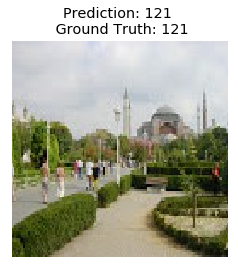

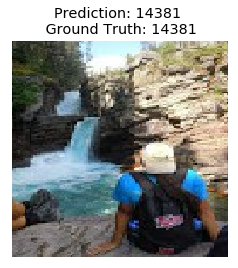

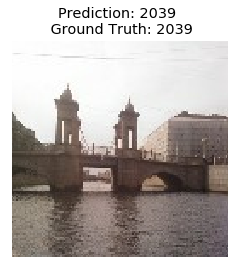

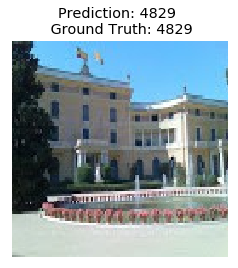

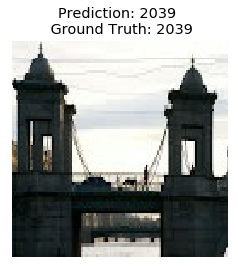

INFO:tensorflow:Model evaluation has completed! Visit TensorBoard for more information regarding your evaluation.


In [65]:
if __name__ == '__main__':
    eval_run()

In [ ]:
# Experiment3.4 change learning rate to 0.0001

In [66]:
import tensorflow as tf
from tensorflow.contrib.framework.python.ops.variables import get_or_create_global_step
from tensorflow.python.platform import tf_logging as logging
from preprocessing import inception_preprocessing
from nets.inception_resnet_v2 import inception_resnet_v2, inception_resnet_v2_arg_scope
import os
import time
slim = tf.contrib.slim

#================ DATASET INFORMATION ======================
#State dataset directory where the tfrecord files are located
dataset_dir = './landmark_recognition'

#State where your log file is at. If it doesn't exist, create it.
log_dir = './landmark_recognition/log'

#State where your checkpoint file is
checkpoint_file = './pretrained_models/inception_resnet_v2_2016_08_30.ckpt'

#State the image size you're resizing your images to. We will use the default inception size of 299.
image_size = 128

#State the number of classes to predict:
num_classes = 7

#State the labels file and read it
labels_file = './landmark_recognition/labels.txt'
labels = open(labels_file, 'r')

#Create a dictionary to refer each label to their string name
labels_to_name = {}
for line in labels:
    label, string_name = line.split(':')
    string_name = string_name[:-1] #Remove newline
    labels_to_name[int(label)] = string_name

#Create the file pattern of your TFRecord files so that it could be recognized later on
file_pattern = 'landmark_%s_*.tfrecord'

#Create a dictionary that will help people understand your dataset better. This is required by the Dataset class later.
items_to_descriptions = {
    'image': 'A 3-channel RGB coloured flower image that is either tulips, sunflowers, roses, dandelion, or daisy.',
    'label': 'A label that is as such -- 0:daisy, 1:dandelion, 2:roses, 3:sunflowers, 4:tulips'
}


#================= TRAINING INFORMATION ==================
#State the number of epochs to train
num_epochs = 20

#State your batch size
batch_size = 10

#Learning rate information and configuration (Up to you to experiment)
initial_learning_rate = 0.0001
learning_rate_decay_factor = 0.7
num_epochs_before_decay = 2

def get_split(split_name, dataset_dir, file_pattern=file_pattern):
    """
    Obtains the split - training or validation - to create a Dataset class for feeding the examples into a queue later
    on. This function will set up the decoder and dataset information all into one Dataset class so that you can avoid
    the brute work later on.
    
    Your file_pattern is very important in locating the files later. 

    INPUTS:
        - split_name(str): 'train' or 'validation'. Used to get the correct data split of tfrecord files
        - dataset_dir(str): the dataset directory where the tfrecord files are located
        - file_pattern(str): the file name structure of the tfrecord files in order to get the correct data

    OUTPUTS:
    - dataset (Dataset): A Dataset class object where we can read its various components for easier batch creation.
    """
    #First check whether the split_name is train or validation
    if split_name not in ['train', 'validation']:
        raise ValueError(\
        'The split_name %s is not recognized. Please input either train or validation as the split_name'\
        % (split_name))

    #Create the full path for a general file_pattern to locate the tfrecord_files
    file_pattern_path = os.path.join(dataset_dir, file_pattern % (split_name))

    #Count the total number of examples in all of these shard
    num_samples = 0
    file_pattern_for_counting = 'landmark_' + split_name
    tfrecords_to_count = [os.path.join(dataset_dir, file) for file in os.listdir(dataset_dir)\
                         if file.startswith(file_pattern_for_counting)]
    for tfrecord_file in tfrecords_to_count:
        for record in tf.python_io.tf_record_iterator(tfrecord_file):
            num_samples += 1

    #Create a reader, which must be a TFRecord reader in this case
    reader = tf.TFRecordReader

    #Create the keys_to_features dictionary for the decoder
    keys_to_features = {
      'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
      'image/format': tf.FixedLenFeature((), tf.string, default_value='jpg'),
      'image/class/label': tf.FixedLenFeature(
          [], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
    }

    #Create the items_to_handlers dictionary for the decoder.
    items_to_handlers = {
    'image': slim.tfexample_decoder.Image(),
    'label': slim.tfexample_decoder.Tensor('image/class/label'),
    }

    #Start to create the decoder
    decoder = slim.tfexample_decoder.TFExampleDecoder(keys_to_features, items_to_handlers)

    #Create the labels_to_name file
    labels_to_name_dict = labels_to_name

    #Actually create the dataset
    dataset = slim.dataset.Dataset(
        data_sources = file_pattern_path,
        decoder = decoder,
        reader = reader,
        num_readers = 4,
        num_samples = num_samples,
        num_classes = num_classes,
        labels_to_name = labels_to_name_dict,
        items_to_descriptions = items_to_descriptions)

    return dataset

def load_batch(dataset, batch_size, height=image_size, width=image_size, is_training=True):
    '''
    Loads a batch for training.

    INPUTS:
    - dataset(Dataset): a Dataset class object that is created from the get_split function
    - batch_size(int): determines how big of a batch to train
    - height(int): the height of the image to resize to during preprocessing
    - width(int): the width of the image to resize to during preprocessing
    - is_training(bool): to determine whether to perform a training or evaluation preprocessing

    OUTPUTS:
    - images(Tensor): a Tensor of the shape (batch_size, height, width, channels) that contain one batch of images
    - labels(Tensor): the batch's labels with the shape (batch_size,) (requires one_hot_encoding).

    '''
    #First create the data_provider object
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset,
        common_queue_capacity = 24 + 3 * batch_size,
        common_queue_min = 24)

    #Obtain the raw image using the get method
    raw_image, label = data_provider.get(['image', 'label'])

    #Perform the correct preprocessing for this image depending if it is training or evaluating
    image = inception_preprocessing.preprocess_image(raw_image, height, width, is_training)

    #As for the raw images, we just do a simple reshape to batch it up
    raw_image = tf.expand_dims(raw_image, 0)
    raw_image = tf.image.resize_nearest_neighbor(raw_image, [height, width])
    raw_image = tf.squeeze(raw_image)

    #Batch up the image by enqueing the tensors internally in a FIFO queue and dequeueing many elements with tf.train.batch.
    images, raw_images, labels = tf.train.batch(
        [image, raw_image, label],
        batch_size = batch_size,
        num_threads = 4,
        capacity = 4 * batch_size,
        allow_smaller_final_batch = True)

    return images, raw_images, labels

def run():
    #Create the log directory here. Must be done here otherwise import will activate this unneededly.
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)

    #======================= TRAINING PROCESS =========================
    #Now we start to construct the graph and build our model
    with tf.Graph().as_default() as graph:
        tf.logging.set_verbosity(tf.logging.INFO) #Set the verbosity to INFO level

        #First create the dataset and load one batch
        dataset = get_split('train', dataset_dir, file_pattern=file_pattern)
        images, _, labels = load_batch(dataset, batch_size=batch_size)

        #Know the number steps to take before decaying the learning rate and batches per epoch
        num_batches_per_epoch = int(dataset.num_samples / batch_size)
        num_steps_per_epoch = num_batches_per_epoch #Because one step is one batch processed
        decay_steps = int(num_epochs_before_decay * num_steps_per_epoch)

        #Create the model inference
        with slim.arg_scope(inception_resnet_v2_arg_scope()):
            logits, end_points = inception_resnet_v2(images, num_classes = dataset.num_classes, is_training = True)

        #Define the scopes that you want to exclude for restoration
        exclude = ['InceptionResnetV2/Logits', 'InceptionResnetV2/AuxLogits']
        variables_to_restore = slim.get_variables_to_restore(exclude = exclude)

        #Perform one-hot-encoding of the labels (Try one-hot-encoding within the load_batch function!)
        one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)

        #Performs the equivalent to tf.nn.sparse_softmax_cross_entropy_with_logits but enhanced with checks
        loss = tf.losses.softmax_cross_entropy(onehot_labels = one_hot_labels, logits = logits)
        total_loss = tf.losses.get_total_loss()    #obtain the regularization losses as well

        #Create the global step for monitoring the learning_rate and training.
        global_step = get_or_create_global_step()

        #Define your exponentially decaying learning rate
        lr = tf.train.exponential_decay(
            learning_rate = initial_learning_rate,
            global_step = global_step,
            decay_steps = decay_steps,
            decay_rate = learning_rate_decay_factor,
            staircase = True)

        #Now we can define the optimizer that takes on the learning rate
        optimizer = tf.train.AdamOptimizer(learning_rate = lr)

        #Create the train_op.
        train_op = slim.learning.create_train_op(total_loss, optimizer)

        #State the metrics that you want to predict. We get a predictions that is not one_hot_encoded.
        predictions = tf.argmax(end_points['Predictions'], 1)
        probabilities = end_points['Predictions']
        accuracy, accuracy_update = tf.contrib.metrics.streaming_accuracy(predictions, labels)
        metrics_op = tf.group(accuracy_update, probabilities)


        #Now finally create all the summaries you need to monitor and group them into one summary op.
        tf.summary.scalar('losses/Total_Loss', total_loss)
        tf.summary.scalar('accuracy', accuracy)
        tf.summary.scalar('learning_rate', lr)
        my_summary_op = tf.summary.merge_all()

        #Now we need to create a training step function that runs both the train_op, metrics_op and updates the global_step concurrently.
        def train_step(sess, train_op, global_step):
            '''
            Simply runs a session for the three arguments provided and gives a logging on the time elapsed for each global step
            '''
            #Check the time for each sess run
            start_time = time.time()
            total_loss, global_step_count, _ = sess.run([train_op, global_step, metrics_op])
            time_elapsed = time.time() - start_time

            #Run the logging to print some results
            logging.info('global step %s: loss: %.4f (%.2f sec/step)', global_step_count, total_loss, time_elapsed)

            return total_loss, global_step_count

        #Now we create a saver function that actually restores the variables from a checkpoint file in a sess
        saver = tf.train.Saver(variables_to_restore)
        def restore_fn(sess):
            return saver.restore(sess, checkpoint_file)

        #Define your supervisor for running a managed session. Do not run the summary_op automatically or else it will consume too much memory
        sv = tf.train.Supervisor(logdir = log_dir, summary_op = None, init_fn = restore_fn)


        #Run the managed session
        with sv.managed_session() as sess:
            for step in range(num_steps_per_epoch * num_epochs):
                #At the start of every epoch, show the vital information:
                if step % num_batches_per_epoch == 0:
                    logging.info('Epoch %s/%s', step/num_batches_per_epoch + 1, num_epochs)
                    learning_rate_value, accuracy_value = sess.run([lr, accuracy])
                    logging.info('Current Learning Rate: %s', learning_rate_value)
                    logging.info('Current Streaming Accuracy: %s', accuracy_value)

                    # optionally, print your logits and predictions for a sanity check that things are going fine.
                    logits_value, probabilities_value, predictions_value, labels_value = sess.run([logits, probabilities, predictions, labels])
                    print('logits: \n', logits_value)
                    print('Probabilities: \n', probabilities_value)
                    print('predictions: \n', predictions_value)
                    print('Labels:\n:', labels_value)

                #Log the summaries every 10 step.
                if step % 10 == 0:
                    loss, _ = train_step(sess, train_op, sv.global_step)
                    summaries = sess.run(my_summary_op)
                    sv.summary_computed(sess, summaries)
                    
                #If not, simply run the training step
                else:
                    loss, _ = train_step(sess, train_op, sv.global_step)

            #We log the final training loss and accuracy
            logging.info('Final Loss: %s', loss)
            logging.info('Final Accuracy: %s', sess.run(accuracy))

            #Once all the training has been done, save the log files and checkpoint model
            logging.info('Finished training! Saving model to disk now.')
            # saver.save(sess, "./flowers_model.ckpt")
            sv.saver.save(sess, sv.save_path, global_step = sv.global_step)

if __name__ == '__main__':
    run()

INFO:tensorflow:Restoring parameters from ./pretrained_models/inception_resnet_v2_2016_08_30.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:Epoch 1.0/20
INFO:tensorflow:Current Learning Rate: 0.0001
INFO:tensorflow:Current Streaming Accuracy: 0.0
logits: 
 [[ 0.59985507 -0.99900025  0.2735967   0.16741174 -0.75763398 -0.16595614
  -0.16600135]
 [ 0.05067306 -0.30450678  0.13804322  0.39800978 -0.39132419 -0.06535582
   0.10101613]
 [-0.07144532  0.07843272  0.13167423 -0.0651897  -0.05475257 -0.10947903
   0.02866593]
 [-0.71094859 -0.35420233  1.00731325  0.07249388 -0.51543301  0.051117
  -0.55137199]
 [ 0.35598454 -0.28832701  0.08682935  0.1634177  -0.07934824  0.01729652
  -0.45290703]
 [ 0.08167133 -0.54881072 -0.26587784 -0.563393   -1.19609022 -1.04819858
  -0.

INFO:tensorflow:global step 98: loss: 1.3628 (5.14 sec/step)
INFO:tensorflow:global step 99: loss: 1.3728 (5.17 sec/step)
INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:global step 100: loss: 0.8564 (5.09 sec/step)
INFO:tensorflow:global step 101: loss: 1.4936 (6.29 sec/step)
INFO:tensorflow:Epoch 2.0/20
INFO:tensorflow:Current Learning Rate: 0.0001
INFO:tensorflow:Current Streaming Accuracy: 0.590099
logits: 
 [[ 1.40365291 -2.33054471  3.03886485 -1.26250374 -0.60584843 -1.59752989
  -2.80026817]
 [ 0.23135203 -4.09524632 -0.02781306 -2.16595387  4.03801775  0.21181197
  -3.05739236]
 [-1.25004137 -0.5076676   1.25842738  4.79656553 -0.49924776 -1.9471122
  -3.38479185]
 [-1.35365427 -0.73686516  0.97868663  5.21413422 -1.96690476 -2.08449841
   0.24006614]
 [-0.65273541 -2.18159246 -0.0822749  -3.59308529  3.99174762 -0.09869661
  -1.83753181]
 [ 3.8339169   1.31994236  0.47786438  0.68043977 -3.47323585 -1.70055592
  -1.75198233]
 [ 

INFO:tensorflow:global step 191: loss: 0.8810 (5.39 sec/step)
INFO:tensorflow:global step 192: loss: 0.7232 (5.19 sec/step)
INFO:tensorflow:global step 193: loss: 0.6317 (5.18 sec/step)
INFO:tensorflow:global step 194: loss: 1.1508 (5.34 sec/step)
INFO:tensorflow:global step 195: loss: 0.6687 (5.17 sec/step)
INFO:tensorflow:global step 196: loss: 0.8369 (5.60 sec/step)
INFO:tensorflow:global step 197: loss: 1.0821 (5.25 sec/step)
INFO:tensorflow:global step 198: loss: 1.1811 (5.13 sec/step)
INFO:tensorflow:global step 199: loss: 0.6956 (5.07 sec/step)
INFO:tensorflow:global step 200: loss: 0.6901 (5.12 sec/step)
INFO:tensorflow:global step 201: loss: 0.7961 (5.06 sec/step)
INFO:tensorflow:global step 202: loss: 1.0175 (5.38 sec/step)
INFO:tensorflow:Epoch 3.0/20
INFO:tensorflow:Current Learning Rate: 7e-05
INFO:tensorflow:Current Streaming Accuracy: 0.712376
logits: 
 [[ 0.22945185  0.20270805 -1.77528977 -2.82838917 -0.81868583  2.53623009
   0.67267191]
 [ 0.40963179  0.25478837 -3.0

INFO:tensorflow:global step 284: loss: 0.6593 (5.12 sec/step)
INFO:tensorflow:global step 285: loss: 0.6636 (5.08 sec/step)
INFO:tensorflow:global step 286: loss: 1.1158 (5.36 sec/step)
INFO:tensorflow:global step 287: loss: 0.6398 (5.11 sec/step)
INFO:tensorflow:global step 288: loss: 0.7623 (5.16 sec/step)
INFO:tensorflow:global step 289: loss: 0.7291 (5.19 sec/step)
INFO:tensorflow:global step 290: loss: 0.5798 (5.13 sec/step)
INFO:tensorflow:global step 291: loss: 0.5890 (5.35 sec/step)
INFO:tensorflow:global step 292: loss: 0.9273 (5.43 sec/step)
INFO:tensorflow:global step 293: loss: 0.7028 (5.17 sec/step)
INFO:tensorflow:global step 294: loss: 0.8332 (5.14 sec/step)
INFO:tensorflow:global step 295: loss: 0.7483 (5.10 sec/step)
INFO:tensorflow:global step 296: loss: 1.0206 (5.13 sec/step)
INFO:tensorflow:global step 297: loss: 0.6075 (5.33 sec/step)
INFO:tensorflow:global step 298: loss: 0.7385 (5.09 sec/step)
INFO:tensorflow:global step 299: loss: 0.9491 (5.08 sec/step)
INFO:ten

INFO:tensorflow:global step 377: loss: 0.9734 (5.20 sec/step)
INFO:tensorflow:global step 378: loss: 0.6521 (5.24 sec/step)
INFO:tensorflow:global step 379: loss: 0.6377 (5.18 sec/step)
INFO:tensorflow:global step 380: loss: 1.0702 (5.33 sec/step)
INFO:tensorflow:global step 381: loss: 1.0743 (5.15 sec/step)
INFO:tensorflow:global step 382: loss: 0.7643 (5.29 sec/step)
INFO:tensorflow:global step 383: loss: 1.0441 (5.92 sec/step)
INFO:tensorflow:global step 384: loss: 0.7332 (6.90 sec/step)
INFO:tensorflow:global step 385: loss: 0.8643 (6.22 sec/step)
INFO:tensorflow:global step 386: loss: 0.6393 (5.11 sec/step)
INFO:tensorflow:global step 387: loss: 0.7549 (5.13 sec/step)
INFO:tensorflow:global step 388: loss: 0.5578 (5.75 sec/step)
INFO:tensorflow:global step 389: loss: 1.5763 (5.42 sec/step)
INFO:tensorflow:global step 390: loss: 1.0782 (5.55 sec/step)
INFO:tensorflow:global step 391: loss: 0.9992 (5.49 sec/step)
INFO:tensorflow:global step 392: loss: 0.9192 (5.20 sec/step)
INFO:ten

INFO:tensorflow:global step 469: loss: 0.7115 (5.04 sec/step)
INFO:tensorflow:global step 470: loss: 0.5522 (5.09 sec/step)
INFO:tensorflow:global step 471: loss: 0.6183 (5.05 sec/step)
INFO:tensorflow:global step 472: loss: 0.5588 (5.26 sec/step)
INFO:tensorflow:global step 473: loss: 1.0577 (5.10 sec/step)
INFO:tensorflow:global step 474: loss: 1.0463 (5.10 sec/step)
INFO:tensorflow:global step 475: loss: 1.1125 (5.06 sec/step)
INFO:tensorflow:global step 476: loss: 0.8598 (5.04 sec/step)
INFO:tensorflow:global step 477: loss: 0.5638 (5.89 sec/step)
INFO:tensorflow:global step 478: loss: 0.6359 (5.15 sec/step)
INFO:tensorflow:global step 479: loss: 0.6022 (5.11 sec/step)
INFO:tensorflow:global step 480: loss: 0.5607 (5.08 sec/step)
INFO:tensorflow:global step 481: loss: 0.6406 (5.16 sec/step)
INFO:tensorflow:global step 482: loss: 0.7308 (5.18 sec/step)
INFO:tensorflow:global step 483: loss: 0.9450 (5.47 sec/step)
INFO:tensorflow:global step 484: loss: 0.5686 (5.17 sec/step)
INFO:ten

INFO:tensorflow:global step 561: loss: 0.5434 (5.63 sec/step)
INFO:tensorflow:global step 562: loss: 0.5597 (5.63 sec/step)
INFO:tensorflow:global step 563: loss: 0.5508 (5.97 sec/step)
INFO:tensorflow:global step 564: loss: 0.7197 (5.94 sec/step)
INFO:tensorflow:global step 565: loss: 0.5636 (6.43 sec/step)
INFO:tensorflow:global step 566: loss: 0.5845 (5.61 sec/step)
INFO:tensorflow:global step 567: loss: 1.3204 (5.50 sec/step)
INFO:tensorflow:global step 568: loss: 0.7717 (5.56 sec/step)
INFO:tensorflow:global step 569: loss: 0.8330 (5.44 sec/step)
INFO:tensorflow:global step 570: loss: 0.5885 (5.84 sec/step)
INFO:tensorflow:global step 571: loss: 1.0877 (5.55 sec/step)
INFO:tensorflow:global step 572: loss: 1.4211 (5.68 sec/step)
INFO:tensorflow:global step 573: loss: 0.7340 (5.68 sec/step)
INFO:tensorflow:global step 574: loss: 0.6141 (5.96 sec/step)
INFO:tensorflow:global step 575: loss: 1.1262 (6.70 sec/step)
INFO:tensorflow:global step 576: loss: 0.7346 (5.75 sec/step)
INFO:ten

INFO:tensorflow:global step 653: loss: 0.9319 (8.59 sec/step)
INFO:tensorflow:global step 654: loss: 0.8042 (5.63 sec/step)
INFO:tensorflow:global step 655: loss: 0.6416 (5.14 sec/step)
INFO:tensorflow:global step 656: loss: 0.5874 (5.97 sec/step)
INFO:tensorflow:global step 657: loss: 0.8435 (5.93 sec/step)
INFO:tensorflow:global step 658: loss: 0.6789 (6.89 sec/step)
INFO:tensorflow:global step 659: loss: 0.5917 (6.24 sec/step)
INFO:tensorflow:global step 660: loss: 0.8464 (5.20 sec/step)
INFO:tensorflow:global step 661: loss: 0.7853 (5.16 sec/step)
INFO:tensorflow:global step 662: loss: 1.0506 (5.48 sec/step)
INFO:tensorflow:global step 663: loss: 0.9356 (5.33 sec/step)
INFO:tensorflow:global step 664: loss: 1.0994 (7.38 sec/step)
INFO:tensorflow:global step 665: loss: 1.0043 (5.40 sec/step)
INFO:tensorflow:global step 666: loss: 1.3186 (6.11 sec/step)
INFO:tensorflow:global step 667: loss: 0.8885 (5.96 sec/step)
INFO:tensorflow:global step 668: loss: 1.2607 (6.09 sec/step)
INFO:ten

INFO:tensorflow:global step 741: loss: 0.5462 (5.11 sec/step)
INFO:tensorflow:global step 742: loss: 0.5516 (5.15 sec/step)
INFO:tensorflow:global step 743: loss: 0.7937 (5.30 sec/step)
INFO:tensorflow:global step 744: loss: 0.5550 (5.20 sec/step)
INFO:tensorflow:global step 745: loss: 0.8258 (5.26 sec/step)
INFO:tensorflow:global step 746: loss: 0.6325 (5.12 sec/step)
INFO:tensorflow:global step 747: loss: 0.9304 (5.05 sec/step)
INFO:tensorflow:global step 748: loss: 1.0774 (5.10 sec/step)
INFO:tensorflow:global step 749: loss: 0.6984 (5.74 sec/step)
INFO:tensorflow:global step 750: loss: 0.5577 (5.16 sec/step)
INFO:tensorflow:global step 751: loss: 0.9551 (5.10 sec/step)
INFO:tensorflow:global step 752: loss: 0.5486 (5.04 sec/step)
INFO:tensorflow:global step 753: loss: 0.5263 (5.13 sec/step)
INFO:tensorflow:global step 754: loss: 0.5509 (5.31 sec/step)
INFO:tensorflow:global step 755: loss: 0.5922 (5.15 sec/step)
INFO:tensorflow:global step 756: loss: 0.5475 (5.11 sec/step)
INFO:ten

INFO:tensorflow:global step 830: loss: 0.6287 (5.03 sec/step)
INFO:tensorflow:global step 831: loss: 0.5460 (5.11 sec/step)
INFO:tensorflow:global step 832: loss: 0.5865 (5.12 sec/step)
INFO:tensorflow:global step 833: loss: 0.7057 (5.30 sec/step)
INFO:tensorflow:global step 834: loss: 0.7644 (5.09 sec/step)
INFO:tensorflow:global step 835: loss: 0.6472 (5.04 sec/step)
INFO:tensorflow:global step 836: loss: 0.5895 (5.04 sec/step)
INFO:tensorflow:global step 837: loss: 0.6810 (5.14 sec/step)
INFO:tensorflow:global step 838: loss: 0.5537 (5.38 sec/step)
INFO:tensorflow:global step 839: loss: 0.6298 (5.43 sec/step)
INFO:tensorflow:global step 840: loss: 1.3181 (5.10 sec/step)
INFO:tensorflow:global step 841: loss: 0.5535 (5.06 sec/step)
INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:global step 842: loss: 0.9047 (5.40 sec/step)
INFO:tensorflow:global step 843: loss: 1.2911 (6.44 sec/step)
INFO:tensorflow:global step 844: loss: 0.5591 (7.60 

INFO:tensorflow:global step 918: loss: 0.5416 (5.75 sec/step)
INFO:tensorflow:global step 919: loss: 0.7141 (5.17 sec/step)
INFO:tensorflow:global step 920: loss: 0.7200 (5.30 sec/step)
INFO:tensorflow:global step 921: loss: 0.8780 (5.90 sec/step)
INFO:tensorflow:global step 922: loss: 0.6803 (5.21 sec/step)
INFO:tensorflow:global step 923: loss: 0.5373 (5.29 sec/step)
INFO:tensorflow:global step 924: loss: 0.5341 (5.30 sec/step)
INFO:tensorflow:global step 925: loss: 0.6475 (5.22 sec/step)
INFO:tensorflow:global step 926: loss: 0.6372 (5.26 sec/step)
INFO:tensorflow:global step 927: loss: 0.5666 (5.34 sec/step)
INFO:tensorflow:global step 928: loss: 0.6258 (5.30 sec/step)
INFO:tensorflow:global step 929: loss: 0.5782 (5.28 sec/step)
INFO:tensorflow:global step 930: loss: 0.5443 (5.22 sec/step)
INFO:tensorflow:global step 931: loss: 0.6838 (5.26 sec/step)
INFO:tensorflow:global step 932: loss: 0.6756 (5.37 sec/step)
INFO:tensorflow:global step 933: loss: 0.6793 (5.16 sec/step)
INFO:ten

INFO:tensorflow:global step 1011: loss: 1.0341 (5.12 sec/step)
INFO:tensorflow:global step 1012: loss: 1.3407 (5.14 sec/step)
INFO:tensorflow:global step 1013: loss: 0.9465 (5.42 sec/step)
INFO:tensorflow:global step 1014: loss: 0.6858 (7.24 sec/step)
INFO:tensorflow:global step 1015: loss: 0.6166 (5.37 sec/step)
INFO:tensorflow:global step 1016: loss: 0.6736 (5.20 sec/step)
INFO:tensorflow:global step 1017: loss: 0.5660 (5.14 sec/step)
INFO:tensorflow:global step 1018: loss: 0.5705 (5.48 sec/step)
INFO:tensorflow:global step 1019: loss: 0.6160 (5.40 sec/step)
INFO:tensorflow:global step 1020: loss: 0.5289 (5.29 sec/step)
INFO:tensorflow:global step 1021: loss: 0.5830 (5.24 sec/step)
INFO:tensorflow:global step 1022: loss: 0.5326 (5.15 sec/step)
INFO:tensorflow:global step 1023: loss: 0.6311 (6.19 sec/step)
INFO:tensorflow:global step 1024: loss: 0.6810 (5.36 sec/step)
INFO:tensorflow:global step 1025: loss: 0.5664 (6.41 sec/step)
INFO:tensorflow:global step 1026: loss: 0.5423 (5.90 se

INFO:tensorflow:global step 1112: loss: 0.5654 (7.21 sec/step)
INFO:tensorflow:global step 1113: loss: 0.9859 (5.48 sec/step)
INFO:tensorflow:global step 1114: loss: 0.6520 (5.38 sec/step)
INFO:tensorflow:global step 1115: loss: 0.6006 (5.25 sec/step)
INFO:tensorflow:global step 1116: loss: 1.0177 (6.39 sec/step)
INFO:tensorflow:global step 1117: loss: 0.5390 (5.33 sec/step)
INFO:tensorflow:global step 1118: loss: 0.7482 (5.14 sec/step)
INFO:tensorflow:global step 1119: loss: 0.7498 (5.13 sec/step)
INFO:tensorflow:global step 1120: loss: 0.8757 (5.63 sec/step)
INFO:tensorflow:global step 1121: loss: 0.9875 (5.20 sec/step)
INFO:tensorflow:global step 1122: loss: 0.5676 (5.17 sec/step)
INFO:tensorflow:global step 1123: loss: 0.7032 (5.28 sec/step)
INFO:tensorflow:global step 1124: loss: 0.7034 (5.16 sec/step)
INFO:tensorflow:global step 1125: loss: 0.5299 (5.40 sec/step)
INFO:tensorflow:global step 1126: loss: 0.5535 (5.20 sec/step)
INFO:tensorflow:global step 1127: loss: 0.5515 (5.17 se

INFO:tensorflow:global step 1213: loss: 0.5973 (9.11 sec/step)
INFO:tensorflow:global step 1214: loss: 0.5353 (8.17 sec/step)
INFO:tensorflow:global step 1215: loss: 0.7308 (7.60 sec/step)
INFO:tensorflow:global step 1216: loss: 0.6070 (6.49 sec/step)
INFO:tensorflow:global step 1217: loss: 0.8741 (5.42 sec/step)
INFO:tensorflow:global step 1218: loss: 0.5604 (5.26 sec/step)
INFO:tensorflow:global step 1219: loss: 0.6250 (5.19 sec/step)
INFO:tensorflow:global step 1220: loss: 0.6936 (5.53 sec/step)
INFO:tensorflow:global step 1221: loss: 0.5887 (5.42 sec/step)
INFO:tensorflow:global step 1222: loss: 0.9335 (5.79 sec/step)
INFO:tensorflow:global step 1223: loss: 0.5358 (5.46 sec/step)
INFO:tensorflow:global step 1224: loss: 0.5938 (5.40 sec/step)
INFO:tensorflow:global step 1225: loss: 0.6129 (5.40 sec/step)
INFO:tensorflow:global step 1226: loss: 0.5390 (5.86 sec/step)
INFO:tensorflow:global step 1227: loss: 0.6085 (5.34 sec/step)
INFO:tensorflow:global step 1228: loss: 0.9175 (5.22 se

INFO:tensorflow:global step 1314: loss: 0.5662 (5.18 sec/step)
INFO:tensorflow:global step 1315: loss: 0.5369 (5.24 sec/step)
INFO:tensorflow:global step 1316: loss: 0.6061 (5.38 sec/step)
INFO:tensorflow:global step 1317: loss: 0.5963 (5.14 sec/step)
INFO:tensorflow:global step 1318: loss: 1.0465 (5.17 sec/step)
INFO:tensorflow:global step 1319: loss: 0.7763 (5.11 sec/step)
INFO:tensorflow:global step 1320: loss: 0.5342 (5.17 sec/step)
INFO:tensorflow:global step 1321: loss: 0.5252 (5.39 sec/step)
INFO:tensorflow:global step 1322: loss: 0.8159 (5.07 sec/step)
INFO:tensorflow:global step 1323: loss: 0.5741 (5.09 sec/step)
INFO:tensorflow:global step 1324: loss: 0.5566 (5.11 sec/step)
INFO:tensorflow:global step 1325: loss: 0.9797 (5.06 sec/step)
INFO:tensorflow:global step 1326: loss: 0.6283 (5.08 sec/step)
INFO:tensorflow:global step 1327: loss: 0.5347 (5.26 sec/step)
INFO:tensorflow:global step 1328: loss: 0.6041 (5.14 sec/step)
INFO:tensorflow:global step 1329: loss: 0.5394 (5.09 se

INFO:tensorflow:global step 1415: loss: 0.6158 (5.10 sec/step)
INFO:tensorflow:global step 1416: loss: 0.5465 (5.09 sec/step)
INFO:tensorflow:global step 1417: loss: 0.5524 (5.04 sec/step)
INFO:tensorflow:global step 1418: loss: 0.8696 (5.08 sec/step)
INFO:tensorflow:global step 1419: loss: 0.5317 (5.06 sec/step)
INFO:tensorflow:global step 1420: loss: 0.9169 (5.48 sec/step)
INFO:tensorflow:global step 1421: loss: 0.5274 (5.38 sec/step)
INFO:tensorflow:global step 1422: loss: 0.6300 (5.18 sec/step)
INFO:tensorflow:global step 1423: loss: 0.8787 (6.49 sec/step)
INFO:tensorflow:global step 1424: loss: 0.6045 (6.52 sec/step)
INFO:tensorflow:global step 1425: loss: 0.6049 (6.66 sec/step)
INFO:tensorflow:global step 1426: loss: 0.5625 (6.18 sec/step)
INFO:tensorflow:global step 1427: loss: 0.7337 (6.37 sec/step)
INFO:tensorflow:global step 1428: loss: 0.6344 (5.66 sec/step)
INFO:tensorflow:global step 1429: loss: 1.1311 (5.99 sec/step)
INFO:tensorflow:global step 1430: loss: 0.5922 (6.58 se

INFO:tensorflow:global step 1516: loss: 0.5334 (5.99 sec/step)
INFO:tensorflow:global step 1517: loss: 0.5513 (6.24 sec/step)
INFO:tensorflow:global step 1518: loss: 0.5342 (5.67 sec/step)
INFO:tensorflow:global step 1519: loss: 0.5260 (6.08 sec/step)
INFO:tensorflow:global step 1520: loss: 1.3426 (5.61 sec/step)
INFO:tensorflow:global step 1521: loss: 0.5545 (5.08 sec/step)
INFO:tensorflow:global step 1522: loss: 0.8308 (5.70 sec/step)
INFO:tensorflow:global step 1523: loss: 0.5382 (5.92 sec/step)
INFO:tensorflow:global step 1524: loss: 0.5561 (6.81 sec/step)
INFO:tensorflow:global step 1525: loss: 0.5403 (5.83 sec/step)
INFO:tensorflow:global step 1526: loss: 0.7967 (5.70 sec/step)
INFO:tensorflow:global step 1527: loss: 1.2161 (5.72 sec/step)
INFO:tensorflow:global step 1528: loss: 0.6321 (5.37 sec/step)
INFO:tensorflow:global step 1529: loss: 0.5314 (5.67 sec/step)
INFO:tensorflow:global step 1530: loss: 0.5251 (6.52 sec/step)
INFO:tensorflow:global step 1531: loss: 0.5284 (5.06 se

INFO:tensorflow:global step 1617: loss: 1.1365 (5.38 sec/step)
INFO:tensorflow:global step 1618: loss: 1.0872 (5.25 sec/step)
INFO:tensorflow:global step 1619: loss: 0.5386 (5.23 sec/step)
INFO:tensorflow:global step 1620: loss: 0.5580 (5.34 sec/step)
INFO:tensorflow:global step 1621: loss: 0.5685 (5.18 sec/step)
INFO:tensorflow:global step 1622: loss: 0.5340 (5.19 sec/step)
INFO:tensorflow:global step 1623: loss: 0.5548 (5.49 sec/step)
INFO:tensorflow:global step 1624: loss: 0.9685 (5.18 sec/step)
INFO:tensorflow:global step 1625: loss: 0.5965 (5.19 sec/step)
INFO:tensorflow:global step 1626: loss: 0.7326 (5.16 sec/step)
INFO:tensorflow:global step 1627: loss: 0.7467 (5.23 sec/step)
INFO:tensorflow:global step 1628: loss: 1.0612 (5.21 sec/step)
INFO:tensorflow:global step 1629: loss: 0.8780 (5.74 sec/step)
INFO:tensorflow:global step 1630: loss: 0.8493 (5.40 sec/step)
INFO:tensorflow:global step 1631: loss: 0.5303 (5.30 sec/step)
INFO:tensorflow:global step 1632: loss: 0.5331 (5.15 se

INFO:tensorflow:global step 1718: loss: 0.5938 (5.22 sec/step)
INFO:tensorflow:global step 1719: loss: 0.5853 (5.19 sec/step)
INFO:tensorflow:global step 1720: loss: 0.5299 (5.20 sec/step)
INFO:tensorflow:global step 1721: loss: 0.6798 (5.23 sec/step)
INFO:tensorflow:global step 1722: loss: 0.8387 (5.39 sec/step)
INFO:tensorflow:global step 1723: loss: 0.7123 (5.20 sec/step)
INFO:tensorflow:global step 1724: loss: 0.7250 (5.14 sec/step)
INFO:tensorflow:global step 1725: loss: 0.5965 (5.24 sec/step)
INFO:tensorflow:global step 1726: loss: 0.6635 (5.17 sec/step)
INFO:tensorflow:global step 1727: loss: 0.8219 (5.18 sec/step)
INFO:tensorflow:global step 1728: loss: 0.5754 (5.50 sec/step)
INFO:tensorflow:global step 1729: loss: 0.5283 (5.25 sec/step)
INFO:tensorflow:global step 1730: loss: 0.8818 (5.17 sec/step)
INFO:tensorflow:global step 1731: loss: 0.5421 (5.14 sec/step)
INFO:tensorflow:global step 1732: loss: 0.5320 (5.13 sec/step)
INFO:tensorflow:global step 1733: loss: 0.7575 (5.38 se

INFO:tensorflow:global step 1819: loss: 0.6579 (5.16 sec/step)
INFO:tensorflow:global step 1820: loss: 0.7072 (5.17 sec/step)
INFO:tensorflow:global step 1821: loss: 0.5860 (5.87 sec/step)
INFO:tensorflow:global step 1822: loss: 0.5368 (5.93 sec/step)
INFO:tensorflow:global step 1823: loss: 0.5428 (6.64 sec/step)
INFO:tensorflow:global step 1824: loss: 0.6599 (5.86 sec/step)
INFO:tensorflow:global step 1825: loss: 0.6020 (6.11 sec/step)
INFO:tensorflow:global step 1826: loss: 0.9749 (5.35 sec/step)
INFO:tensorflow:global step 1827: loss: 0.7913 (5.31 sec/step)
INFO:tensorflow:global step 1828: loss: 0.5623 (5.13 sec/step)
INFO:tensorflow:global step 1829: loss: 0.8294 (6.06 sec/step)
INFO:tensorflow:global step 1830: loss: 1.3254 (6.24 sec/step)
INFO:tensorflow:global step 1831: loss: 0.5703 (6.62 sec/step)
INFO:tensorflow:global step 1832: loss: 0.7458 (5.19 sec/step)
INFO:tensorflow:global step 1833: loss: 0.5403 (5.24 sec/step)
INFO:tensorflow:global step 1834: loss: 0.5750 (5.84 se

INFO:tensorflow:global step 1920: loss: 0.6372 (6.64 sec/step)
INFO:tensorflow:global step 1921: loss: 0.5294 (5.27 sec/step)
INFO:tensorflow:global step 1922: loss: 0.5814 (5.97 sec/step)
INFO:tensorflow:global step 1923: loss: 0.5716 (6.53 sec/step)
INFO:tensorflow:global step 1924: loss: 0.5315 (6.93 sec/step)
INFO:tensorflow:global step 1925: loss: 0.5680 (6.70 sec/step)
INFO:tensorflow:global step 1926: loss: 0.6238 (6.68 sec/step)
INFO:tensorflow:global step 1927: loss: 0.6322 (6.31 sec/step)
INFO:tensorflow:global step 1928: loss: 0.8351 (6.28 sec/step)
INFO:tensorflow:global step 1929: loss: 0.8897 (5.95 sec/step)
INFO:tensorflow:global step 1930: loss: 0.5760 (6.83 sec/step)
INFO:tensorflow:global step 1931: loss: 0.5262 (6.21 sec/step)
INFO:tensorflow:global step 1932: loss: 0.5796 (5.57 sec/step)
INFO:tensorflow:global step 1933: loss: 0.5580 (5.76 sec/step)
INFO:tensorflow:global step 1934: loss: 0.5448 (6.44 sec/step)
INFO:tensorflow:global step 1935: loss: 0.7470 (6.58 se

INFO:tensorflow:Restoring parameters from ./landmark_recognition/log/model.ckpt-2020
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:Epoch: 1.0/20
INFO:tensorflow:Current Streaming Accuracy: 0.0000
INFO:tensorflow:Global Step 1: Streaming Accuracy: 0.0000 (3.53 sec/step)
INFO:tensorflow:Global Step 2: Streaming Accuracy: 0.9000 (2.34 sec/step)
INFO:tensorflow:Global Step 3: Streaming Accuracy: 0.9500 (2.33 sec/step)
INFO:tensorflow:Global Step 4: Streaming Accuracy: 0.9667 (2.33 sec/step)
INFO:tensorflow:Global Step 5: Streaming Accuracy: 0.9750 (2.32 sec/step)
INFO:tensorflow:Global Step 6: Streaming Accuracy: 0.9800 (2.28 sec/step)
INFO:tensorflow:Global Step 7: Streaming Accuracy: 0.9833 (2.25 sec/step)
INFO:tensorflow:Global Step 8: Streaming Accuracy: 0.9857 (2.25 sec/step)
INFO:tensorflow:Global Step 9: Streaming Accuracy: 0.9812 (2.48 sec/step)
I

INFO:tensorflow:Global Step 106: Streaming Accuracy: 0.9795 (2.45 sec/step)
INFO:tensorflow:Global Step 107: Streaming Accuracy: 0.9797 (2.51 sec/step)
INFO:tensorflow:Global Step 108: Streaming Accuracy: 0.9794 (2.94 sec/step)
INFO:tensorflow:Global Step 109: Streaming Accuracy: 0.9792 (2.67 sec/step)
INFO:tensorflow:Global Step 110: Streaming Accuracy: 0.9789 (2.45 sec/step)
INFO:tensorflow:Global Step 111: Streaming Accuracy: 0.9786 (2.36 sec/step)
INFO:tensorflow:Global Step 112: Streaming Accuracy: 0.9788 (2.37 sec/step)
INFO:tensorflow:Global Step 113: Streaming Accuracy: 0.9790 (2.37 sec/step)
INFO:tensorflow:Global Step 114: Streaming Accuracy: 0.9792 (2.51 sec/step)
INFO:tensorflow:Global Step 115: Streaming Accuracy: 0.9794 (2.51 sec/step)
INFO:tensorflow:Global Step 116: Streaming Accuracy: 0.9796 (2.53 sec/step)
INFO:tensorflow:Global Step 117: Streaming Accuracy: 0.9797 (2.42 sec/step)
INFO:tensorflow:Global Step 118: Streaming Accuracy: 0.9795 (2.47 sec/step)
INFO:tensorf

INFO:tensorflow:Global Step 214: Streaming Accuracy: 0.9791 (2.97 sec/step)
INFO:tensorflow:Global Step 215: Streaming Accuracy: 0.9792 (2.46 sec/step)
INFO:tensorflow:Global Step 216: Streaming Accuracy: 0.9793 (2.76 sec/step)
INFO:tensorflow:Global Step 217: Streaming Accuracy: 0.9794 (2.47 sec/step)
INFO:tensorflow:Global Step 218: Streaming Accuracy: 0.9795 (2.42 sec/step)
INFO:tensorflow:Global Step 219: Streaming Accuracy: 0.9796 (2.40 sec/step)
INFO:tensorflow:Global Step 220: Streaming Accuracy: 0.9795 (2.37 sec/step)
INFO:tensorflow:Global Step 221: Streaming Accuracy: 0.9793 (2.33 sec/step)
INFO:tensorflow:Global Step 222: Streaming Accuracy: 0.9792 (2.30 sec/step)
INFO:tensorflow:Global Step 223: Streaming Accuracy: 0.9793 (2.43 sec/step)
INFO:tensorflow:Global Step 224: Streaming Accuracy: 0.9794 (2.42 sec/step)
INFO:tensorflow:Global Step 225: Streaming Accuracy: 0.9795 (2.39 sec/step)
INFO:tensorflow:Global Step 226: Streaming Accuracy: 0.9791 (2.47 sec/step)
INFO:tensorf

INFO:tensorflow:Global Step 322: Streaming Accuracy: 0.9794 (2.52 sec/step)
INFO:tensorflow:Global Step 323: Streaming Accuracy: 0.9793 (2.40 sec/step)
INFO:tensorflow:Global Step 324: Streaming Accuracy: 0.9794 (2.60 sec/step)
INFO:tensorflow:Global Step 325: Streaming Accuracy: 0.9795 (2.70 sec/step)
INFO:tensorflow:Global Step 326: Streaming Accuracy: 0.9795 (2.79 sec/step)
INFO:tensorflow:Global Step 327: Streaming Accuracy: 0.9796 (2.52 sec/step)
INFO:tensorflow:Global Step 328: Streaming Accuracy: 0.9794 (2.40 sec/step)
INFO:tensorflow:Global Step 329: Streaming Accuracy: 0.9793 (2.46 sec/step)
INFO:tensorflow:Global Step 330: Streaming Accuracy: 0.9792 (2.40 sec/step)
INFO:tensorflow:Global Step 331: Streaming Accuracy: 0.9792 (2.42 sec/step)
INFO:tensorflow:Global Step 332: Streaming Accuracy: 0.9792 (2.44 sec/step)
INFO:tensorflow:Global Step 333: Streaming Accuracy: 0.9792 (2.41 sec/step)
INFO:tensorflow:Global Step 334: Streaming Accuracy: 0.9793 (2.44 sec/step)
INFO:tensorf

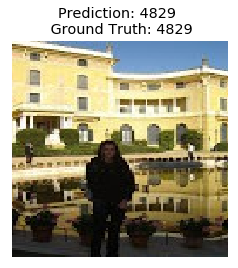

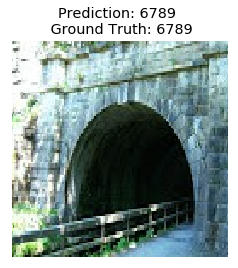

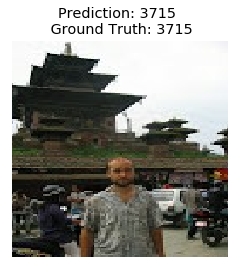

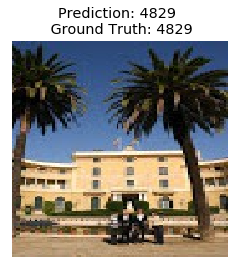

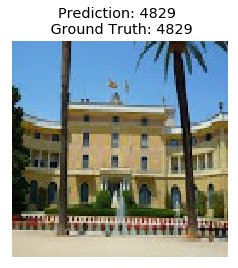

INFO:tensorflow:Model evaluation has completed! Visit TensorBoard for more information regarding your evaluation.


In [69]:
if __name__ == '__main__':
    eval_run()

In [ ]:
# Experiment 3.5 change the learning rate to 0.00002

In [70]:
import tensorflow as tf
from tensorflow.contrib.framework.python.ops.variables import get_or_create_global_step
from tensorflow.python.platform import tf_logging as logging
from preprocessing import inception_preprocessing
from nets.inception_resnet_v2 import inception_resnet_v2, inception_resnet_v2_arg_scope
import os
import time
slim = tf.contrib.slim

#================ DATASET INFORMATION ======================
#State dataset directory where the tfrecord files are located
dataset_dir = './landmark_recognition'

#State where your log file is at. If it doesn't exist, create it.
log_dir = './landmark_recognition/log'

#State where your checkpoint file is
checkpoint_file = './pretrained_models/inception_resnet_v2_2016_08_30.ckpt'

#State the image size you're resizing your images to. We will use the default inception size of 299.
image_size = 128

#State the number of classes to predict:
num_classes = 7

#State the labels file and read it
labels_file = './landmark_recognition/labels.txt'
labels = open(labels_file, 'r')

#Create a dictionary to refer each label to their string name
labels_to_name = {}
for line in labels:
    label, string_name = line.split(':')
    string_name = string_name[:-1] #Remove newline
    labels_to_name[int(label)] = string_name

#Create the file pattern of your TFRecord files so that it could be recognized later on
file_pattern = 'landmark_%s_*.tfrecord'

#Create a dictionary that will help people understand your dataset better. This is required by the Dataset class later.
items_to_descriptions = {
    'image': 'A 3-channel RGB coloured flower image that is either tulips, sunflowers, roses, dandelion, or daisy.',
    'label': 'A label that is as such -- 0:daisy, 1:dandelion, 2:roses, 3:sunflowers, 4:tulips'
}


#================= TRAINING INFORMATION ==================
#State the number of epochs to train
num_epochs = 20

#State your batch size
batch_size = 10

#Learning rate information and configuration (Up to you to experiment)
initial_learning_rate = 0.00002
learning_rate_decay_factor = 0.7
num_epochs_before_decay = 2

def get_split(split_name, dataset_dir, file_pattern=file_pattern):
    """
    Obtains the split - training or validation - to create a Dataset class for feeding the examples into a queue later
    on. This function will set up the decoder and dataset information all into one Dataset class so that you can avoid
    the brute work later on.
    
    Your file_pattern is very important in locating the files later. 

    INPUTS:
        - split_name(str): 'train' or 'validation'. Used to get the correct data split of tfrecord files
        - dataset_dir(str): the dataset directory where the tfrecord files are located
        - file_pattern(str): the file name structure of the tfrecord files in order to get the correct data

    OUTPUTS:
    - dataset (Dataset): A Dataset class object where we can read its various components for easier batch creation.
    """
    #First check whether the split_name is train or validation
    if split_name not in ['train', 'validation']:
        raise ValueError(\
        'The split_name %s is not recognized. Please input either train or validation as the split_name'\
        % (split_name))

    #Create the full path for a general file_pattern to locate the tfrecord_files
    file_pattern_path = os.path.join(dataset_dir, file_pattern % (split_name))

    #Count the total number of examples in all of these shard
    num_samples = 0
    file_pattern_for_counting = 'landmark_' + split_name
    tfrecords_to_count = [os.path.join(dataset_dir, file) for file in os.listdir(dataset_dir)\
                         if file.startswith(file_pattern_for_counting)]
    for tfrecord_file in tfrecords_to_count:
        for record in tf.python_io.tf_record_iterator(tfrecord_file):
            num_samples += 1

    #Create a reader, which must be a TFRecord reader in this case
    reader = tf.TFRecordReader

    #Create the keys_to_features dictionary for the decoder
    keys_to_features = {
      'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
      'image/format': tf.FixedLenFeature((), tf.string, default_value='jpg'),
      'image/class/label': tf.FixedLenFeature(
          [], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
    }

    #Create the items_to_handlers dictionary for the decoder.
    items_to_handlers = {
    'image': slim.tfexample_decoder.Image(),
    'label': slim.tfexample_decoder.Tensor('image/class/label'),
    }

    #Start to create the decoder
    decoder = slim.tfexample_decoder.TFExampleDecoder(keys_to_features, items_to_handlers)

    #Create the labels_to_name file
    labels_to_name_dict = labels_to_name

    #Actually create the dataset
    dataset = slim.dataset.Dataset(
        data_sources = file_pattern_path,
        decoder = decoder,
        reader = reader,
        num_readers = 4,
        num_samples = num_samples,
        num_classes = num_classes,
        labels_to_name = labels_to_name_dict,
        items_to_descriptions = items_to_descriptions)

    return dataset

def load_batch(dataset, batch_size, height=image_size, width=image_size, is_training=True):
    '''
    Loads a batch for training.

    INPUTS:
    - dataset(Dataset): a Dataset class object that is created from the get_split function
    - batch_size(int): determines how big of a batch to train
    - height(int): the height of the image to resize to during preprocessing
    - width(int): the width of the image to resize to during preprocessing
    - is_training(bool): to determine whether to perform a training or evaluation preprocessing

    OUTPUTS:
    - images(Tensor): a Tensor of the shape (batch_size, height, width, channels) that contain one batch of images
    - labels(Tensor): the batch's labels with the shape (batch_size,) (requires one_hot_encoding).

    '''
    #First create the data_provider object
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset,
        common_queue_capacity = 24 + 3 * batch_size,
        common_queue_min = 24)

    #Obtain the raw image using the get method
    raw_image, label = data_provider.get(['image', 'label'])

    #Perform the correct preprocessing for this image depending if it is training or evaluating
    image = inception_preprocessing.preprocess_image(raw_image, height, width, is_training)

    #As for the raw images, we just do a simple reshape to batch it up
    raw_image = tf.expand_dims(raw_image, 0)
    raw_image = tf.image.resize_nearest_neighbor(raw_image, [height, width])
    raw_image = tf.squeeze(raw_image)

    #Batch up the image by enqueing the tensors internally in a FIFO queue and dequeueing many elements with tf.train.batch.
    images, raw_images, labels = tf.train.batch(
        [image, raw_image, label],
        batch_size = batch_size,
        num_threads = 4,
        capacity = 4 * batch_size,
        allow_smaller_final_batch = True)

    return images, raw_images, labels

def run():
    #Create the log directory here. Must be done here otherwise import will activate this unneededly.
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)

    #======================= TRAINING PROCESS =========================
    #Now we start to construct the graph and build our model
    with tf.Graph().as_default() as graph:
        tf.logging.set_verbosity(tf.logging.INFO) #Set the verbosity to INFO level

        #First create the dataset and load one batch
        dataset = get_split('train', dataset_dir, file_pattern=file_pattern)
        images, _, labels = load_batch(dataset, batch_size=batch_size)

        #Know the number steps to take before decaying the learning rate and batches per epoch
        num_batches_per_epoch = int(dataset.num_samples / batch_size)
        num_steps_per_epoch = num_batches_per_epoch #Because one step is one batch processed
        decay_steps = int(num_epochs_before_decay * num_steps_per_epoch)

        #Create the model inference
        with slim.arg_scope(inception_resnet_v2_arg_scope()):
            logits, end_points = inception_resnet_v2(images, num_classes = dataset.num_classes, is_training = True)

        #Define the scopes that you want to exclude for restoration
        exclude = ['InceptionResnetV2/Logits', 'InceptionResnetV2/AuxLogits']
        variables_to_restore = slim.get_variables_to_restore(exclude = exclude)

        #Perform one-hot-encoding of the labels (Try one-hot-encoding within the load_batch function!)
        one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)

        #Performs the equivalent to tf.nn.sparse_softmax_cross_entropy_with_logits but enhanced with checks
        loss = tf.losses.softmax_cross_entropy(onehot_labels = one_hot_labels, logits = logits)
        total_loss = tf.losses.get_total_loss()    #obtain the regularization losses as well

        #Create the global step for monitoring the learning_rate and training.
        global_step = get_or_create_global_step()

        #Define your exponentially decaying learning rate
        lr = tf.train.exponential_decay(
            learning_rate = initial_learning_rate,
            global_step = global_step,
            decay_steps = decay_steps,
            decay_rate = learning_rate_decay_factor,
            staircase = True)

        #Now we can define the optimizer that takes on the learning rate
        optimizer = tf.train.AdamOptimizer(learning_rate = lr)

        #Create the train_op.
        train_op = slim.learning.create_train_op(total_loss, optimizer)

        #State the metrics that you want to predict. We get a predictions that is not one_hot_encoded.
        predictions = tf.argmax(end_points['Predictions'], 1)
        probabilities = end_points['Predictions']
        accuracy, accuracy_update = tf.contrib.metrics.streaming_accuracy(predictions, labels)
        metrics_op = tf.group(accuracy_update, probabilities)


        #Now finally create all the summaries you need to monitor and group them into one summary op.
        tf.summary.scalar('losses/Total_Loss', total_loss)
        tf.summary.scalar('accuracy', accuracy)
        tf.summary.scalar('learning_rate', lr)
        my_summary_op = tf.summary.merge_all()

        #Now we need to create a training step function that runs both the train_op, metrics_op and updates the global_step concurrently.
        def train_step(sess, train_op, global_step):
            '''
            Simply runs a session for the three arguments provided and gives a logging on the time elapsed for each global step
            '''
            #Check the time for each sess run
            start_time = time.time()
            total_loss, global_step_count, _ = sess.run([train_op, global_step, metrics_op])
            time_elapsed = time.time() - start_time

            #Run the logging to print some results
            logging.info('global step %s: loss: %.4f (%.2f sec/step)', global_step_count, total_loss, time_elapsed)

            return total_loss, global_step_count

        #Now we create a saver function that actually restores the variables from a checkpoint file in a sess
        saver = tf.train.Saver(variables_to_restore)
        def restore_fn(sess):
            return saver.restore(sess, checkpoint_file)

        #Define your supervisor for running a managed session. Do not run the summary_op automatically or else it will consume too much memory
        sv = tf.train.Supervisor(logdir = log_dir, summary_op = None, init_fn = restore_fn)


        #Run the managed session
        with sv.managed_session() as sess:
            for step in range(num_steps_per_epoch * num_epochs):
                #At the start of every epoch, show the vital information:
                if step % num_batches_per_epoch == 0:
                    logging.info('Epoch %s/%s', step/num_batches_per_epoch + 1, num_epochs)
                    learning_rate_value, accuracy_value = sess.run([lr, accuracy])
                    logging.info('Current Learning Rate: %s', learning_rate_value)
                    logging.info('Current Streaming Accuracy: %s', accuracy_value)

                    # optionally, print your logits and predictions for a sanity check that things are going fine.
                    logits_value, probabilities_value, predictions_value, labels_value = sess.run([logits, probabilities, predictions, labels])
                    print('logits: \n', logits_value)
                    print('Probabilities: \n', probabilities_value)
                    print('predictions: \n', predictions_value)
                    print('Labels:\n:', labels_value)

                #Log the summaries every 10 step.
                if step % 10 == 0:
                    loss, _ = train_step(sess, train_op, sv.global_step)
                    summaries = sess.run(my_summary_op)
                    sv.summary_computed(sess, summaries)
                    
                #If not, simply run the training step
                else:
                    loss, _ = train_step(sess, train_op, sv.global_step)

            #We log the final training loss and accuracy
            logging.info('Final Loss: %s', loss)
            logging.info('Final Accuracy: %s', sess.run(accuracy))

            #Once all the training has been done, save the log files and checkpoint model
            logging.info('Finished training! Saving model to disk now.')
            # saver.save(sess, "./flowers_model.ckpt")
            sv.saver.save(sess, sv.save_path, global_step = sv.global_step)

if __name__ == '__main__':
    run()

INFO:tensorflow:Restoring parameters from ./pretrained_models/inception_resnet_v2_2016_08_30.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:Epoch 1.0/20
INFO:tensorflow:Current Learning Rate: 2e-05
INFO:tensorflow:Current Streaming Accuracy: 0.0
logits: 
 [[-0.44203043  0.07489909 -1.25996244  0.25409296  0.10433078 -0.18447277
   0.45732859]
 [ 0.59825838 -0.77882254 -0.36113173 -0.23651072 -0.16839457 -0.64562422
   0.88141453]
 [-0.32324409 -0.30765218 -1.00812232 -0.22494675  0.36715889 -0.45867446
  -0.42870677]
 [ 0.01666383 -0.35384312  0.36608064 -0.27493256  0.00636664  0.24036573
  -0.40733147]
 [ 0.10189191 -0.88966292 -0.13288203  0.29252502  0.25413913 -0.19520029
  -0.06671607]
 [ 0.30940166 -0.35709423 -0.82133675 -0.24470554  1.15367103 -0.04890928
  -0

INFO:tensorflow:global step 98: loss: 1.9339 (5.07 sec/step)
INFO:tensorflow:global step 99: loss: 2.3439 (5.05 sec/step)
INFO:tensorflow:global step 100: loss: 1.6454 (5.06 sec/step)
INFO:tensorflow:global step 101: loss: 1.8815 (5.41 sec/step)
INFO:tensorflow:Epoch 2.0/20
INFO:tensorflow:Current Learning Rate: 2e-05
INFO:tensorflow:Current Streaming Accuracy: 0.344554
logits: 
 [[-0.85037822 -1.62525356  0.66403759 -0.27884308  2.61083174 -0.80944312
  -0.94277692]
 [ 0.11676811 -0.21196389 -0.09688908 -0.56639451 -0.39657298 -0.19303776
  -0.14937724]
 [-0.10579865 -0.37159947 -0.75065923  0.10316581 -0.45472163 -0.07411801
  -0.00461328]
 [-1.50890112 -2.3667922   0.35682485 -0.36085755  1.6358881   0.28025171
  -1.95806301]
 [-0.52790278 -0.06412748 -0.73223698 -0.19679412 -0.49161994  0.29757452
  -0.48411456]
 [-0.57760817 -0.60632217  0.35211125  0.70163667 -1.06631792  0.45210019
   0.60379457]
 [ 1.29137969 -0.41919845 -0.83137828 -0.35950568  1.02542353 -0.52428734
   0.5779

INFO:tensorflow:global step 197: loss: 1.3206 (5.27 sec/step)
INFO:tensorflow:global step 198: loss: 1.4842 (5.87 sec/step)
INFO:tensorflow:global step 199: loss: 1.4898 (5.04 sec/step)
INFO:tensorflow:global step 200: loss: 1.3167 (5.17 sec/step)
INFO:tensorflow:global step 201: loss: 1.0423 (5.02 sec/step)
INFO:tensorflow:global step 202: loss: 1.5593 (5.13 sec/step)
INFO:tensorflow:Epoch 3.0/20
INFO:tensorflow:Current Learning Rate: 1.4e-05
INFO:tensorflow:Current Streaming Accuracy: 0.514852
logits: 
 [[-0.89344716  0.09435281 -0.74992871  2.81211805 -1.62546337 -2.2118988
  -0.38319334]
 [-0.54914689  2.16779709 -0.95759112 -1.67742169 -0.95577621 -0.28437045
  -0.04900466]
 [ 0.96707451 -2.05239248  0.75308859 -1.60269129  0.34689894 -2.49721694
   0.30829114]
 [-1.48994613 -0.10857786 -1.08466125  1.06073785  0.00485893 -1.67651355
  -0.01236912]
 [ 1.84008133  0.28745675 -0.78917992 -2.10592771  0.38671443 -1.22624493
   0.65469021]
 [ 0.56597352 -1.01187623  0.54748523  0.3759

INFO:tensorflow:global step 290: loss: 1.8100 (5.09 sec/step)
INFO:tensorflow:global step 291: loss: 1.5968 (5.05 sec/step)
INFO:tensorflow:global step 292: loss: 1.7176 (5.36 sec/step)
INFO:tensorflow:global step 293: loss: 0.8954 (5.17 sec/step)
INFO:tensorflow:global step 294: loss: 1.0480 (5.14 sec/step)
INFO:tensorflow:global step 295: loss: 1.3037 (5.05 sec/step)
INFO:tensorflow:global step 296: loss: 1.1545 (5.07 sec/step)
INFO:tensorflow:global step 297: loss: 1.2010 (5.09 sec/step)
INFO:tensorflow:global step 298: loss: 1.2125 (5.31 sec/step)
INFO:tensorflow:global step 299: loss: 1.0718 (5.13 sec/step)
INFO:tensorflow:global step 300: loss: 0.9021 (5.01 sec/step)
INFO:tensorflow:global step 301: loss: 1.1249 (5.03 sec/step)
INFO:tensorflow:global step 302: loss: 0.7749 (5.11 sec/step)
INFO:tensorflow:global step 303: loss: 1.4639 (5.14 sec/step)
INFO:tensorflow:Epoch 4.0/20
INFO:tensorflow:Current Learning Rate: 1.4e-05
INFO:tensorflow:Current Streaming Accuracy: 0.606931
log

INFO:tensorflow:global step 383: loss: 1.1626 (5.80 sec/step)
INFO:tensorflow:global step 384: loss: 2.0312 (5.39 sec/step)
INFO:tensorflow:global step 385: loss: 1.2718 (5.28 sec/step)
INFO:tensorflow:global step 386: loss: 1.2685 (5.17 sec/step)
INFO:tensorflow:global step 387: loss: 0.7437 (5.67 sec/step)
INFO:tensorflow:global step 388: loss: 1.6795 (5.70 sec/step)
INFO:tensorflow:global step 389: loss: 1.5171 (5.35 sec/step)
INFO:tensorflow:global step 390: loss: 1.1737 (5.56 sec/step)
INFO:tensorflow:global step 391: loss: 1.1037 (5.23 sec/step)
INFO:tensorflow:global step 392: loss: 1.1883 (5.03 sec/step)
INFO:tensorflow:global step 393: loss: 0.8859 (5.29 sec/step)
INFO:tensorflow:global step 394: loss: 0.8527 (6.07 sec/step)
INFO:tensorflow:global step 395: loss: 0.9420 (6.94 sec/step)
INFO:tensorflow:global step 396: loss: 0.8050 (6.10 sec/step)
INFO:tensorflow:global step 397: loss: 0.8885 (6.32 sec/step)
INFO:tensorflow:global step 398: loss: 1.3141 (6.52 sec/step)
INFO:ten

INFO:tensorflow:global step 476: loss: 1.1964 (5.16 sec/step)
INFO:tensorflow:global step 477: loss: 1.0554 (5.44 sec/step)
INFO:tensorflow:global step 478: loss: 0.7143 (5.39 sec/step)
INFO:tensorflow:global step 479: loss: 1.0574 (5.12 sec/step)
INFO:tensorflow:global step 480: loss: 1.1373 (5.08 sec/step)
INFO:tensorflow:global step 481: loss: 0.8614 (5.14 sec/step)
INFO:tensorflow:global step 482: loss: 0.7660 (5.28 sec/step)
INFO:tensorflow:global step 483: loss: 1.1902 (5.09 sec/step)
INFO:tensorflow:global step 484: loss: 1.1074 (5.19 sec/step)
INFO:tensorflow:global step 485: loss: 1.1850 (5.08 sec/step)
INFO:tensorflow:global step 486: loss: 1.2810 (5.02 sec/step)
INFO:tensorflow:global step 487: loss: 0.9731 (5.05 sec/step)
INFO:tensorflow:global step 488: loss: 1.1815 (5.24 sec/step)
INFO:tensorflow:global step 489: loss: 0.9093 (5.14 sec/step)
INFO:tensorflow:global step 490: loss: 1.2062 (5.04 sec/step)
INFO:tensorflow:global step 491: loss: 0.9477 (5.10 sec/step)
INFO:ten

INFO:tensorflow:global step 569: loss: 0.9328 (5.19 sec/step)
INFO:tensorflow:global step 570: loss: 1.3659 (5.38 sec/step)
INFO:tensorflow:global step 571: loss: 1.0242 (5.06 sec/step)
INFO:tensorflow:global step 572: loss: 0.7025 (5.28 sec/step)
INFO:tensorflow:global step 573: loss: 1.1953 (5.57 sec/step)
INFO:tensorflow:global step 574: loss: 1.2767 (5.17 sec/step)
INFO:tensorflow:global step 575: loss: 0.7447 (5.34 sec/step)
INFO:tensorflow:global step 576: loss: 1.6817 (5.90 sec/step)
INFO:tensorflow:global step 577: loss: 1.0740 (5.08 sec/step)
INFO:tensorflow:global step 578: loss: 1.0634 (5.08 sec/step)
INFO:tensorflow:global step 579: loss: 1.0211 (5.07 sec/step)
INFO:tensorflow:global step 580: loss: 1.0163 (5.04 sec/step)
INFO:tensorflow:global step 581: loss: 1.0051 (5.33 sec/step)
INFO:tensorflow:global step 582: loss: 0.8472 (5.57 sec/step)
INFO:tensorflow:global step 583: loss: 1.0793 (5.25 sec/step)
INFO:tensorflow:global step 584: loss: 1.0679 (5.14 sec/step)
INFO:ten

INFO:tensorflow:global step 662: loss: 1.0488 (5.05 sec/step)
INFO:tensorflow:global step 663: loss: 0.8802 (5.39 sec/step)
INFO:tensorflow:global step 664: loss: 1.1306 (5.60 sec/step)
INFO:tensorflow:global step 665: loss: 0.8720 (5.54 sec/step)
INFO:tensorflow:global step 666: loss: 0.9162 (5.54 sec/step)
INFO:tensorflow:global step 667: loss: 0.7232 (5.41 sec/step)
INFO:tensorflow:global step 668: loss: 1.1386 (5.14 sec/step)
INFO:tensorflow:global step 669: loss: 0.9797 (5.17 sec/step)
INFO:tensorflow:global step 670: loss: 0.7051 (5.36 sec/step)
INFO:tensorflow:global step 671: loss: 1.1617 (5.27 sec/step)
INFO:tensorflow:global step 672: loss: 0.8271 (5.57 sec/step)
INFO:tensorflow:global step 673: loss: 1.5809 (7.25 sec/step)
INFO:tensorflow:global step 674: loss: 1.2194 (6.78 sec/step)
INFO:tensorflow:global step 675: loss: 0.9632 (5.86 sec/step)
INFO:tensorflow:global step 676: loss: 0.8267 (5.29 sec/step)
INFO:tensorflow:global step 677: loss: 0.9281 (5.05 sec/step)
INFO:ten

INFO:tensorflow:global step 755: loss: 0.7374 (7.94 sec/step)
INFO:tensorflow:global step 756: loss: 1.6234 (6.87 sec/step)
INFO:tensorflow:global step 757: loss: 1.4079 (5.85 sec/step)
INFO:tensorflow:global step 758: loss: 1.2500 (5.78 sec/step)
INFO:tensorflow:global step 759: loss: 0.6876 (5.65 sec/step)
INFO:tensorflow:global step 760: loss: 1.3591 (5.24 sec/step)
INFO:tensorflow:global step 761: loss: 0.7377 (5.24 sec/step)
INFO:tensorflow:global step 762: loss: 0.7281 (5.15 sec/step)
INFO:tensorflow:global step 763: loss: 0.9612 (5.48 sec/step)
INFO:tensorflow:global step 764: loss: 0.9837 (5.23 sec/step)
INFO:tensorflow:global step 765: loss: 0.9091 (5.65 sec/step)
INFO:tensorflow:global step 766: loss: 1.3487 (5.46 sec/step)
INFO:tensorflow:global step 767: loss: 0.8238 (5.29 sec/step)
INFO:tensorflow:global step 768: loss: 0.7701 (5.21 sec/step)
INFO:tensorflow:global step 769: loss: 1.0369 (5.09 sec/step)
INFO:tensorflow:global step 770: loss: 0.7673 (5.31 sec/step)
INFO:ten

INFO:tensorflow:global step 850: loss: 1.4347 (5.08 sec/step)
INFO:tensorflow:global step 851: loss: 1.0824 (5.09 sec/step)
INFO:tensorflow:global step 852: loss: 1.1463 (4.92 sec/step)
INFO:tensorflow:global step 853: loss: 0.9110 (5.06 sec/step)
INFO:tensorflow:global step 854: loss: 0.7584 (5.03 sec/step)
INFO:tensorflow:Saving checkpoint to path ./landmark_recognition/log/model.ckpt
INFO:tensorflow:global step 855: loss: 0.7947 (5.87 sec/step)
INFO:tensorflow:global step 856: loss: 0.6290 (7.18 sec/step)
INFO:tensorflow:global step 857: loss: 0.6957 (6.04 sec/step)
INFO:tensorflow:global step 858: loss: 1.1131 (5.43 sec/step)
INFO:tensorflow:global step 859: loss: 0.7886 (5.07 sec/step)
INFO:tensorflow:global step 860: loss: 0.8716 (5.41 sec/step)
INFO:tensorflow:global step 861: loss: 0.7791 (5.10 sec/step)
INFO:tensorflow:global step 862: loss: 1.7230 (5.06 sec/step)
INFO:tensorflow:global step 863: loss: 1.2063 (5.05 sec/step)
INFO:tensorflow:global step 864: loss: 0.6172 (5.06 

INFO:tensorflow:global step 943: loss: 0.6844 (5.43 sec/step)
INFO:tensorflow:global step 944: loss: 1.3605 (5.15 sec/step)
INFO:tensorflow:global step 945: loss: 1.0762 (5.11 sec/step)
INFO:tensorflow:global step 946: loss: 0.9617 (5.07 sec/step)
INFO:tensorflow:global step 947: loss: 0.7261 (5.07 sec/step)
INFO:tensorflow:global step 948: loss: 1.1743 (5.29 sec/step)
INFO:tensorflow:global step 949: loss: 0.7912 (5.12 sec/step)
INFO:tensorflow:global step 950: loss: 0.8281 (5.06 sec/step)
INFO:tensorflow:global step 951: loss: 0.9673 (4.98 sec/step)
INFO:tensorflow:global step 952: loss: 1.1124 (5.02 sec/step)
INFO:tensorflow:global step 953: loss: 1.1382 (5.05 sec/step)
INFO:tensorflow:global step 954: loss: 0.6667 (5.28 sec/step)
INFO:tensorflow:global step 955: loss: 0.5917 (5.07 sec/step)
INFO:tensorflow:global step 956: loss: 0.9780 (5.04 sec/step)
INFO:tensorflow:global step 957: loss: 0.9443 (5.07 sec/step)
INFO:tensorflow:global step 958: loss: 1.3422 (5.07 sec/step)
INFO:ten

INFO:tensorflow:global step 1036: loss: 0.8765 (5.06 sec/step)
INFO:tensorflow:global step 1037: loss: 0.6711 (5.25 sec/step)
INFO:tensorflow:global step 1038: loss: 1.1152 (5.15 sec/step)
INFO:tensorflow:global step 1039: loss: 1.4908 (5.04 sec/step)
INFO:tensorflow:global step 1040: loss: 1.0985 (5.08 sec/step)
INFO:tensorflow:global step 1041: loss: 0.6984 (5.41 sec/step)
INFO:tensorflow:global step 1042: loss: 1.0871 (5.15 sec/step)
INFO:tensorflow:global step 1043: loss: 0.7375 (5.77 sec/step)
INFO:tensorflow:global step 1044: loss: 1.0621 (5.89 sec/step)
INFO:tensorflow:global step 1045: loss: 0.8751 (5.11 sec/step)
INFO:tensorflow:global step 1046: loss: 1.1283 (5.24 sec/step)
INFO:tensorflow:global step 1047: loss: 0.8735 (5.10 sec/step)
INFO:tensorflow:global step 1048: loss: 0.7222 (5.09 sec/step)
INFO:tensorflow:global step 1049: loss: 0.9657 (5.55 sec/step)
INFO:tensorflow:global step 1050: loss: 0.9315 (5.31 sec/step)
INFO:tensorflow:global step 1051: loss: 1.0580 (5.07 se

INFO:tensorflow:global step 1128: loss: 0.9445 (5.03 sec/step)
INFO:tensorflow:global step 1129: loss: 0.7642 (5.30 sec/step)
INFO:tensorflow:global step 1130: loss: 0.9562 (5.04 sec/step)
INFO:tensorflow:global step 1131: loss: 1.0532 (5.11 sec/step)
INFO:tensorflow:global step 1132: loss: 0.9126 (5.03 sec/step)
INFO:tensorflow:global step 1133: loss: 1.0697 (5.21 sec/step)
INFO:tensorflow:global step 1134: loss: 1.4415 (5.00 sec/step)
INFO:tensorflow:global step 1135: loss: 0.6550 (5.29 sec/step)
INFO:tensorflow:global step 1136: loss: 1.1157 (5.36 sec/step)
INFO:tensorflow:global step 1137: loss: 1.0119 (5.04 sec/step)
INFO:tensorflow:global step 1138: loss: 0.7371 (5.11 sec/step)
INFO:tensorflow:global step 1139: loss: 0.7590 (5.08 sec/step)
INFO:tensorflow:global step 1140: loss: 1.0003 (5.05 sec/step)
INFO:tensorflow:global step 1141: loss: 1.2187 (5.24 sec/step)
INFO:tensorflow:global step 1142: loss: 0.8281 (5.23 sec/step)
INFO:tensorflow:global step 1143: loss: 0.8569 (5.27 se

INFO:tensorflow:global step 1220: loss: 1.7226 (5.25 sec/step)
INFO:tensorflow:global step 1221: loss: 1.0869 (5.25 sec/step)
INFO:tensorflow:global step 1222: loss: 0.8667 (5.10 sec/step)
INFO:tensorflow:global step 1223: loss: 0.6202 (5.16 sec/step)
INFO:tensorflow:global step 1224: loss: 0.7765 (5.52 sec/step)
INFO:tensorflow:global step 1225: loss: 0.6869 (5.23 sec/step)
INFO:tensorflow:global step 1226: loss: 0.6890 (5.09 sec/step)
INFO:tensorflow:global step 1227: loss: 0.8122 (5.12 sec/step)
INFO:tensorflow:global step 1228: loss: 0.6588 (5.06 sec/step)
INFO:tensorflow:global step 1229: loss: 0.7492 (5.06 sec/step)
INFO:tensorflow:global step 1230: loss: 0.8527 (5.25 sec/step)
INFO:tensorflow:global step 1231: loss: 0.9060 (5.36 sec/step)
INFO:tensorflow:global step 1232: loss: 0.8434 (5.04 sec/step)
INFO:tensorflow:global step 1233: loss: 0.5670 (5.03 sec/step)
INFO:tensorflow:global step 1234: loss: 1.1952 (5.06 sec/step)
INFO:tensorflow:global step 1235: loss: 0.8025 (5.31 se

INFO:tensorflow:global step 1314: loss: 0.5788 (5.13 sec/step)
INFO:tensorflow:global step 1315: loss: 1.0618 (5.33 sec/step)
INFO:tensorflow:global step 1316: loss: 0.8216 (5.12 sec/step)
INFO:tensorflow:global step 1317: loss: 0.6662 (5.13 sec/step)
INFO:tensorflow:global step 1318: loss: 0.6545 (5.71 sec/step)
INFO:tensorflow:global step 1319: loss: 0.8261 (6.12 sec/step)
INFO:tensorflow:global step 1320: loss: 1.1436 (5.77 sec/step)
INFO:tensorflow:global step 1321: loss: 0.7869 (6.18 sec/step)
INFO:tensorflow:global step 1322: loss: 0.9395 (6.35 sec/step)
INFO:tensorflow:global step 1323: loss: 0.7352 (7.00 sec/step)
INFO:tensorflow:global step 1324: loss: 0.6759 (7.83 sec/step)
INFO:tensorflow:global step 1325: loss: 1.1754 (7.17 sec/step)
INFO:tensorflow:global step 1326: loss: 1.2009 (7.41 sec/step)
INFO:tensorflow:global step 1327: loss: 1.0264 (6.23 sec/step)
INFO:tensorflow:global step 1328: loss: 1.4333 (5.59 sec/step)
INFO:tensorflow:global step 1329: loss: 0.7893 (5.23 se

INFO:tensorflow:global step 1415: loss: 0.8594 (5.16 sec/step)
INFO:tensorflow:global step 1416: loss: 0.8637 (5.49 sec/step)
INFO:tensorflow:global step 1417: loss: 1.0534 (5.15 sec/step)
INFO:tensorflow:global step 1418: loss: 1.1570 (5.10 sec/step)
INFO:tensorflow:global step 1419: loss: 0.6898 (5.16 sec/step)
INFO:tensorflow:global step 1420: loss: 0.8760 (5.15 sec/step)
INFO:tensorflow:global step 1421: loss: 0.8728 (5.13 sec/step)
INFO:tensorflow:global step 1422: loss: 0.8207 (5.43 sec/step)
INFO:tensorflow:global step 1423: loss: 0.8046 (5.14 sec/step)
INFO:tensorflow:global step 1424: loss: 0.6349 (5.57 sec/step)
INFO:tensorflow:global step 1425: loss: 0.7149 (5.43 sec/step)
INFO:tensorflow:global step 1426: loss: 0.8682 (5.98 sec/step)
INFO:tensorflow:global step 1427: loss: 0.9009 (6.40 sec/step)
INFO:tensorflow:global step 1428: loss: 1.4319 (5.79 sec/step)
INFO:tensorflow:global step 1429: loss: 0.8482 (5.16 sec/step)
INFO:tensorflow:global step 1430: loss: 1.1582 (5.11 se

INFO:tensorflow:global step 1516: loss: 0.9152 (5.14 sec/step)
INFO:tensorflow:global step 1517: loss: 1.2725 (5.16 sec/step)
INFO:tensorflow:global step 1518: loss: 0.7209 (5.11 sec/step)
INFO:tensorflow:global step 1519: loss: 0.5886 (5.14 sec/step)
INFO:tensorflow:global step 1520: loss: 1.0596 (5.38 sec/step)
INFO:tensorflow:global step 1521: loss: 0.9153 (5.12 sec/step)
INFO:tensorflow:global step 1522: loss: 0.8081 (5.06 sec/step)
INFO:tensorflow:global step 1523: loss: 1.3612 (5.01 sec/step)
INFO:tensorflow:global step 1524: loss: 0.6689 (5.34 sec/step)
INFO:tensorflow:global step 1525: loss: 0.6984 (5.34 sec/step)
INFO:tensorflow:global step 1526: loss: 0.6128 (5.14 sec/step)
INFO:tensorflow:global step 1527: loss: 1.2119 (5.09 sec/step)
INFO:tensorflow:global step 1528: loss: 0.8484 (5.02 sec/step)
INFO:tensorflow:global step 1529: loss: 0.6947 (5.06 sec/step)
INFO:tensorflow:global step 1530: loss: 0.7729 (5.14 sec/step)
INFO:tensorflow:global step 1531: loss: 1.0790 (5.48 se

INFO:tensorflow:global step 1617: loss: 0.6539 (5.02 sec/step)
INFO:tensorflow:global step 1618: loss: 0.8835 (5.10 sec/step)
INFO:tensorflow:global step 1619: loss: 1.1851 (5.09 sec/step)
INFO:tensorflow:global step 1620: loss: 0.8460 (5.05 sec/step)
INFO:tensorflow:global step 1621: loss: 1.1858 (5.32 sec/step)
INFO:tensorflow:global step 1622: loss: 1.2323 (5.10 sec/step)
INFO:tensorflow:global step 1623: loss: 1.0699 (5.11 sec/step)
INFO:tensorflow:global step 1624: loss: 1.0865 (5.08 sec/step)
INFO:tensorflow:global step 1625: loss: 0.9049 (5.08 sec/step)
INFO:tensorflow:global step 1626: loss: 0.8636 (5.08 sec/step)
INFO:tensorflow:global step 1627: loss: 0.6096 (5.29 sec/step)
INFO:tensorflow:global step 1628: loss: 0.8246 (5.36 sec/step)
INFO:tensorflow:global step 1629: loss: 1.0571 (5.08 sec/step)
INFO:tensorflow:global step 1630: loss: 0.8788 (5.08 sec/step)
INFO:tensorflow:global step 1631: loss: 0.6535 (5.09 sec/step)
INFO:tensorflow:global step 1632: loss: 1.2038 (5.41 se

INFO:tensorflow:global step 1718: loss: 0.9438 (6.83 sec/step)
INFO:tensorflow:global step 1719: loss: 0.7062 (7.03 sec/step)
INFO:tensorflow:global step 1720: loss: 1.1851 (5.23 sec/step)
INFO:tensorflow:global step 1721: loss: 0.8353 (5.13 sec/step)
INFO:tensorflow:global step 1722: loss: 0.9339 (5.51 sec/step)
INFO:tensorflow:global step 1723: loss: 0.6307 (5.18 sec/step)
INFO:tensorflow:global step 1724: loss: 0.9079 (5.59 sec/step)
INFO:tensorflow:global step 1725: loss: 1.4225 (5.13 sec/step)
INFO:tensorflow:global step 1726: loss: 0.7307 (6.21 sec/step)
INFO:tensorflow:global step 1727: loss: 0.8927 (6.53 sec/step)
INFO:tensorflow:global step 1728: loss: 0.8374 (5.85 sec/step)
INFO:tensorflow:global step 1729: loss: 0.6101 (5.44 sec/step)
INFO:tensorflow:global step 1730: loss: 0.6127 (5.08 sec/step)
INFO:tensorflow:global step 1731: loss: 1.0168 (5.27 sec/step)
INFO:tensorflow:global step 1732: loss: 0.8639 (5.44 sec/step)
INFO:tensorflow:global step 1733: loss: 0.7994 (5.43 se

INFO:tensorflow:global step 1819: loss: 0.5924 (5.43 sec/step)
INFO:tensorflow:global step 1820: loss: 1.0765 (6.41 sec/step)
INFO:tensorflow:global step 1821: loss: 1.4270 (7.83 sec/step)
INFO:tensorflow:global step 1822: loss: 0.8299 (7.34 sec/step)
INFO:tensorflow:global step 1823: loss: 0.6557 (6.06 sec/step)
INFO:tensorflow:global step 1824: loss: 0.7752 (6.08 sec/step)
INFO:tensorflow:global step 1825: loss: 0.7932 (7.16 sec/step)
INFO:tensorflow:global step 1826: loss: 0.6507 (7.09 sec/step)
INFO:tensorflow:global step 1827: loss: 0.7304 (7.08 sec/step)
INFO:tensorflow:global step 1828: loss: 1.0782 (6.16 sec/step)
INFO:tensorflow:global step 1829: loss: 0.6505 (6.16 sec/step)
INFO:tensorflow:global step 1830: loss: 1.1192 (5.71 sec/step)
INFO:tensorflow:global step 1831: loss: 1.0972 (5.70 sec/step)
INFO:tensorflow:global step 1832: loss: 0.8079 (7.76 sec/step)
INFO:tensorflow:global step 1833: loss: 0.6936 (7.86 sec/step)
INFO:tensorflow:global step 1834: loss: 0.8802 (6.72 se

INFO:tensorflow:global step 1920: loss: 0.7731 (5.64 sec/step)
INFO:tensorflow:global step 1921: loss: 0.8318 (5.21 sec/step)
INFO:tensorflow:global step 1922: loss: 0.7070 (5.06 sec/step)
INFO:tensorflow:global step 1923: loss: 0.7537 (5.09 sec/step)
INFO:tensorflow:global step 1924: loss: 0.6376 (5.20 sec/step)
INFO:tensorflow:global step 1925: loss: 0.8101 (5.52 sec/step)
INFO:tensorflow:global step 1926: loss: 0.9456 (5.02 sec/step)
INFO:tensorflow:global step 1927: loss: 0.7756 (5.05 sec/step)
INFO:tensorflow:global step 1928: loss: 0.7740 (5.19 sec/step)
INFO:tensorflow:global step 1929: loss: 1.2170 (5.16 sec/step)
INFO:tensorflow:global step 1930: loss: 0.6860 (5.03 sec/step)
INFO:tensorflow:global step 1931: loss: 1.0285 (5.33 sec/step)
INFO:tensorflow:global step 1932: loss: 0.7257 (5.57 sec/step)
INFO:tensorflow:global step 1933: loss: 0.6591 (6.19 sec/step)
INFO:tensorflow:global step 1934: loss: 0.7270 (7.12 sec/step)
INFO:tensorflow:global step 1935: loss: 1.1490 (6.04 se

In [71]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
slim = tf.contrib.slim

#State your log directory where you can retrieve your model
#log_dir = './log'

#Create a new evaluation log directory to visualize the validation process
log_eval = './landmark_recognition/log_eval_test'

#State the dataset directory where the validation set is found
dataset_dir = './landmark_recognition'

#State the batch_size to evaluate each time, which can be a lot more than the training batch
batch_size = 20

#State the number of epochs to evaluate
num_epochs = 20

#Get the latest checkpoint file
checkpoint_file = tf.train.latest_checkpoint(log_dir)

INFO:tensorflow:Restoring parameters from ./landmark_recognition/log/model.ckpt-2020
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:Epoch: 1.0/20
INFO:tensorflow:Current Streaming Accuracy: 0.0000
INFO:tensorflow:Global Step 1: Streaming Accuracy: 0.0000 (4.12 sec/step)
INFO:tensorflow:Global Step 2: Streaming Accuracy: 0.9500 (2.34 sec/step)
INFO:tensorflow:Global Step 3: Streaming Accuracy: 0.9500 (2.34 sec/step)
INFO:tensorflow:Global Step 4: Streaming Accuracy: 0.9667 (2.64 sec/step)
INFO:tensorflow:Global Step 5: Streaming Accuracy: 0.9500 (2.36 sec/step)
INFO:tensorflow:Global Step 6: Streaming Accuracy: 0.9600 (2.32 sec/step)
INFO:tensorflow:Global Step 7: Streaming Accuracy: 0.9500 (2.36 sec/step)
INFO:tensorflow:Global Step 8: Streaming Accuracy: 0.9571 (2.74 sec/step)
INFO:tensorflow:Global Step 9: Streaming Accuracy: 0.9625 (2.64 sec/step)
I

INFO:tensorflow:Global Step 106: Streaming Accuracy: 0.9690 (2.35 sec/step)
INFO:tensorflow:Global Step 107: Streaming Accuracy: 0.9679 (2.35 sec/step)
INFO:tensorflow:Global Step 108: Streaming Accuracy: 0.9682 (2.61 sec/step)
INFO:tensorflow:Global Step 109: Streaming Accuracy: 0.9685 (2.32 sec/step)
INFO:tensorflow:Global Step 110: Streaming Accuracy: 0.9683 (2.40 sec/step)
INFO:tensorflow:Global Step 111: Streaming Accuracy: 0.9682 (2.39 sec/step)
INFO:tensorflow:Global Step 112: Streaming Accuracy: 0.9680 (2.38 sec/step)
INFO:tensorflow:Global Step 113: Streaming Accuracy: 0.9679 (2.30 sec/step)
INFO:tensorflow:Global Step 114: Streaming Accuracy: 0.9681 (2.36 sec/step)
INFO:tensorflow:Global Step 115: Streaming Accuracy: 0.9680 (2.31 sec/step)
INFO:tensorflow:Global Step 116: Streaming Accuracy: 0.9678 (2.37 sec/step)
INFO:tensorflow:Global Step 117: Streaming Accuracy: 0.9677 (2.26 sec/step)
INFO:tensorflow:Global Step 118: Streaming Accuracy: 0.9675 (2.37 sec/step)
INFO:tensorf

INFO:tensorflow:Global Step 214: Streaming Accuracy: 0.9676 (2.40 sec/step)
INFO:tensorflow:Global Step 215: Streaming Accuracy: 0.9678 (2.27 sec/step)
INFO:tensorflow:Global Step 216: Streaming Accuracy: 0.9677 (2.38 sec/step)
INFO:tensorflow:Global Step 217: Streaming Accuracy: 0.9676 (2.38 sec/step)
INFO:tensorflow:Global Step 218: Streaming Accuracy: 0.9677 (2.31 sec/step)
INFO:tensorflow:Global Step 219: Streaming Accuracy: 0.9679 (2.38 sec/step)
INFO:tensorflow:Global Step 220: Streaming Accuracy: 0.9678 (2.29 sec/step)
INFO:tensorflow:Global Step 221: Streaming Accuracy: 0.9680 (2.76 sec/step)
INFO:tensorflow:Global Step 222: Streaming Accuracy: 0.9676 (2.48 sec/step)
INFO:tensorflow:Global Step 223: Streaming Accuracy: 0.9676 (2.45 sec/step)
INFO:tensorflow:Global Step 224: Streaming Accuracy: 0.9677 (2.59 sec/step)
INFO:tensorflow:Global Step 225: Streaming Accuracy: 0.9679 (2.39 sec/step)
INFO:tensorflow:Global Step 226: Streaming Accuracy: 0.9676 (2.29 sec/step)
INFO:tensorf

INFO:tensorflow:Global Step 322: Streaming Accuracy: 0.9679 (2.49 sec/step)
INFO:tensorflow:Global Step 323: Streaming Accuracy: 0.9677 (2.51 sec/step)
INFO:tensorflow:Global Step 324: Streaming Accuracy: 0.9678 (2.44 sec/step)
INFO:tensorflow:Global Step 325: Streaming Accuracy: 0.9677 (2.61 sec/step)
INFO:tensorflow:Global Step 326: Streaming Accuracy: 0.9678 (2.40 sec/step)
INFO:tensorflow:Global Step 327: Streaming Accuracy: 0.9678 (2.34 sec/step)
INFO:tensorflow:Global Step 328: Streaming Accuracy: 0.9677 (2.37 sec/step)
INFO:tensorflow:Global Step 329: Streaming Accuracy: 0.9678 (2.30 sec/step)
INFO:tensorflow:Global Step 330: Streaming Accuracy: 0.9678 (2.37 sec/step)
INFO:tensorflow:Global Step 331: Streaming Accuracy: 0.9677 (2.32 sec/step)
INFO:tensorflow:Global Step 332: Streaming Accuracy: 0.9677 (2.31 sec/step)
INFO:tensorflow:Global Step 333: Streaming Accuracy: 0.9676 (2.39 sec/step)
INFO:tensorflow:Global Step 334: Streaming Accuracy: 0.9676 (2.34 sec/step)
INFO:tensorf

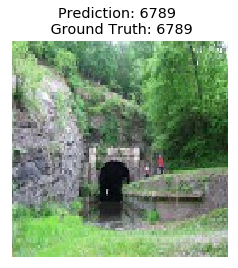

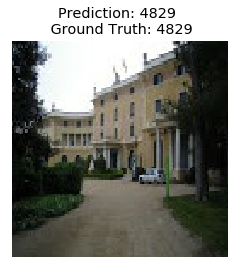

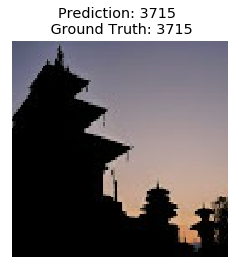

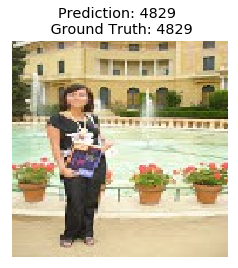

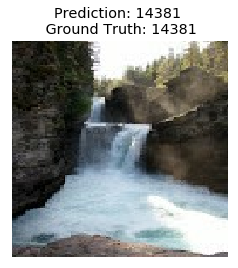

INFO:tensorflow:Model evaluation has completed! Visit TensorBoard for more information regarding your evaluation.


In [73]:
if __name__ == '__main__':
    eval_run()